In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch.nn.functional import pairwise_distance
import torchvision


import time
import math
import logging
import os
import random


import numpy as np
np.bool = np.bool_
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image

from tqdm import tqdm
import cv2
import mxnet as mx

from facenet_pytorch import InceptionResnetV1


## Подготовка данных

### Загрузка VGGFace

In [4]:
rec_path="./faces_vgg_112x112/faces_vgg_112x112/" #path to folder with train.rec files
save_path = os.path.join(rec_path, 'MS1M_112x112')
if not os.path.exists(save_path):
    os.makedirs(save_path)

imgrec = mx.recordio.MXIndexedRecordIO(os.path.join(rec_path, 'train.idx'), os.path.join(rec_path, 'train.rec'), 'r')
img_info = imgrec.read_idx(0)
header,_ = mx.recordio.unpack(img_info)
max_idx = int(header.label[0])
for idx in tqdm(range(1,max_idx)):
    img_info = imgrec.read_idx(idx)
    header, img = mx.recordio.unpack_img(img_info)
    label = int(header.label)
    label_path = os.path.join(save_path, str(label).zfill(6))
    if not os.path.exists(label_path):
        os.makedirs(label_path)
    cv2.imwrite(os.path.join(label_path, str(idx).zfill(8) + '.jpg'), img)

  1%|          | 23127/3137807 [00:14<32:09, 1614.41it/s] 


KeyboardInterrupt: 

In [5]:
class VGGPairDataset(Dataset):
    def __init__(self, image_dir, pair_file, transform=None):
        self.image_dir = image_dir
        self.pair_file = pair_file
        self.transform = transform
        self.pairs = self._load_pairs(pair_file)
    
    def _load_pairs(self, pair_file):
        # Используем pandas для загрузки CSV
        data = pd.read_csv(pair_file)
        pairs = []
        
        for _, row in data.iterrows():
            name1 = str(row['name']).zfill(6)
            imagenum1 = str(row['image1']).zfill(8)  # Преобразуем в строку с ведущими нулями
            name2 = str(row['name.1']).zfill(6)
            imagenum2 = str(row['image2']).zfill(8)  # Преобразуем в строку с ведущими нулями
            label = row['label']
            
            pairs.append((name1, imagenum1, name2, imagenum2, label))
        
        return pairs
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        name1, imagenum1, name2, imagenum2, label = self.pairs[idx]
        
        # Пути к изображениям
        img_path1 = os.path.join(self.image_dir, name1, f"{str(imagenum1)}")
        img_path2 = os.path.join(self.image_dir, name2, f"{str(imagenum2)}")
        
        # Загружаем изображения
        img1 = Image.open(img_path1).convert('RGB')
        img2 = Image.open(img_path2).convert('RGB')
        
        # Применяем трансформации
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        # Возвращаем объединенные изображения и метку
        return torch.cat([img1, img2], dim=0), torch.tensor(label, dtype=torch.float)

# Преобразования для изображений
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
])

# Указываем путь к изображениям и файлу с парами
#image_dir = "./archive/lfw-deepfunneled/lfw-deepfunneled"
#pair_file = "./test_data.csv"  # Укажите путь к вашему CSV файлу

image_dir = "./faces_vgg_112x112/faces_vgg_112x112/MS1M_112x112"
pair_file = "./vgg_pairs.csv"  # Укажите путь к вашему CSV файлу

# Создаем Dataset и DataLoader
dataset = VGGPairDataset(image_dir=image_dir, pair_file=pair_file, transform=transform)
valid_dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

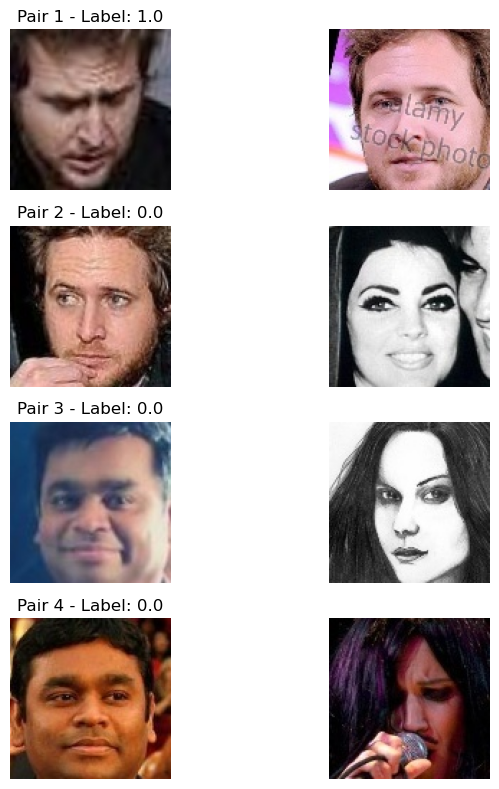

In [ ]:
num_pairs = 4

plt.figure(figsize=(8, 2 * num_pairs))

for idx, (images, labels) in enumerate(valid_dataloader):
    # Разделяем пары изображений
    img1 = images[0, :3, :, :]
    img2 = images[0, 3:, :, :]
    
    plt.subplot(num_pairs, 2, 2 * idx + 1)
    plt.imshow(torchvision.transforms.ToPILImage()(img1))
    plt.title(f'Pair {idx+1} - Label: {labels.item()}')
    plt.axis('off')

    plt.subplot(num_pairs, 2, 2 * idx + 2)
    plt.imshow(torchvision.transforms.ToPILImage()(img2))
    plt.axis('off')


    if idx + 1 == num_pairs:
        break

plt.tight_layout()
plt.show()


### Загрузка CASIA-WebFaces

In [ ]:
rec_path="./faces_webface_112x112/faces_webface_112x112/"
save_path = os.path.join(rec_path, 'MS1M_112x112')
if not os.path.exists(save_path):
    os.makedirs(save_path)

imgrec = mx.recordio.MXIndexedRecordIO(os.path.join(rec_path, 'train.idx'), os.path.join(rec_path, 'train.rec'), 'r')
img_info = imgrec.read_idx(0)
header,_ = mx.recordio.unpack(img_info)
max_idx = int(header.label[0])
for idx in tqdm(range(1,max_idx)):
    img_info = imgrec.read_idx(idx)
    header, img = mx.recordio.unpack_img(img_info)
    label = int(header.label)
    label_path = os.path.join(save_path, str(label).zfill(6))
    if not os.path.exists(label_path):
        os.makedirs(label_path)
    cv2.imwrite(os.path.join(label_path, str(idx).zfill(8) + '.jpg'), img)

  2%|▏         | 9810/490623 [00:06<05:12, 1538.50it/s]


KeyboardInterrupt: 

In [ ]:
data_path = "./faces_webface_112x112/faces_webface_112x112/MS1M_112x112"
batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor()
])

base_dataset = datasets.ImageFolder(root=data_path, transform=transform)

label_to_indices = {}
for idx, (_, label) in enumerate(base_dataset.samples):
    if label not in label_to_indices:
        label_to_indices[label] = []
    label_to_indices[label].append(idx)

# Фильтруем классы, где меньше 2 изображений
label_to_indices = {k: v for k, v in label_to_indices.items() if len(v) > 1}

class TripletDataset(Dataset):
    def __init__(self, dataset, label_to_indices):
        self.dataset = dataset
        self.label_to_indices = label_to_indices
        self.labels = list(label_to_indices.keys())

    def __getitem__(self, index):
        anchor_img, label = self.dataset[index]

        # Положительный пример (другое изображение из того же класса)
        positive_list = self.label_to_indices[label]
        positive_index = index
        while positive_index == index:
            positive_index = random.choice(positive_list)
        positive_img, _ = self.dataset[positive_index]

        # Отрицательный пример (из другого класса)
        negative_label = random.choice(self.labels)
        while negative_label == label:
            negative_label = random.choice(self.labels)
        negative_index = random.choice(self.label_to_indices[negative_label])
        negative_img, _ = self.dataset[negative_index]

        return anchor_img, positive_img, negative_img

    def __len__(self):
        return len(self.dataset)

triplet_dataset = TripletDataset(base_dataset, label_to_indices)
train_dataloader = DataLoader(triplet_dataset, batch_size=batch_size, shuffle=True, num_workers=0)


Batch size: torch.Size([128, 3, 112, 112])
Positive images shape: torch.Size([128, 3, 112, 112])
Negative images shape: torch.Size([128, 3, 112, 112])


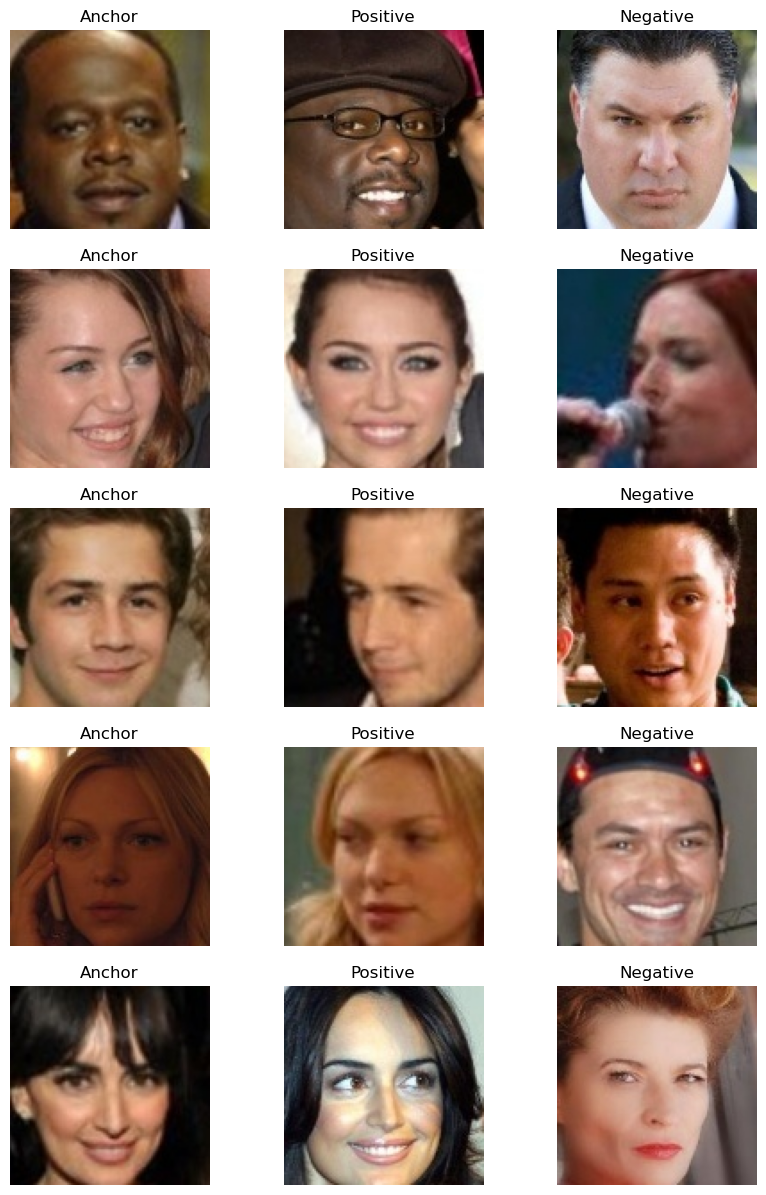

In [ ]:
batch = next(iter(train_dataloader))
anchor_imgs, positive_imgs, negative_imgs = batch

print(f"Batch size: {anchor_imgs.shape}") 
print(f"Positive images shape: {positive_imgs.shape}")
print(f"Negative images shape: {negative_imgs.shape}")

def show_triplets(anchor, positive, negative, num_samples=5):
    fig, axes = plt.subplots(num_samples, 3, figsize=(10, num_samples * 3))

    for i in range(num_samples):
        a, p, n = anchor[i], positive[i], negative[i]

        a = a.permute(1, 2, 0).cpu().numpy()
        p = p.permute(1, 2, 0).cpu().numpy()
        n = n.permute(1, 2, 0).cpu().numpy()

        axes[i, 0].imshow(a)
        axes[i, 0].set_title("Anchor")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(p)
        axes[i, 1].set_title("Positive")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(n)
        axes[i, 2].set_title("Negative")
        axes[i, 2].axis("off")

    plt.show()


show_triplets(anchor_imgs, positive_imgs, negative_imgs, num_samples=5)

## Обучение моделей

### MobileFaceNet

In [7]:
class Bottleneck(nn.Module):
    def __init__(self, inp, oup, stride, expansion):
        super(Bottleneck, self).__init__()
        self.connect = stride == 1 and inp == oup
        #
        self.conv = nn.Sequential(
            #pw
            nn.Conv2d(inp, inp * expansion, 1, 1, 0, bias=False),
            nn.BatchNorm2d(inp * expansion),
            nn.PReLU(inp * expansion),
            # nn.ReLU(inplace=True),

            #dw
            nn.Conv2d(inp * expansion, inp * expansion, 3, stride, 1, groups=inp * expansion, bias=False),
            nn.BatchNorm2d(inp * expansion),
            nn.PReLU(inp * expansion),
            # nn.ReLU(inplace=True),

            #pw-linear
            nn.Conv2d(inp * expansion, oup, 1, 1, 0, bias=False),
            nn.BatchNorm2d(oup),
        )

    def forward(self, x):
        if self.connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

class ConvBlock(nn.Module):
    def __init__(self, inp, oup, k, s, p, dw=False, linear=False):
        super(ConvBlock, self).__init__()
        self.linear = linear
        if dw:
            self.conv = nn.Conv2d(inp, oup, k, s, p, groups=inp, bias=False)
        else:
            self.conv = nn.Conv2d(inp, oup, k, s, p, bias=False)
        self.bn = nn.BatchNorm2d(oup)
        if not linear:
            self.prelu = nn.PReLU(oup)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.linear:
            return x
        else:
            return self.prelu(x)

Mobilefacenet_bottleneck_setting = [
    # t, c , n ,s
    [2, 64, 5, 2],
    [4, 128, 1, 2],
    [2, 128, 6, 1],
    [4, 128, 1, 2],
    [2, 128, 2, 1]
]

Mobilenetv2_bottleneck_setting = [
    # t, c, n, s
    [1, 16, 1, 1],
    [6, 24, 2, 2],
    [6, 32, 3, 2],
    [6, 64, 4, 2],
    [6, 96, 3, 1],
    [6, 160, 3, 2],
    [6, 320, 1, 1],
]

class MobileFacenet(nn.Module):
    def __init__(self, bottleneck_setting=Mobilefacenet_bottleneck_setting):
        super(MobileFacenet, self).__init__()

        self.conv1 = ConvBlock(3, 64, 3, 2, 1)

        self.dw_conv1 = ConvBlock(64, 64, 3, 1, 1, dw=True)

        self.inplanes = 64
        block = Bottleneck
        self.blocks = self._make_layer(block, bottleneck_setting)

        self.conv2 = ConvBlock(128, 512, 1, 1, 0)

        self.linear7 = ConvBlock(512, 512, (7, 7), 1, 0, dw=True, linear=True)

        self.linear1 = ConvBlock(512, 128, 1, 1, 0, linear=True)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, setting):
        layers = []
        for t, c, n, s in setting:
            for i in range(n):
                if i == 0:
                    layers.append(block(self.inplanes, c, s, t))
                else:
                    layers.append(block(self.inplanes, c, 1, t))
                self.inplanes = c

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.dw_conv1(x)
        x = self.blocks(x)
        x = self.conv2(x)
        x = self.linear7(x)
        x = self.linear1(x)
        x = x.view(x.size(0), -1)

        return x

#### Цикл обучения

In [ ]:
def debug_evaluate_vgg(model, dataloader, device='cuda'):
    model.eval()
    embeddings_list, labels_list = [], []
    
    with torch.no_grad():
        for img_pair, labels in tqdm(dataloader, desc='Validating:'):
            img_pair = img_pair.to(device)

            with torch.amp.autocast('cuda'):
                embeddings1 = model(img_pair[:, :3, :, :])
                embeddings2 = model(img_pair[:, 3:, :, :])

            embeddings_list.append((embeddings1, embeddings2))
            labels_list.append(labels)

    embeddings1 = torch.cat([pair[0] for pair in embeddings_list])
    embeddings2 = torch.cat([pair[1] for pair in embeddings_list])
    labels = torch.cat(labels_list, dim=0).to(device)

    embeddings1 = F.normalize(embeddings1, p=2, dim=1)
    embeddings2 = F.normalize(embeddings2, p=2, dim=1)

    cos_sim = F.cosine_similarity(embeddings1, embeddings2, dim=1)
    
    print(f"Min cos_sim: {cos_sim.min()}, Max cos_sim: {cos_sim.max()}")
    print(f"Mean cos_sim: {cos_sim.mean()}")

    euclidean_distance = torch.norm(embeddings1 - embeddings2, p=2, dim=1)
    
    print(f"Min L2 distance: {euclidean_distance.min()}, Max L2 distance: {euclidean_distance.max()}")
    print(f"Mean L2 distance: {euclidean_distance.mean()}")

    thresholds = [x * 0.05 for x in range(1, 20)] 
    best_cos_threshold, best_cos_accuracy = 0.5, 0
    
    for threshold in thresholds:
        predictions = cos_sim > threshold
        accuracy = (predictions.int() == labels.int()).float().mean().item()
        if accuracy > best_cos_accuracy:
            best_cos_accuracy = accuracy
            best_cos_threshold = threshold

    l2_thresholds = torch.linspace(euclidean_distance.min(), euclidean_distance.max(), steps=20).tolist()
    best_l2_threshold, best_l2_accuracy = 0, 0

    for threshold in l2_thresholds:
        predictions = euclidean_distance < threshold
        accuracy = (predictions.int() == labels.int()).float().mean().item()
        if accuracy > best_l2_accuracy:
            best_l2_accuracy = accuracy
            best_l2_threshold = threshold

    cos_sim_np = cos_sim.cpu().numpy()
    labels_np = labels.cpu().numpy()

    same_mask = labels_np == 1
    diff_mask = labels_np == 0

    plt.figure(figsize=(8, 5))
    plt.hist(cos_sim_np[same_mask], bins=50, alpha=0.5, color='blue', label='Same Person')
    plt.hist(cos_sim_np[diff_mask], bins=50, alpha=0.5, color='red', label='Different People')

    plt.axvline(best_cos_threshold, color='black', linestyle='dashed', label=f'Best Threshold = {best_cos_threshold}')

    plt.xlabel("Cosine Similarity")
    plt.ylabel("Frequency")
    plt.title("Cosine Similarity Distribution for Same and Different People")
    plt.legend()
    plt.show()

    l2_dist_np = euclidean_distance.cpu().numpy()

    plt.figure(figsize=(8, 5))
    plt.hist(l2_dist_np[same_mask], bins=50, alpha=0.5, color='blue', label='Same Person')
    plt.hist(l2_dist_np[diff_mask], bins=50, alpha=0.5, color='red', label='Different People')
    plt.axvline(best_l2_threshold, color='black', linestyle='dashed', label=f'Best L2 Threshold = {best_l2_threshold:.2f}')
    plt.xlabel("L2 Distance")
    plt.ylabel("Frequency")
    plt.title("L2 Distance Distribution for Same and Different People")
    plt.legend()
    plt.show()

    print(f"Best Cosine Threshold: {best_cos_threshold}, Accuracy: {best_cos_accuracy:.4f}")
    print(f"Best L2 Threshold: {best_l2_threshold}, Accuracy: {best_l2_accuracy:.4f}")
    
    return best_cos_accuracy

In [ ]:
def mobile_face_net_train(model, criterion, optimizer, train_loader, val_loader, num_epochs=10, device='cuda'):
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    model.to(device)
    scaler = torch.amp.GradScaler()
    train_losses = []
    val_acc = []
    full_time = time.time()
    
    for epoch in range(num_epochs):
        model.train()
        start_time = time.time()
        train_loss = 0

        for anchor, positive, negative in tqdm(train_loader, desc=f'Training epoch {epoch}:'):
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            optimizer.zero_grad()

            with torch.amp.autocast('cuda'):
                anchor_embed = model(anchor)
                positive_embed = model(positive)
                negative_embed = model(negative)

                loss = criterion(anchor_embed, positive_embed, negative_embed)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        logging.info(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss:.4f}, Time for Epoch: {time.time() - start_time:.2f}s, Time since start: {time.time() - full_time:.2f}s")
        
        vgg_accuracy = debug_evaluate_vgg(model, val_loader, device='cuda')
        val_acc.append(vgg_accuracy)
        logging.info(f"VGG Accuracy after Epoch {epoch+1}: {vgg_accuracy:.4f}")
        torch.save(model.state_dict(), f'MobileFaceNet_{epoch}_epoch.pt')

    return train_losses, val_acc

Training epoch 0:: 100%|██████████| 3833/3833 [24:31<00:00,  2.60it/s]
2025-04-05 00:44:52,484 - INFO - Epoch 1/30, Loss: 0.6738, Time for Epoch: 1471.74s, Time since start: 1471.74s
Validating:: 100%|██████████| 13964/13964 [03:46<00:00, 61.58it/s]


Min cos_sim: -0.802734375, Max cos_sim: 0.970703125
Mean cos_sim: 0.31591796875
Min L2 distance: 0.2451171875, Max L2 distance: 1.8984375
Mean L2 distance: 1.1103515625


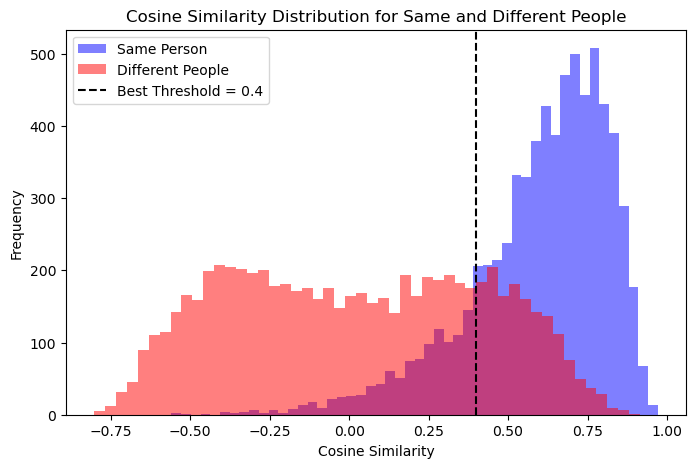

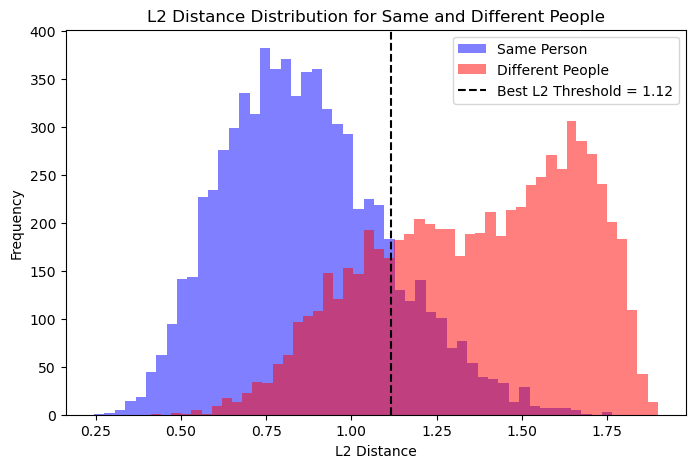

2025-04-05 00:48:39,761 - INFO - VGG Accuracy after Epoch 1: 0.8088


Best Cosine Threshold: 0.4, Accuracy: 0.8088
Best L2 Threshold: 1.1152857542037964, Accuracy: 0.8101


Training epoch 1:: 100%|██████████| 3833/3833 [19:59<00:00,  3.19it/s]
2025-04-05 01:08:39,791 - INFO - Epoch 2/30, Loss: 0.4401, Time for Epoch: 1199.98s, Time since start: 2899.04s
Validating:: 100%|██████████| 13964/13964 [03:03<00:00, 75.95it/s]


Min cos_sim: -0.78173828125, Max cos_sim: 0.951171875
Mean cos_sim: 0.32275390625
Min L2 distance: 0.314453125, Max L2 distance: 1.8876953125
Mean L2 distance: 1.1044921875


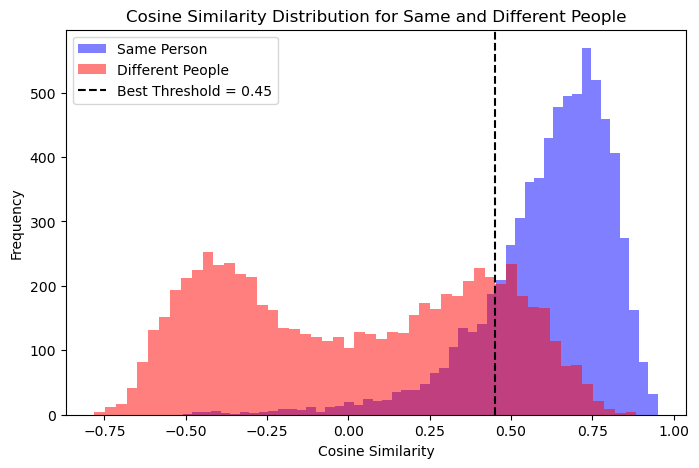

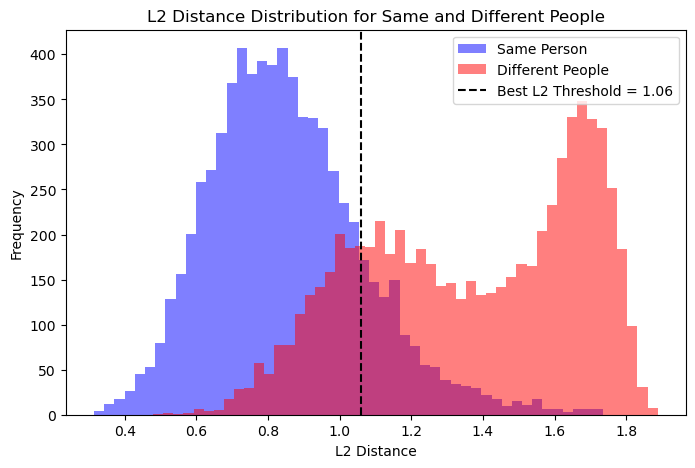

2025-04-05 01:11:44,051 - INFO - VGG Accuracy after Epoch 2: 0.8221


Best Cosine Threshold: 0.45, Accuracy: 0.8221
Best L2 Threshold: 1.0596730709075928, Accuracy: 0.8230


Training epoch 2:: 100%|██████████| 3833/3833 [19:16<00:00,  3.31it/s]
2025-04-05 01:31:00,914 - INFO - Epoch 3/30, Loss: 0.2736, Time for Epoch: 1156.82s, Time since start: 4240.17s
Validating:: 100%|██████████| 13964/13964 [03:02<00:00, 76.70it/s]


Min cos_sim: -0.86767578125, Max cos_sim: 0.97314453125
Mean cos_sim: 0.370361328125
Min L2 distance: 0.2335205078125, Max L2 distance: 1.9326171875
Mean L2 distance: 1.025390625


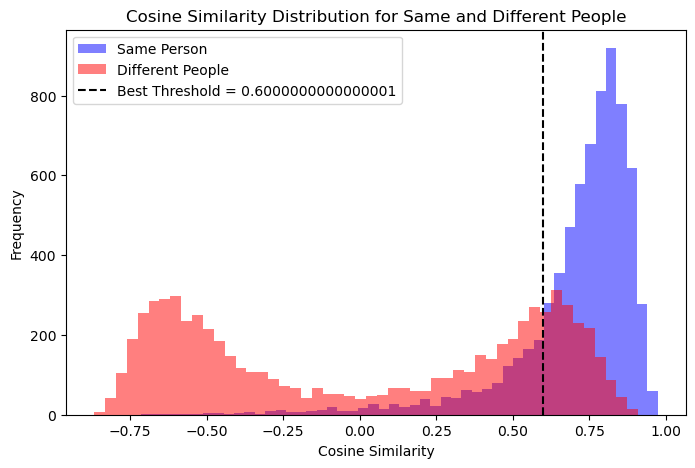

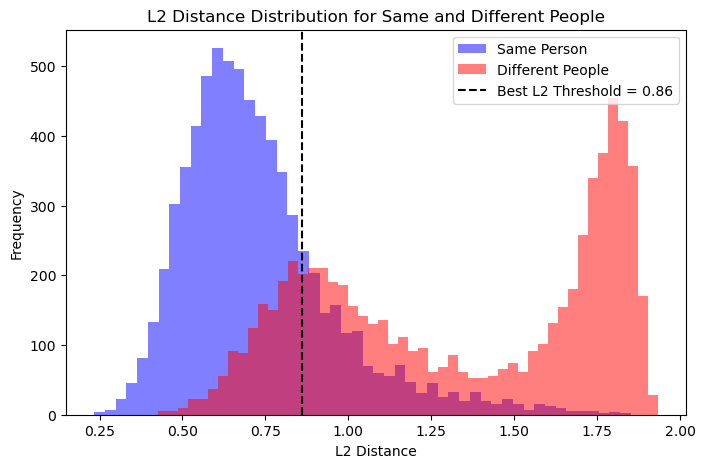

2025-04-05 01:34:03,505 - INFO - VGG Accuracy after Epoch 3: 0.8017


Best Cosine Threshold: 0.6000000000000001, Accuracy: 0.8017
Best L2 Threshold: 0.859503448009491, Accuracy: 0.8006


Training epoch 3:: 100%|██████████| 3833/3833 [19:26<00:00,  3.29it/s]
2025-04-05 01:53:30,121 - INFO - Epoch 4/30, Loss: 0.2340, Time for Epoch: 1166.56s, Time since start: 5589.37s
Validating:: 100%|██████████| 13964/13964 [03:04<00:00, 75.81it/s]


Min cos_sim: -0.7021484375, Max cos_sim: 0.9697265625
Mean cos_sim: 0.31494140625
Min L2 distance: 0.2454833984375, Max L2 distance: 1.8447265625
Mean L2 distance: 1.119140625


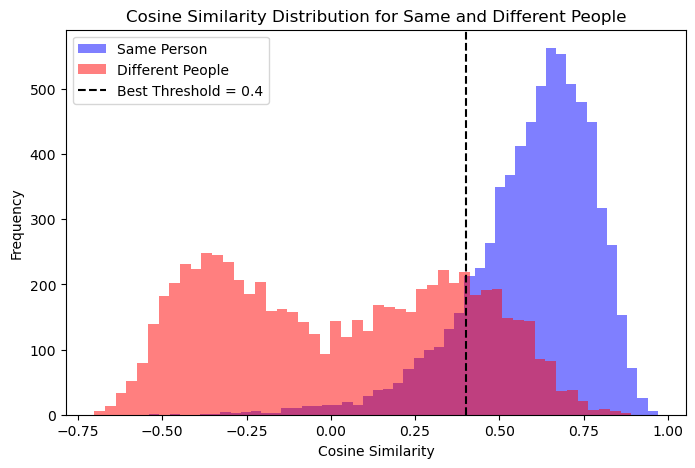

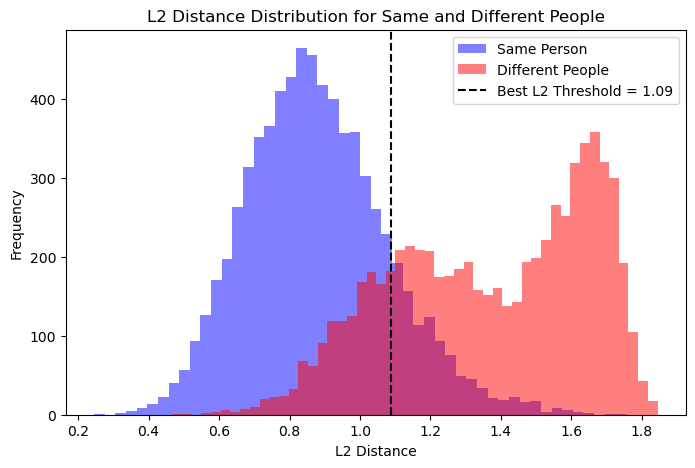

2025-04-05 01:56:34,885 - INFO - VGG Accuracy after Epoch 4: 0.8319


Best Cosine Threshold: 0.4, Accuracy: 0.8319
Best L2 Threshold: 1.0871903896331787, Accuracy: 0.8314


Training epoch 4:: 100%|██████████| 3833/3833 [19:00<00:00,  3.36it/s]
2025-04-05 02:15:35,550 - INFO - Epoch 5/30, Loss: 0.1660, Time for Epoch: 1140.62s, Time since start: 6914.80s
Validating:: 100%|██████████| 13964/13964 [03:01<00:00, 76.87it/s]


Min cos_sim: -0.875, Max cos_sim: 0.9814453125
Mean cos_sim: 0.391357421875
Min L2 distance: 0.19384765625, Max L2 distance: 1.9365234375
Mean L2 distance: 0.99560546875


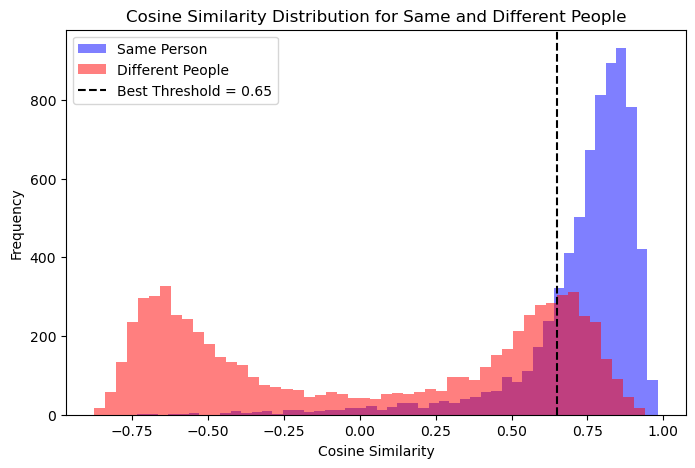

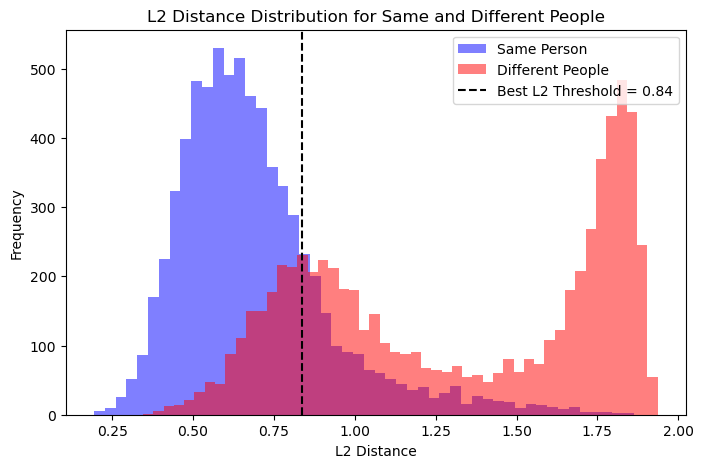

2025-04-05 02:18:37,670 - INFO - VGG Accuracy after Epoch 5: 0.8020


Best Cosine Threshold: 0.65, Accuracy: 0.8020
Best L2 Threshold: 0.8358861207962036, Accuracy: 0.8020


Training epoch 5:: 100%|██████████| 3833/3833 [19:19<00:00,  3.31it/s]
2025-04-05 02:37:57,276 - INFO - Epoch 6/30, Loss: 0.1494, Time for Epoch: 1159.56s, Time since start: 8256.53s
Validating:: 100%|██████████| 13964/13964 [03:03<00:00, 76.22it/s]


Min cos_sim: -0.85302734375, Max cos_sim: 0.97216796875
Mean cos_sim: 0.363525390625
Min L2 distance: 0.2364501953125, Max L2 distance: 1.92578125
Mean L2 distance: 1.0458984375


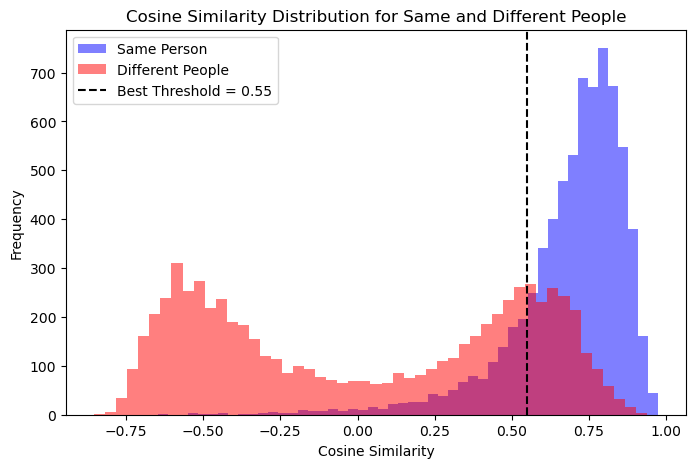

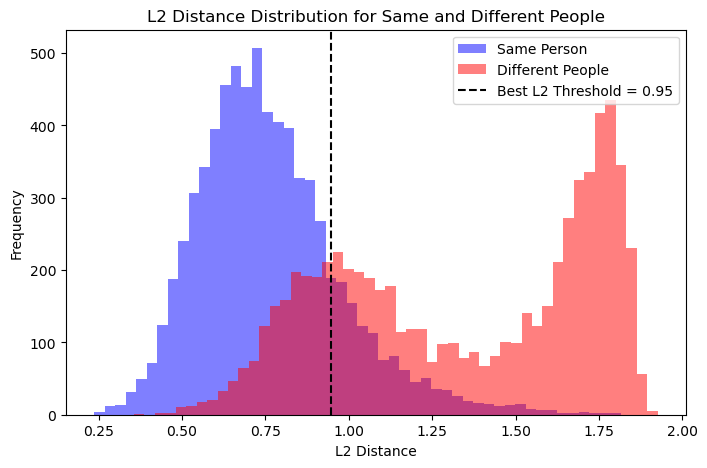

2025-04-05 02:41:00,957 - INFO - VGG Accuracy after Epoch 6: 0.8082


Best Cosine Threshold: 0.55, Accuracy: 0.8082
Best L2 Threshold: 0.9477474689483643, Accuracy: 0.8082


Training epoch 6:: 100%|██████████| 3833/3833 [19:27<00:00,  3.28it/s]
2025-04-05 03:00:28,060 - INFO - Epoch 7/30, Loss: 0.1320, Time for Epoch: 1167.06s, Time since start: 9607.31s
Validating:: 100%|██████████| 13964/13964 [03:05<00:00, 75.47it/s]


Min cos_sim: -0.82666015625, Max cos_sim: 0.96435546875
Mean cos_sim: 0.3623046875
Min L2 distance: 0.267333984375, Max L2 distance: 1.9111328125
Mean L2 distance: 1.052734375


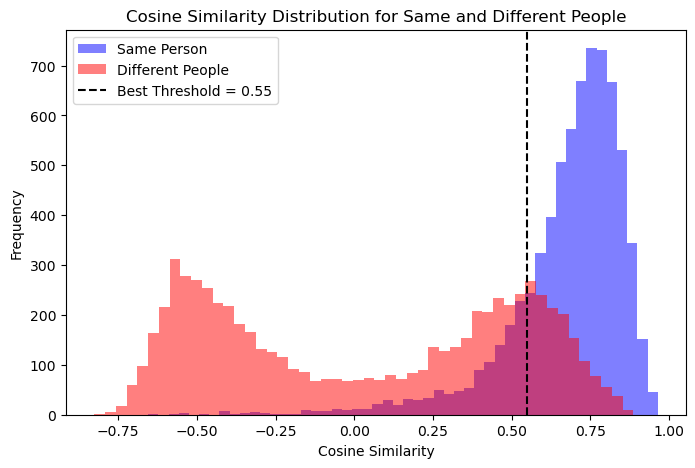

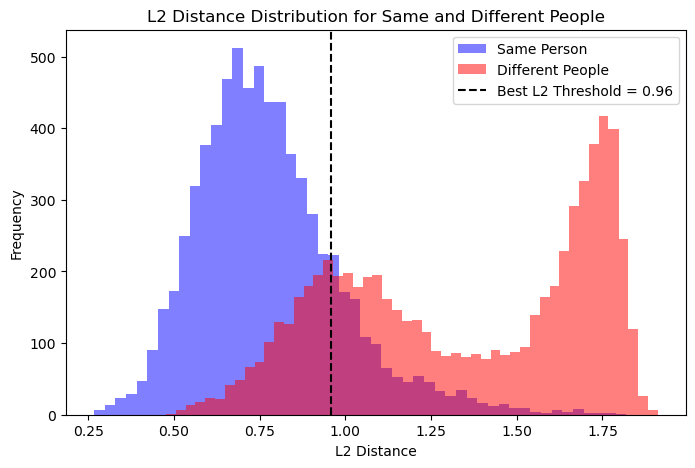

2025-04-05 03:03:33,526 - INFO - VGG Accuracy after Epoch 7: 0.8165


Best Cosine Threshold: 0.55, Accuracy: 0.8165
Best L2 Threshold: 0.9594597816467285, Accuracy: 0.8174


Training epoch 7:: 100%|██████████| 3833/3833 [18:47<00:00,  3.40it/s]
2025-04-05 03:22:21,534 - INFO - Epoch 8/30, Loss: 0.1239, Time for Epoch: 1127.95s, Time since start: 10920.79s
Validating:: 100%|██████████| 13964/13964 [03:01<00:00, 76.74it/s]


Min cos_sim: -0.88427734375, Max cos_sim: 0.9814453125
Mean cos_sim: 0.41064453125
Min L2 distance: 0.19287109375, Max L2 distance: 1.9404296875
Mean L2 distance: 0.9658203125


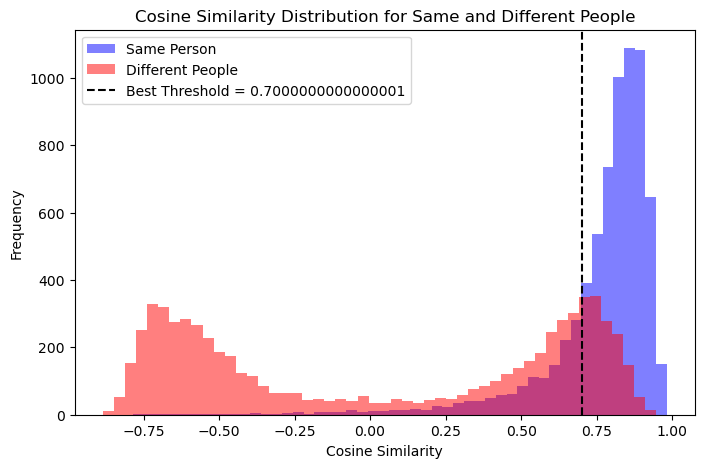

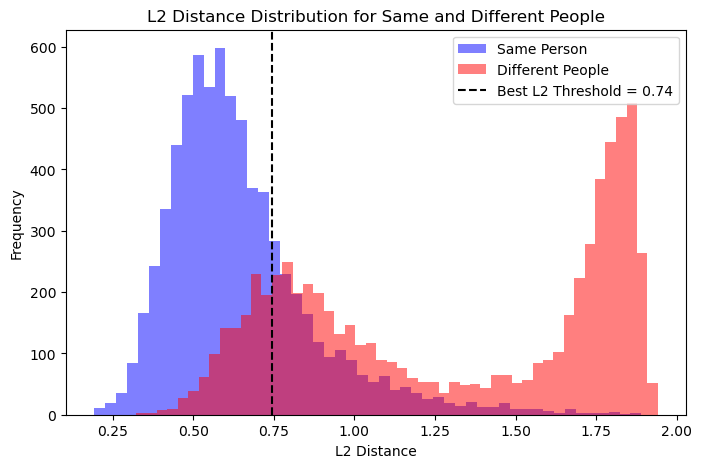

2025-04-05 03:25:24,076 - INFO - VGG Accuracy after Epoch 8: 0.7977


Best Cosine Threshold: 0.7000000000000001, Accuracy: 0.7977
Best L2 Threshold: 0.7447317242622375, Accuracy: 0.7957


Training epoch 8:: 100%|██████████| 3833/3833 [20:01<00:00,  3.19it/s]
2025-04-05 03:45:25,339 - INFO - Epoch 9/30, Loss: 0.1148, Time for Epoch: 1201.20s, Time since start: 12304.59s
Validating:: 100%|██████████| 13964/13964 [03:12<00:00, 72.69it/s]


Min cos_sim: -0.87744140625, Max cos_sim: 0.98876953125
Mean cos_sim: 0.43115234375
Min L2 distance: 0.1502685546875, Max L2 distance: 1.9375
Mean L2 distance: 0.9267578125


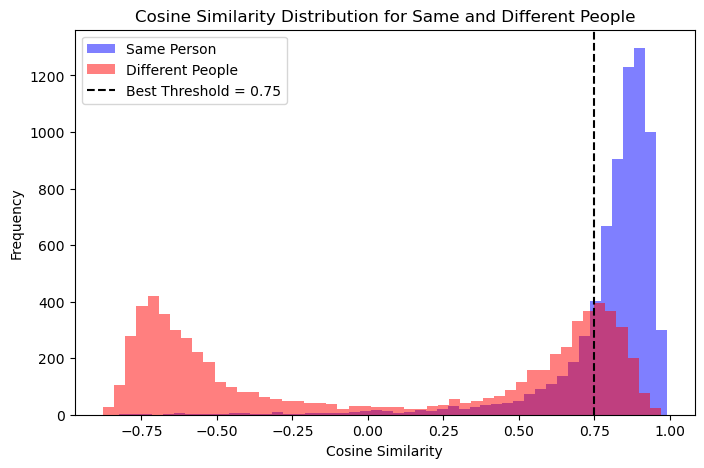

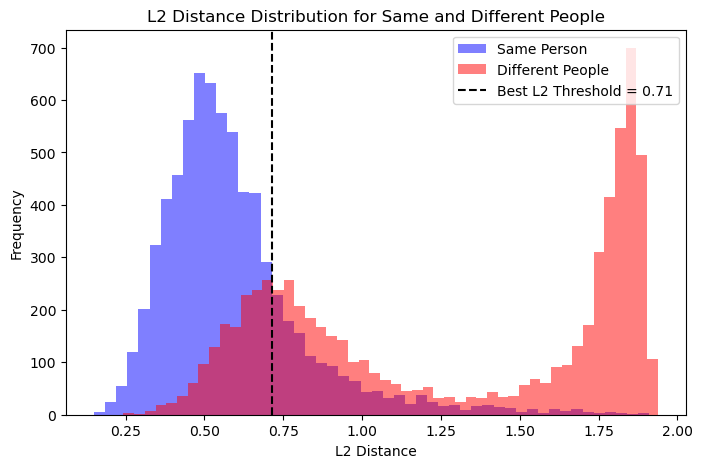

2025-04-05 03:48:37,944 - INFO - VGG Accuracy after Epoch 9: 0.7981


Best Cosine Threshold: 0.75, Accuracy: 0.7981
Best L2 Threshold: 0.7146574258804321, Accuracy: 0.7975


Training epoch 9:: 100%|██████████| 3833/3833 [19:14<00:00,  3.32it/s]
2025-04-05 04:07:52,161 - INFO - Epoch 10/30, Loss: 0.1087, Time for Epoch: 1154.17s, Time since start: 13651.41s
Validating:: 100%|██████████| 13964/13964 [03:03<00:00, 75.93it/s]


Min cos_sim: -0.81640625, Max cos_sim: 0.96826171875
Mean cos_sim: 0.39697265625
Min L2 distance: 0.252685546875, Max L2 distance: 1.90625
Mean L2 distance: 1.005859375


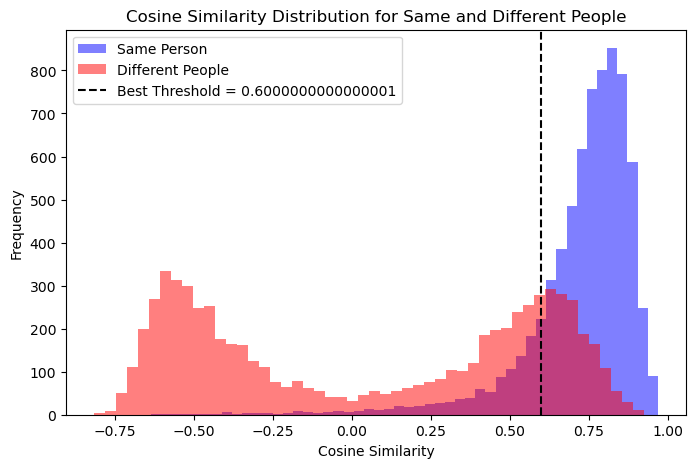

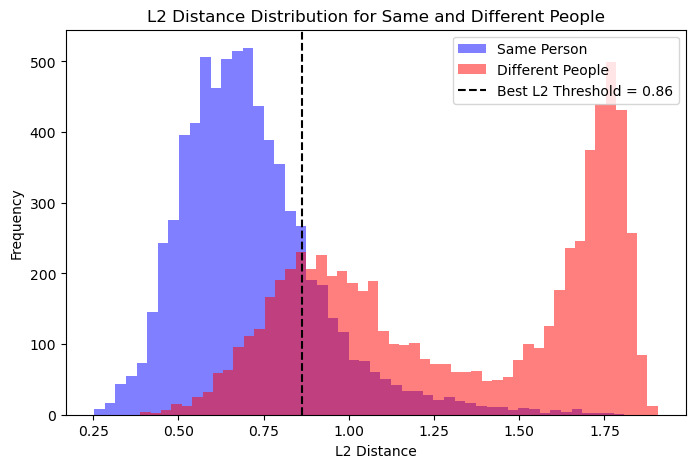

2025-04-05 04:10:56,522 - INFO - VGG Accuracy after Epoch 10: 0.8161


Best Cosine Threshold: 0.6000000000000001, Accuracy: 0.8161
Best L2 Threshold: 0.8618935346603394, Accuracy: 0.8170


Training epoch 10:: 100%|██████████| 3833/3833 [18:56<00:00,  3.37it/s]
2025-04-05 04:29:52,908 - INFO - Epoch 11/30, Loss: 0.1012, Time for Epoch: 1136.33s, Time since start: 14972.16s
Validating:: 100%|██████████| 13964/13964 [03:02<00:00, 76.39it/s]


Min cos_sim: -0.82080078125, Max cos_sim: 0.9833984375
Mean cos_sim: 0.418701171875
Min L2 distance: 0.1800537109375, Max L2 distance: 1.908203125
Mean L2 distance: 0.96533203125


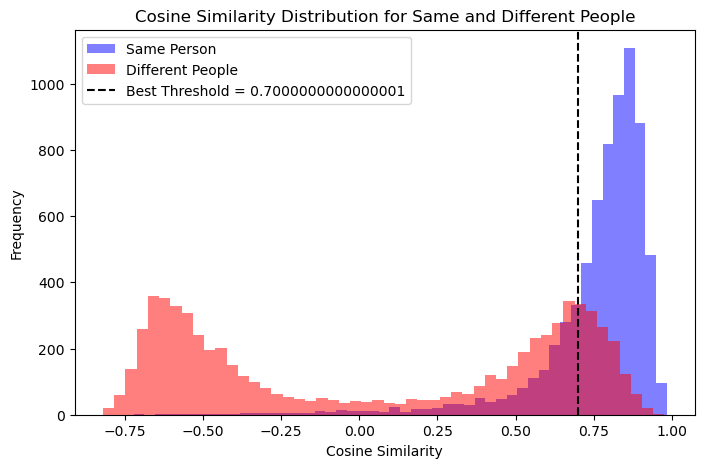

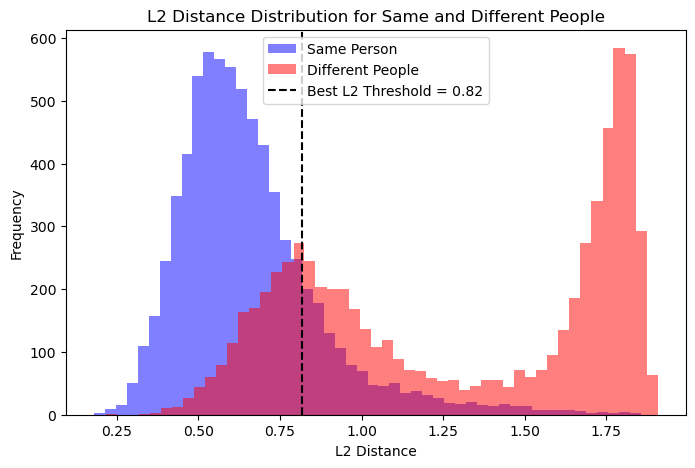

2025-04-05 04:32:56,158 - INFO - VGG Accuracy after Epoch 11: 0.8028


Best Cosine Threshold: 0.7000000000000001, Accuracy: 0.8028
Best L2 Threshold: 0.8167403340339661, Accuracy: 0.8003


Training epoch 11:: 100%|██████████| 3833/3833 [19:04<00:00,  3.35it/s]
2025-04-05 04:52:00,961 - INFO - Epoch 12/30, Loss: 0.0963, Time for Epoch: 1144.76s, Time since start: 16300.21s
Validating:: 100%|██████████| 13964/13964 [03:02<00:00, 76.61it/s]


Min cos_sim: -0.806640625, Max cos_sim: 0.978515625
Mean cos_sim: 0.407958984375
Min L2 distance: 0.20556640625, Max L2 distance: 1.9013671875
Mean L2 distance: 0.99169921875


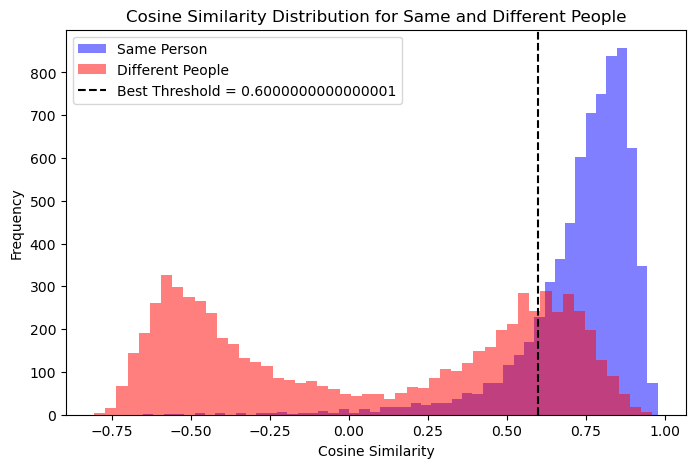

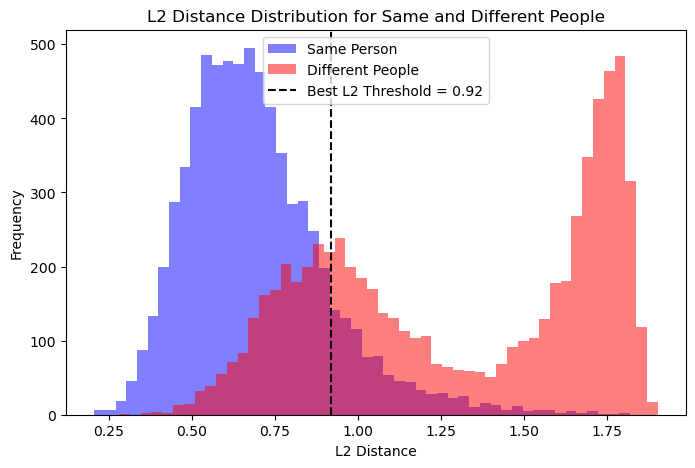

2025-04-05 04:55:03,781 - INFO - VGG Accuracy after Epoch 12: 0.8107


Best Cosine Threshold: 0.6000000000000001, Accuracy: 0.8107
Best L2 Threshold: 0.9195877909660339, Accuracy: 0.8101


Training epoch 12:: 100%|██████████| 3833/3833 [19:05<00:00,  3.35it/s]
2025-04-05 05:14:09,562 - INFO - Epoch 13/30, Loss: 0.0925, Time for Epoch: 1145.72s, Time since start: 17628.82s
Validating:: 100%|██████████| 13964/13964 [03:04<00:00, 75.65it/s]


Min cos_sim: -0.7353515625, Max cos_sim: 0.966796875
Mean cos_sim: 0.398193359375
Min L2 distance: 0.2578125, Max L2 distance: 1.86328125
Mean L2 distance: 1.021484375


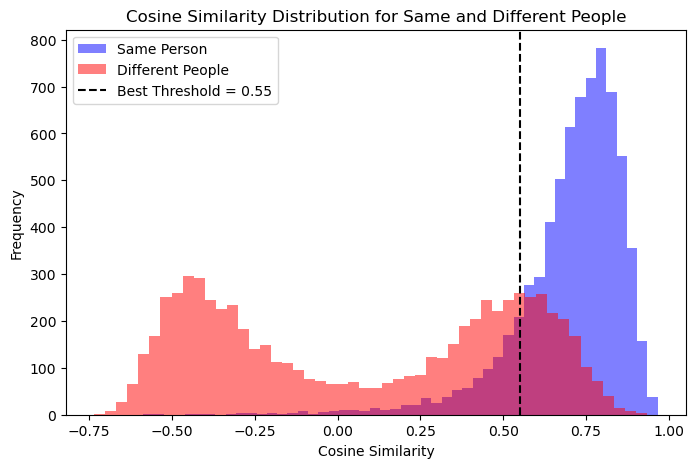

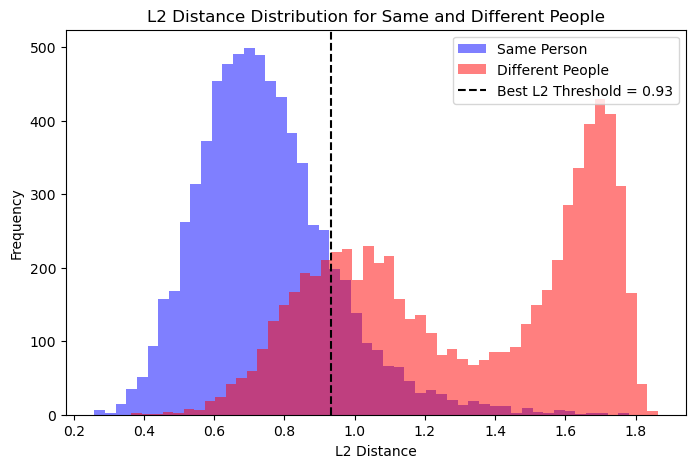

2025-04-05 05:17:14,594 - INFO - VGG Accuracy after Epoch 13: 0.8269


Best Cosine Threshold: 0.55, Accuracy: 0.8269
Best L2 Threshold: 0.9337993264198303, Accuracy: 0.8273


Training epoch 13:: 100%|██████████| 3833/3833 [18:47<00:00,  3.40it/s]
2025-04-05 05:36:01,983 - INFO - Epoch 14/30, Loss: 0.0875, Time for Epoch: 1127.35s, Time since start: 18941.24s
Validating:: 100%|██████████| 13964/13964 [03:01<00:00, 76.93it/s]


Min cos_sim: -0.85546875, Max cos_sim: 0.990234375
Mean cos_sim: 0.451416015625
Min L2 distance: 0.14111328125, Max L2 distance: 1.92578125
Mean L2 distance: 0.8974609375


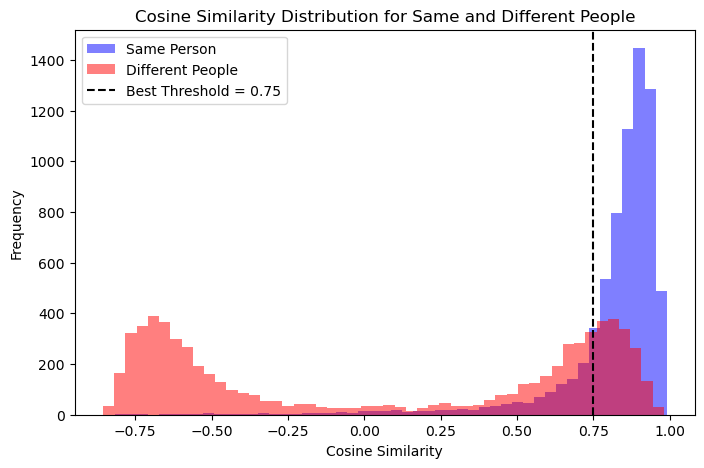

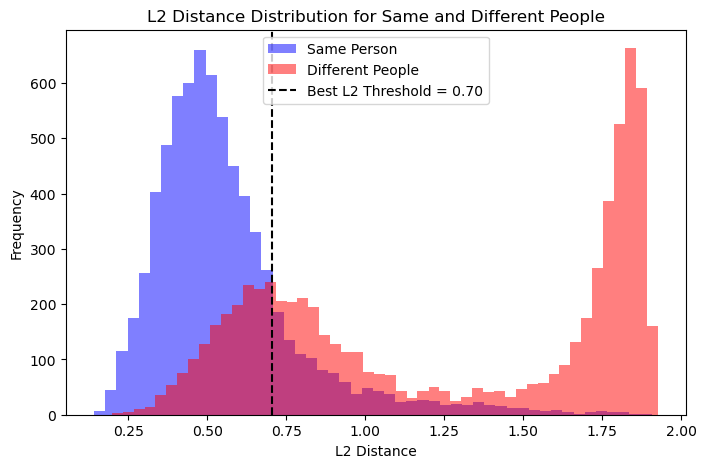

2025-04-05 05:39:03,928 - INFO - VGG Accuracy after Epoch 14: 0.7995


Best Cosine Threshold: 0.75, Accuracy: 0.7995
Best L2 Threshold: 0.7046926617622375, Accuracy: 0.7993


Training epoch 14:: 100%|██████████| 3833/3833 [19:01<00:00,  3.36it/s]
2025-04-05 05:58:05,047 - INFO - Epoch 15/30, Loss: 0.0846, Time for Epoch: 1141.08s, Time since start: 20264.30s
Validating:: 100%|██████████| 13964/13964 [03:01<00:00, 77.05it/s]


Min cos_sim: -0.87548828125, Max cos_sim: 0.990234375
Mean cos_sim: 0.45751953125
Min L2 distance: 0.14013671875, Max L2 distance: 1.9365234375
Mean L2 distance: 0.88427734375


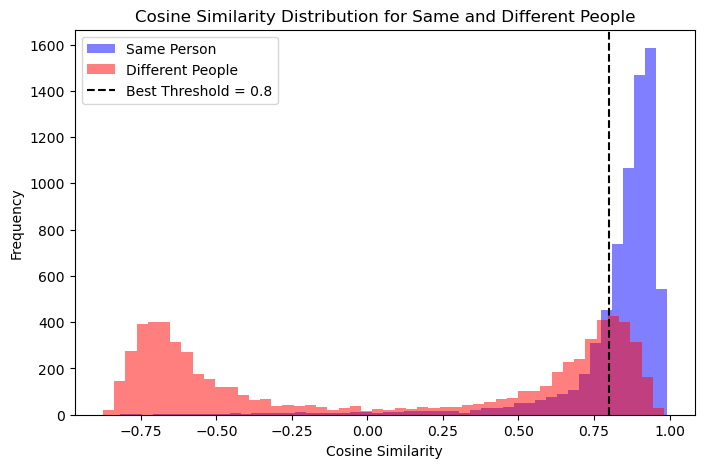

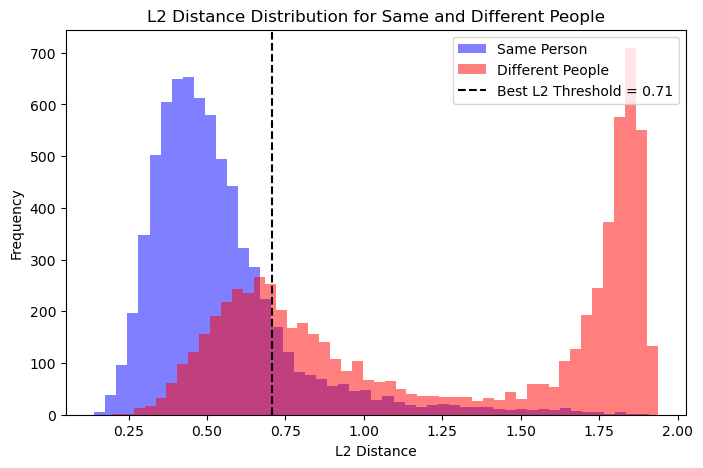

2025-04-05 06:01:06,827 - INFO - VGG Accuracy after Epoch 15: 0.7952


Best Cosine Threshold: 0.8, Accuracy: 0.7952
Best L2 Threshold: 0.7074167132377625, Accuracy: 0.7934


Training epoch 15:: 100%|██████████| 3833/3833 [19:03<00:00,  3.35it/s]
2025-04-05 06:20:10,824 - INFO - Epoch 16/30, Loss: 0.0777, Time for Epoch: 1143.95s, Time since start: 21590.08s
Validating:: 100%|██████████| 13964/13964 [03:05<00:00, 75.29it/s]


Min cos_sim: -0.76171875, Max cos_sim: 0.98486328125
Mean cos_sim: 0.426025390625
Min L2 distance: 0.173828125, Max L2 distance: 1.8759765625
Mean L2 distance: 0.9736328125


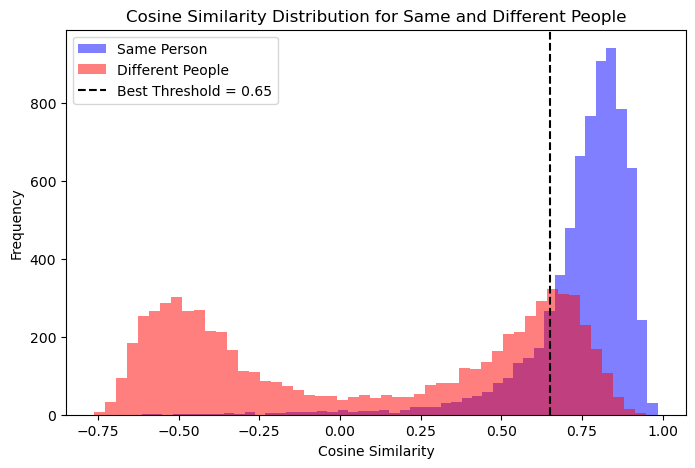

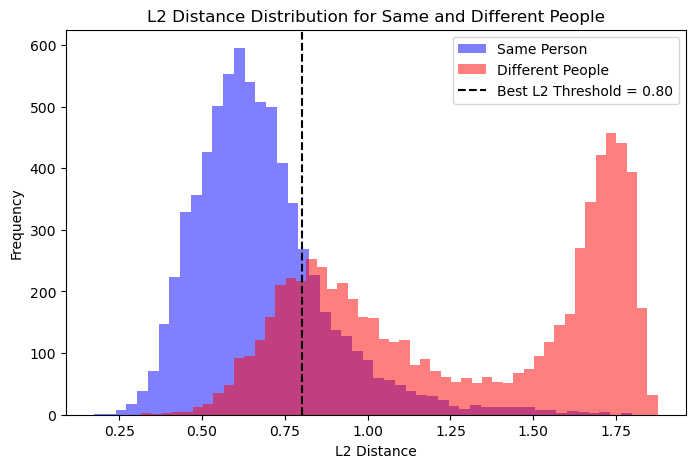

2025-04-05 06:23:16,900 - INFO - VGG Accuracy after Epoch 16: 0.8156


Best Cosine Threshold: 0.65, Accuracy: 0.8156
Best L2 Threshold: 0.8009354472160339, Accuracy: 0.8131


Training epoch 16:: 100%|██████████| 3833/3833 [18:51<00:00,  3.39it/s]
2025-04-05 06:42:08,379 - INFO - Epoch 17/30, Loss: 0.0810, Time for Epoch: 1131.43s, Time since start: 22907.63s
Validating:: 100%|██████████| 13964/13964 [03:01<00:00, 76.73it/s]


Min cos_sim: -0.81005859375, Max cos_sim: 0.9716796875
Mean cos_sim: 0.4345703125
Min L2 distance: 0.2366943359375, Max L2 distance: 1.90234375
Mean L2 distance: 0.95703125


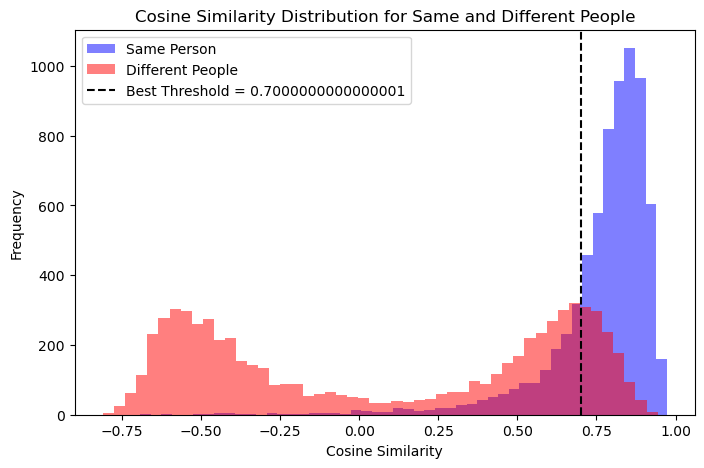

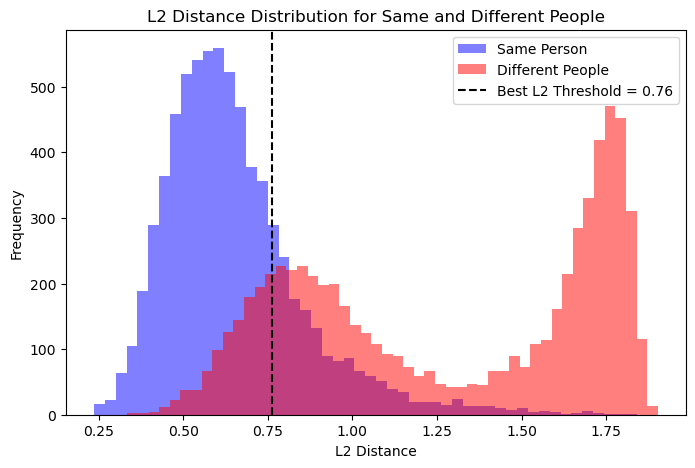

2025-04-05 06:45:10,842 - INFO - VGG Accuracy after Epoch 17: 0.8121


Best Cosine Threshold: 0.7000000000000001, Accuracy: 0.8121
Best L2 Threshold: 0.7626888751983643, Accuracy: 0.8116


Training epoch 17:: 100%|██████████| 3833/3833 [19:00<00:00,  3.36it/s]
2025-04-05 07:04:10,995 - INFO - Epoch 18/30, Loss: 0.0760, Time for Epoch: 1140.11s, Time since start: 24230.25s
Validating:: 100%|██████████| 13964/13964 [03:01<00:00, 76.74it/s]


Min cos_sim: -0.8349609375, Max cos_sim: 0.98486328125
Mean cos_sim: 0.45654296875
Min L2 distance: 0.1722412109375, Max L2 distance: 1.916015625
Mean L2 distance: 0.90283203125


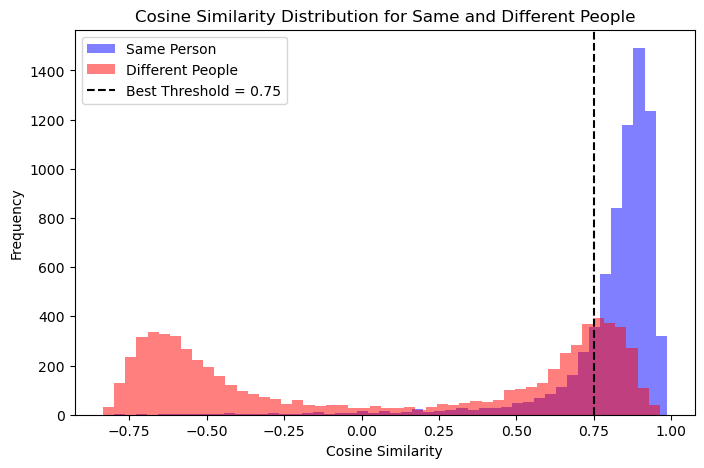

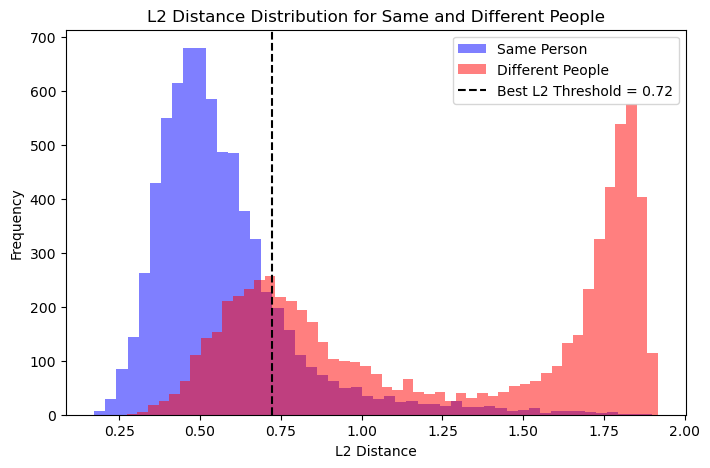

2025-04-05 07:07:13,376 - INFO - VGG Accuracy after Epoch 18: 0.8025


Best Cosine Threshold: 0.75, Accuracy: 0.8025
Best L2 Threshold: 0.7229068279266357, Accuracy: 0.8006


Training epoch 18:: 100%|██████████| 3833/3833 [19:03<00:00,  3.35it/s]
2025-04-05 07:26:16,872 - INFO - Epoch 19/30, Loss: 0.0725, Time for Epoch: 1143.44s, Time since start: 25556.13s
Validating:: 100%|██████████| 13964/13964 [03:03<00:00, 75.97it/s]


Min cos_sim: -0.82861328125, Max cos_sim: 0.98779296875
Mean cos_sim: 0.457763671875
Min L2 distance: 0.1585693359375, Max L2 distance: 1.912109375
Mean L2 distance: 0.90625


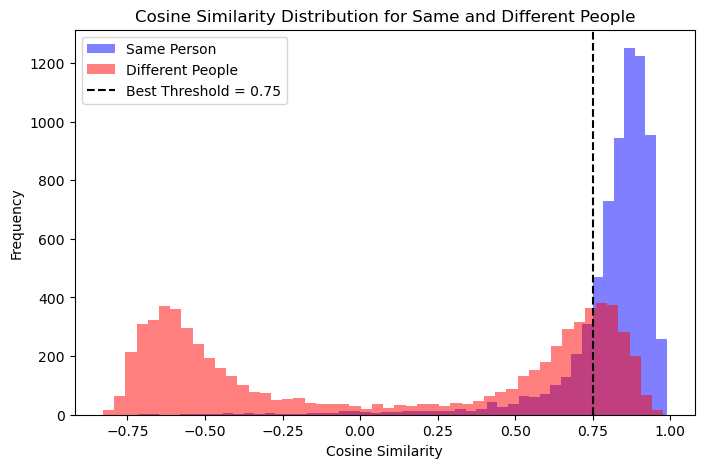

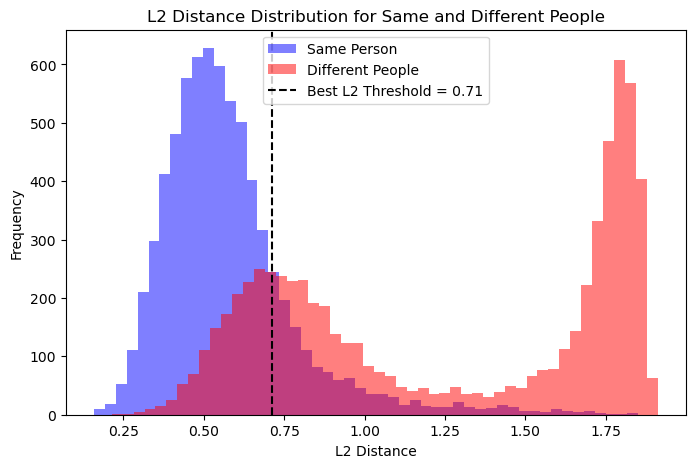

2025-04-05 07:29:21,112 - INFO - VGG Accuracy after Epoch 19: 0.8065


Best Cosine Threshold: 0.75, Accuracy: 0.8065
Best L2 Threshold: 0.7123187780380249, Accuracy: 0.8068


Training epoch 19:: 100%|██████████| 3833/3833 [19:00<00:00,  3.36it/s]
2025-04-05 07:48:21,492 - INFO - Epoch 20/30, Loss: 0.0656, Time for Epoch: 1140.32s, Time since start: 26880.74s
Validating:: 100%|██████████| 13964/13964 [03:03<00:00, 76.12it/s]


Min cos_sim: -0.74365234375, Max cos_sim: 0.974609375
Mean cos_sim: 0.43212890625
Min L2 distance: 0.22705078125, Max L2 distance: 1.8671875
Mean L2 distance: 0.98046875


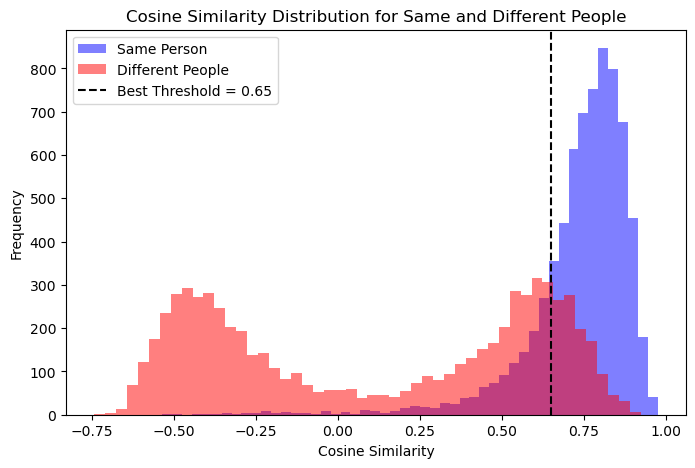

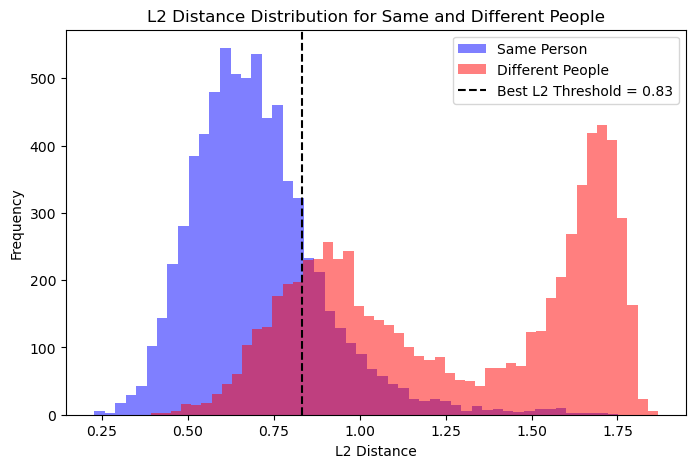

2025-04-05 07:51:25,353 - INFO - VGG Accuracy after Epoch 20: 0.8233


Best Cosine Threshold: 0.65, Accuracy: 0.8233
Best L2 Threshold: 0.8313117027282715, Accuracy: 0.8215


Training epoch 20:: 100%|██████████| 3833/3833 [19:21<00:00,  3.30it/s]
2025-04-05 08:10:46,512 - INFO - Epoch 21/30, Loss: 0.0665, Time for Epoch: 1161.11s, Time since start: 28225.76s
Validating:: 100%|██████████| 13964/13964 [03:02<00:00, 76.42it/s]


Min cos_sim: -0.6298828125, Max cos_sim: 0.9619140625
Mean cos_sim: 0.430419921875
Min L2 distance: 0.276123046875, Max L2 distance: 1.8056640625
Mean L2 distance: 0.9951171875


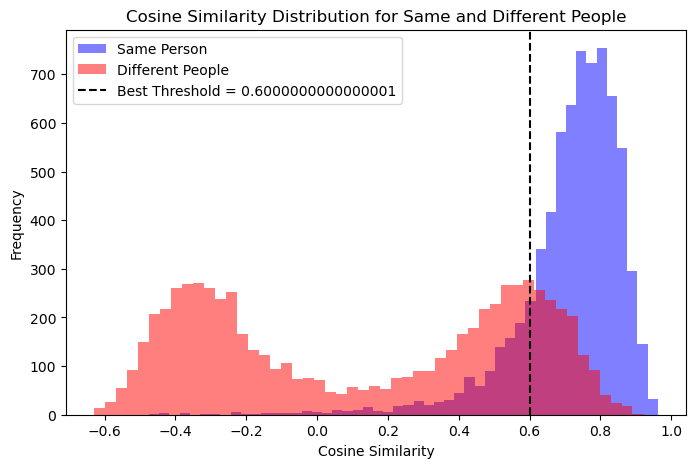

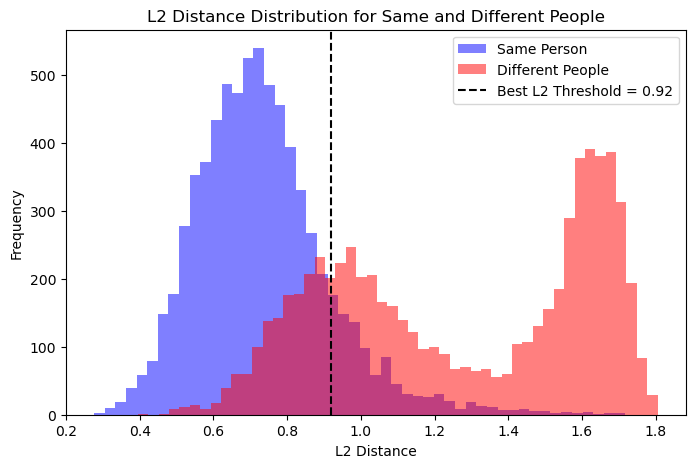

2025-04-05 08:13:49,844 - INFO - VGG Accuracy after Epoch 21: 0.8270


Best Cosine Threshold: 0.6000000000000001, Accuracy: 0.8270
Best L2 Threshold: 0.9201403260231018, Accuracy: 0.8257


Training epoch 21:: 100%|██████████| 3833/3833 [19:06<00:00,  3.34it/s]
2025-04-05 08:32:56,091 - INFO - Epoch 22/30, Loss: 0.0700, Time for Epoch: 1146.20s, Time since start: 29555.34s
Validating:: 100%|██████████| 13964/13964 [03:03<00:00, 76.30it/s]


Min cos_sim: -0.72900390625, Max cos_sim: 0.962890625
Mean cos_sim: 0.407958984375
Min L2 distance: 0.272705078125, Max L2 distance: 1.859375
Mean L2 distance: 1.0107421875


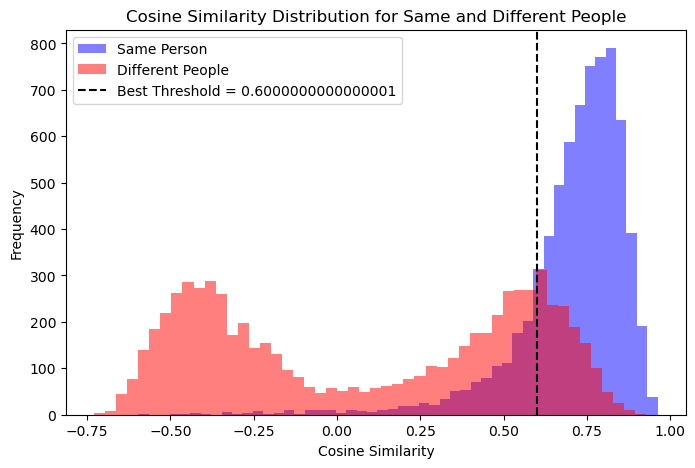

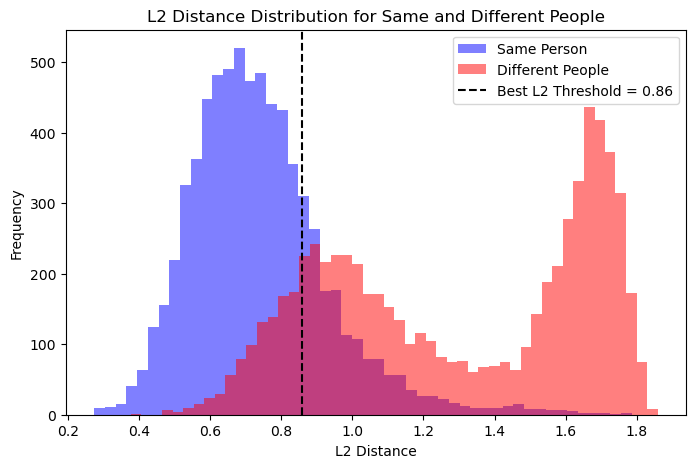

2025-04-05 08:35:59,522 - INFO - VGG Accuracy after Epoch 22: 0.8223


Best Cosine Threshold: 0.6000000000000001, Accuracy: 0.8223
Best L2 Threshold: 0.8572676777839661, Accuracy: 0.8191


Training epoch 22:: 100%|██████████| 3833/3833 [19:08<00:00,  3.34it/s]
2025-04-05 08:55:08,383 - INFO - Epoch 23/30, Loss: 0.0640, Time for Epoch: 1148.80s, Time since start: 30887.64s
Validating:: 100%|██████████| 13964/13964 [03:03<00:00, 76.22it/s]


Min cos_sim: -0.74169921875, Max cos_sim: 0.9765625
Mean cos_sim: 0.459228515625
Min L2 distance: 0.2166748046875, Max L2 distance: 1.8662109375
Mean L2 distance: 0.93701171875


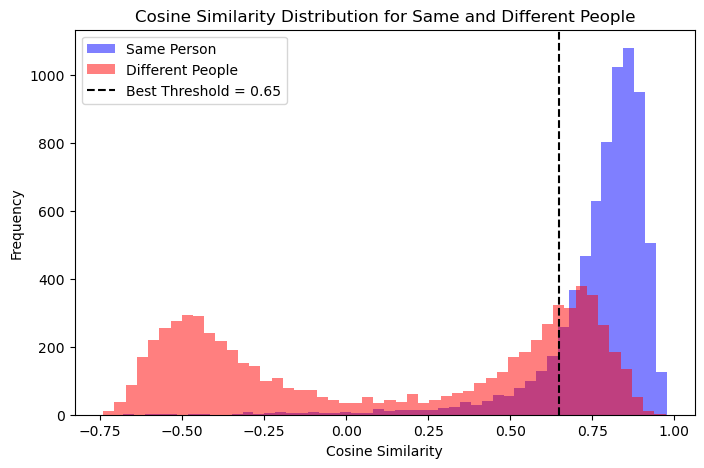

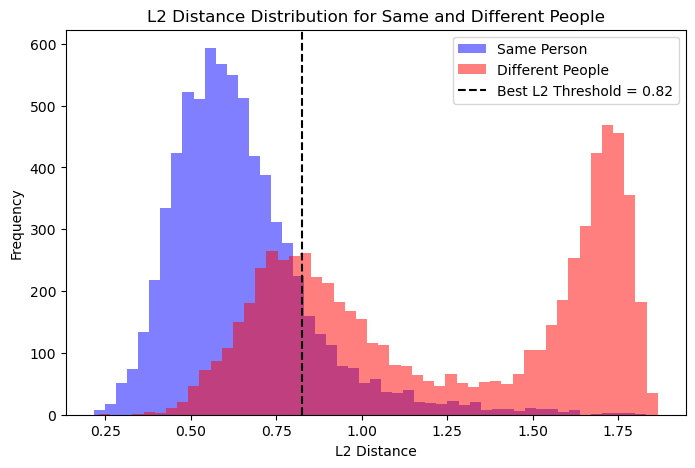

2025-04-05 08:58:12,061 - INFO - VGG Accuracy after Epoch 23: 0.8020


Best Cosine Threshold: 0.65, Accuracy: 0.8020
Best L2 Threshold: 0.8243986368179321, Accuracy: 0.8023


Training epoch 23:: 100%|██████████| 3833/3833 [19:23<00:00,  3.30it/s]
2025-04-05 09:17:35,116 - INFO - Epoch 24/30, Loss: 0.0606, Time for Epoch: 1163.01s, Time since start: 32234.37s
Validating:: 100%|██████████| 13964/13964 [03:09<00:00, 73.84it/s]


Min cos_sim: -0.71875, Max cos_sim: 0.98046875
Mean cos_sim: 0.445068359375
Min L2 distance: 0.19921875, Max L2 distance: 1.853515625
Mean L2 distance: 0.96142578125


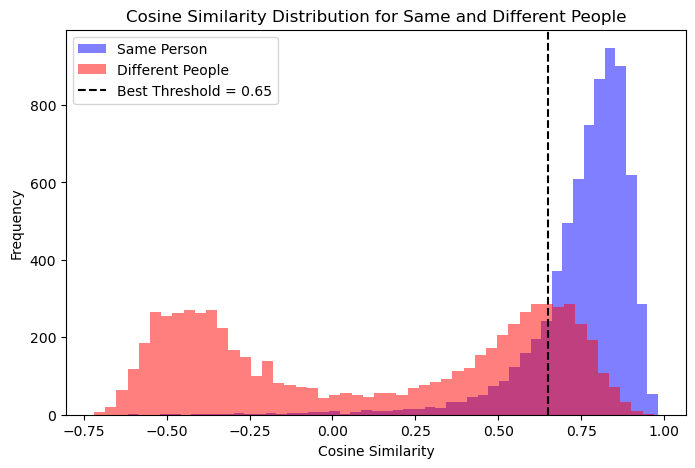

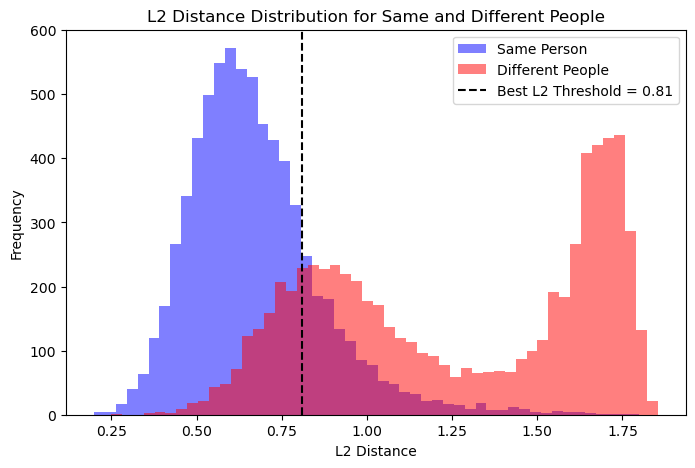

2025-04-05 09:20:44,727 - INFO - VGG Accuracy after Epoch 24: 0.8230


Best Cosine Threshold: 0.65, Accuracy: 0.8230
Best L2 Threshold: 0.8086965680122375, Accuracy: 0.8220


Training epoch 24:: 100%|██████████| 3833/3833 [19:14<00:00,  3.32it/s]
2025-04-05 09:39:59,333 - INFO - Epoch 25/30, Loss: 0.0603, Time for Epoch: 1154.56s, Time since start: 33578.59s
Validating:: 100%|██████████| 13964/13964 [03:07<00:00, 74.42it/s]


Min cos_sim: -0.734375, Max cos_sim: 0.9833984375
Mean cos_sim: 0.460205078125
Min L2 distance: 0.1846923828125, Max L2 distance: 1.8623046875
Mean L2 distance: 0.9375


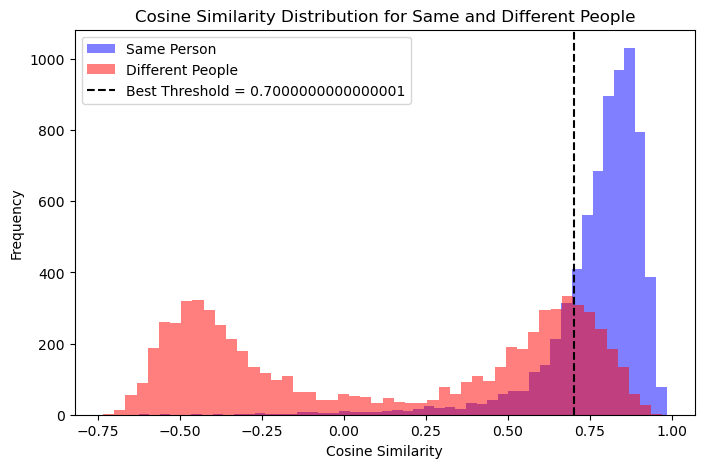

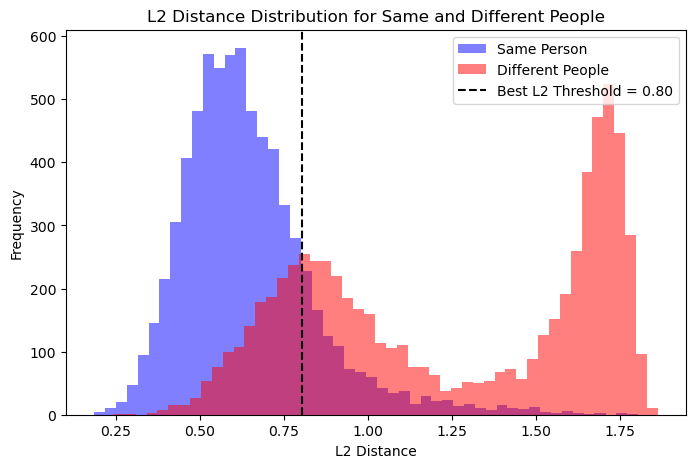

2025-04-05 09:43:07,428 - INFO - VGG Accuracy after Epoch 25: 0.8146


Best Cosine Threshold: 0.7000000000000001, Accuracy: 0.8146
Best L2 Threshold: 0.8027600646018982, Accuracy: 0.8158


Training epoch 25:: 100%|██████████| 3833/3833 [19:45<00:00,  3.23it/s]
2025-04-05 10:02:53,020 - INFO - Epoch 26/30, Loss: 0.0590, Time for Epoch: 1185.54s, Time since start: 34952.27s
Validating:: 100%|██████████| 13964/13964 [03:10<00:00, 73.32it/s]


Min cos_sim: -0.73583984375, Max cos_sim: 0.98046875
Mean cos_sim: 0.469482421875
Min L2 distance: 0.201416015625, Max L2 distance: 1.86328125
Mean L2 distance: 0.9306640625


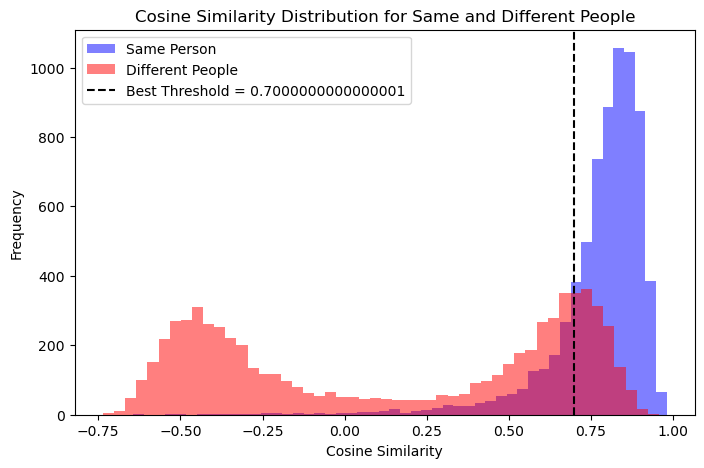

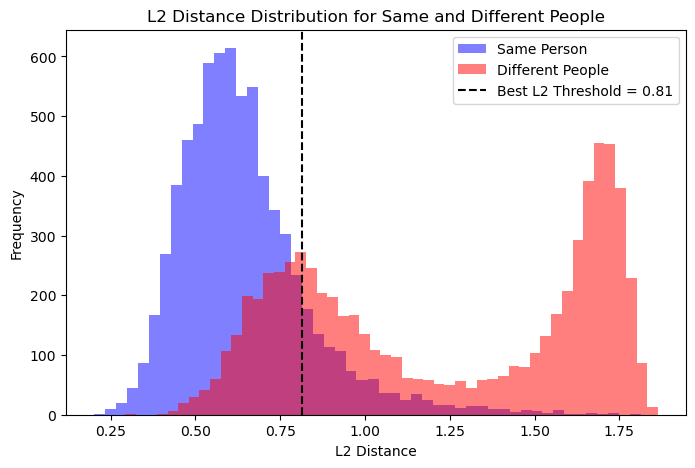

2025-04-05 10:06:03,983 - INFO - VGG Accuracy after Epoch 26: 0.8084


Best Cosine Threshold: 0.7000000000000001, Accuracy: 0.8084
Best L2 Threshold: 0.8136821389198303, Accuracy: 0.8060


Training epoch 26:: 100%|██████████| 3833/3833 [20:17<00:00,  3.15it/s]
2025-04-05 10:26:22,093 - INFO - Epoch 27/30, Loss: 0.0584, Time for Epoch: 1217.90s, Time since start: 36361.35s
Validating:: 100%|██████████| 13964/13964 [03:21<00:00, 69.15it/s]


Min cos_sim: -0.67138671875, Max cos_sim: 0.9658203125
Mean cos_sim: 0.457763671875
Min L2 distance: 0.263671875, Max L2 distance: 1.828125
Mean L2 distance: 0.962890625


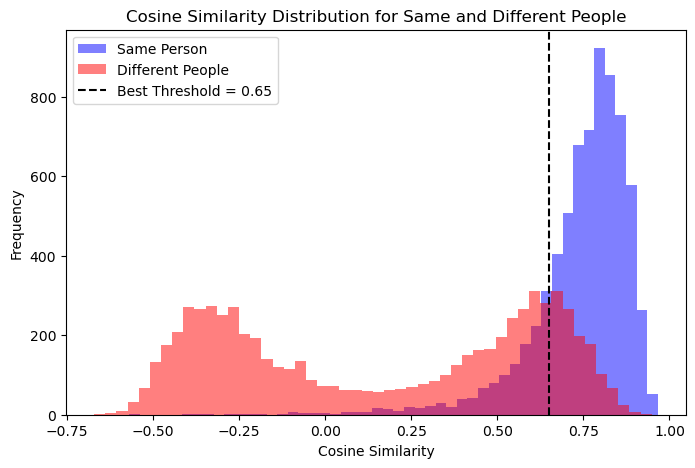

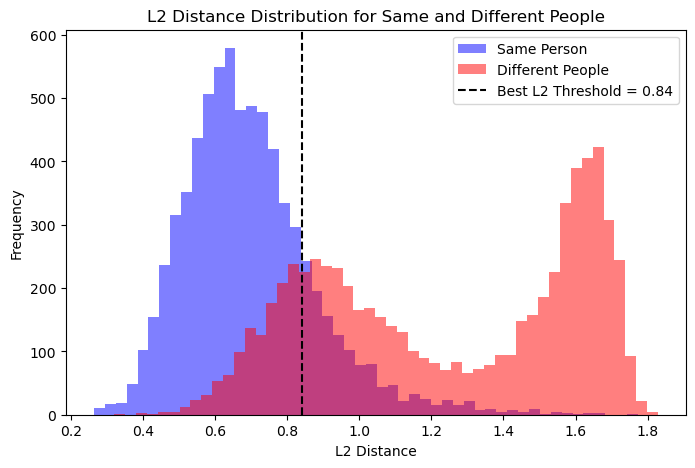

2025-04-05 10:29:44,719 - INFO - VGG Accuracy after Epoch 27: 0.8212


Best Cosine Threshold: 0.65, Accuracy: 0.8212
Best L2 Threshold: 0.8400493264198303, Accuracy: 0.8210


Training epoch 27:: 100%|██████████| 3833/3833 [19:28<00:00,  3.28it/s]
2025-04-05 10:49:13,575 - INFO - Epoch 28/30, Loss: 0.0538, Time for Epoch: 1168.81s, Time since start: 37732.83s
Validating:: 100%|██████████| 13964/13964 [03:14<00:00, 71.92it/s]


Min cos_sim: -0.6611328125, Max cos_sim: 0.97509765625
Mean cos_sim: 0.460693359375
Min L2 distance: 0.22412109375, Max L2 distance: 1.822265625
Mean L2 distance: 0.95556640625


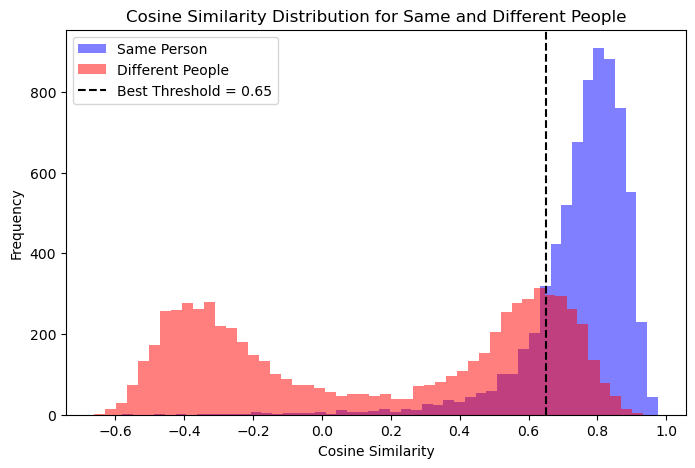

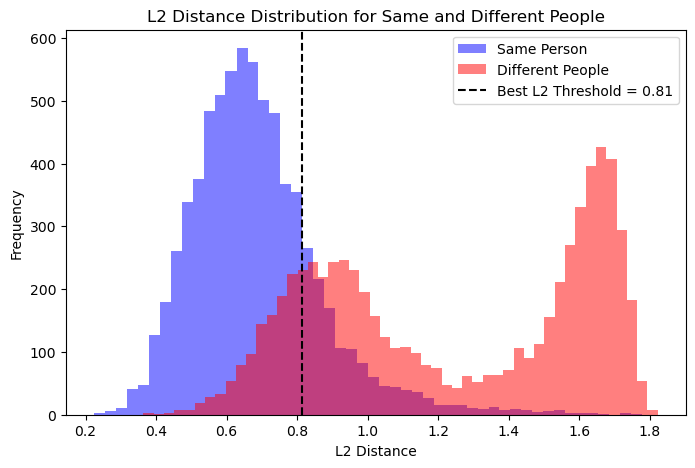

2025-04-05 10:52:28,213 - INFO - VGG Accuracy after Epoch 28: 0.8245


Best Cosine Threshold: 0.65, Accuracy: 0.8245
Best L2 Threshold: 0.8129111528396606, Accuracy: 0.8220


Training epoch 28:: 100%|██████████| 3833/3833 [19:19<00:00,  3.31it/s]
2025-04-05 11:11:47,554 - INFO - Epoch 29/30, Loss: 0.0534, Time for Epoch: 1159.29s, Time since start: 39086.81s
Validating:: 100%|██████████| 13964/13964 [03:10<00:00, 73.28it/s]


Min cos_sim: -0.55859375, Max cos_sim: 0.96435546875
Mean cos_sim: 0.46875
Min L2 distance: 0.269775390625, Max L2 distance: 1.765625
Mean L2 distance: 0.9619140625


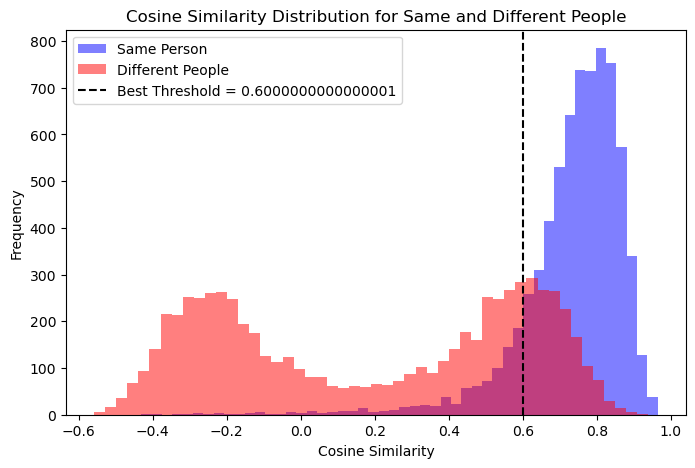

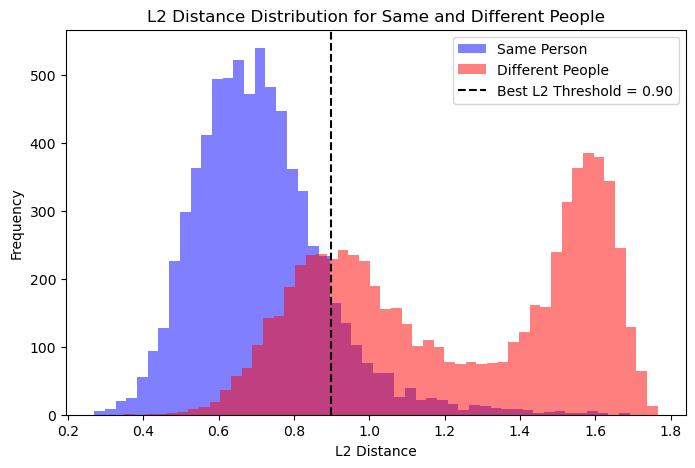

2025-04-05 11:14:58,624 - INFO - VGG Accuracy after Epoch 29: 0.8288


Best Cosine Threshold: 0.6000000000000001, Accuracy: 0.8288
Best L2 Threshold: 0.8996068239212036, Accuracy: 0.8286


Training epoch 29:: 100%|██████████| 3833/3833 [19:56<00:00,  3.20it/s]
2025-04-05 11:34:54,906 - INFO - Epoch 30/30, Loss: 0.0534, Time for Epoch: 1196.23s, Time since start: 40474.16s
Validating:: 100%|██████████| 13964/13964 [03:53<00:00, 59.72it/s]


Min cos_sim: -0.60009765625, Max cos_sim: 0.9677734375
Mean cos_sim: 0.46142578125
Min L2 distance: 0.25390625, Max L2 distance: 1.7890625
Mean L2 distance: 0.962890625


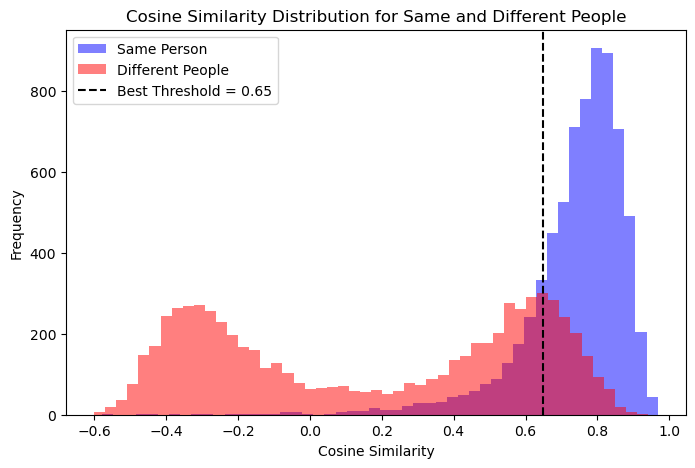

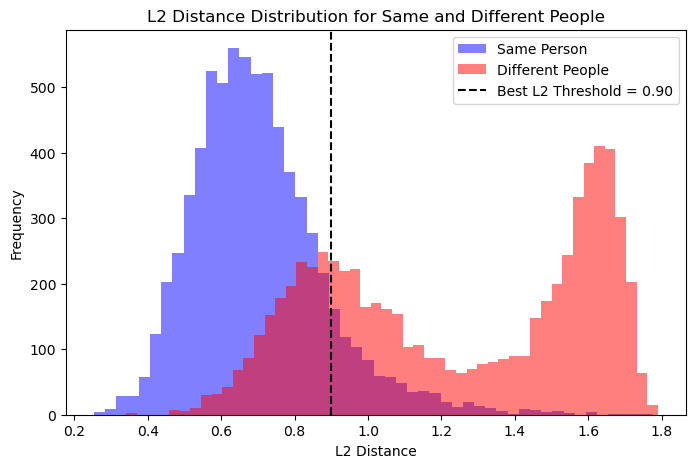

2025-04-05 11:38:49,152 - INFO - VGG Accuracy after Epoch 30: 0.8212


Best Cosine Threshold: 0.65, Accuracy: 0.8212
Best L2 Threshold: 0.9002878069877625, Accuracy: 0.8195


In [11]:
model = MobileFacenet()
criterion = nn.TripletMarginLoss(margin=2.0, p=2, eps=1e-7)
optimizer = optim.Adam(model.parameters(), lr=0.001)

loss, acc = mobile_face_net_train(model, criterion, optimizer, train_dataloader, valid_dataloader, num_epochs=30, device='cuda')

#### Валидация

In [ ]:
mobilefacenet_vgg_accuracy = debug_evaluate_vgg(model, valid_dataloader, device='cuda')

In [12]:
def visualization(num_epochs, train_losses, val_metrics):
    # Visualization
    epochs_range = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, val_metrics, label='LFW Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('LFW Accuracy Over Epochs')
    plt.legend()
    
    plt.show()

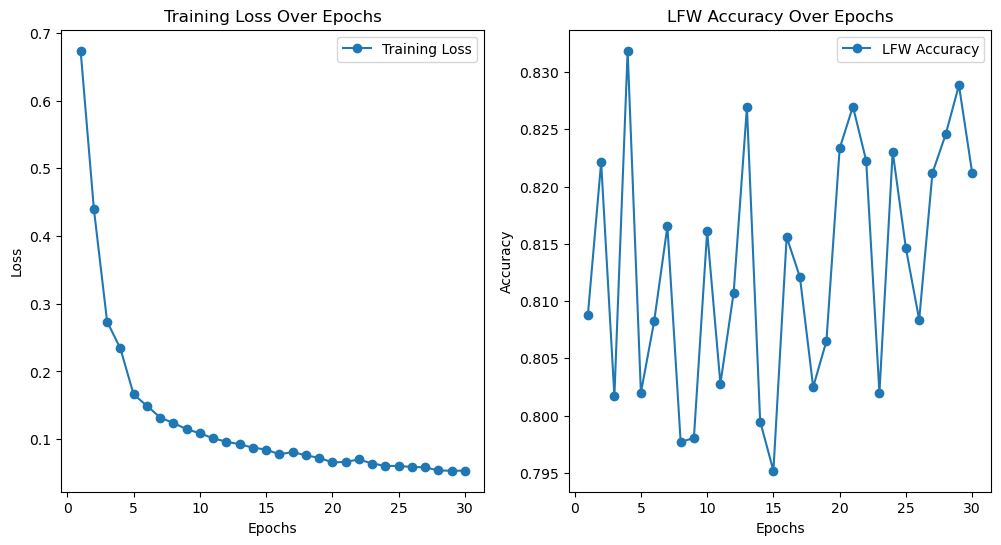

In [13]:
visualization(30, loss, acc)

Validating:: 100%|██████████| 13964/13964 [03:11<00:00, 73.10it/s]


Min cos_sim: -0.55810546875, Max cos_sim: 0.96337890625
Mean cos_sim: 0.46875
Min L2 distance: 0.269775390625, Max L2 distance: 1.765625
Mean L2 distance: 0.9619140625


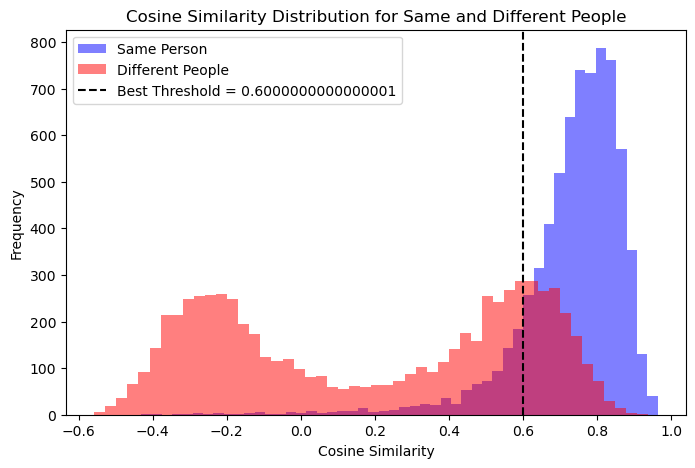

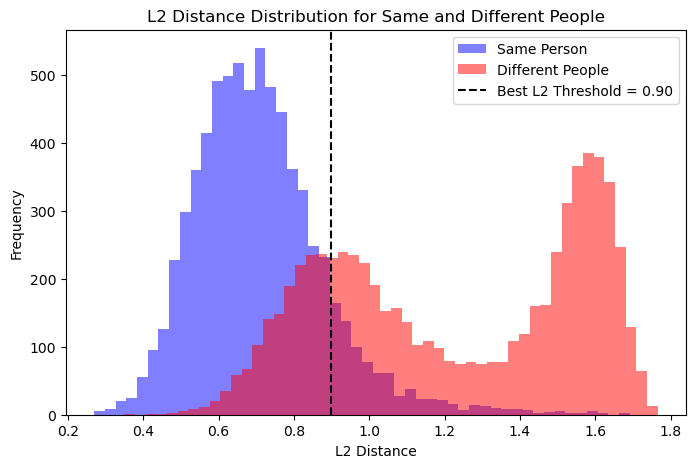

Best Cosine Threshold: 0.6000000000000001, Accuracy: 0.8288
Best L2 Threshold: 0.8996068239212036, Accuracy: 0.8284


In [12]:
best_mobile_net = MobileFacenet()

best_mobile_net.load_state_dict(torch.load('MobileFaceNet_28_epoch.pt'))

best_mobile_net.half()
best_mobile_net.eval()
best_mobile_net.to('cuda')

best_mobilefacenet_vgg_accuracy = debug_evaluate_vgg(best_mobile_net, valid_dataloader, device='cuda')

### GhostFaceNet

In [13]:
def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def hard_sigmoid(x, inplace: bool = False):
    if inplace:
        return x.add_(3.).clamp_(0., 6.).div_(6.)
    else:
        return F.relu6(x + 3.) / 6.


class SqueezeExcite(nn.Module):
    def __init__(self, in_chs, se_ratio=0.25, reduced_base_chs=None,
                 act_layer=nn.PReLU, gate_fn=hard_sigmoid, divisor=4, **_):
        super(SqueezeExcite, self).__init__()
        self.gate_fn = gate_fn
        reduced_chs = _make_divisible((reduced_base_chs or in_chs) * se_ratio, divisor)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv_reduce = nn.Conv2d(in_chs, reduced_chs, 1, bias=True)
        self.act1 = act_layer()
        self.conv_expand = nn.Conv2d(reduced_chs, in_chs, 1, bias=True)

    def forward(self, x):
        x_se = self.avg_pool(x)
        x_se = self.conv_reduce(x_se)
        x_se = self.act1(x_se)
        x_se = self.conv_expand(x_se)
        x = x * self.gate_fn(x_se)
        return x    

    
class ConvBnAct(nn.Module):
    def __init__(self, in_chs, out_chs, kernel_size,
                 stride=1, act_layer=nn.PReLU):
        super(ConvBnAct, self).__init__()
        self.conv = nn.Conv2d(in_chs, out_chs, kernel_size, stride, kernel_size//2, bias=False)
        self.bn1 = nn.BatchNorm2d(out_chs)
        self.act1 = act_layer()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn1(x)
        x = self.act1(x)
        return x

class ModifiedGDC(nn.Module):
    def __init__(self, image_size, in_chs, num_classes, dropout, emb=512): # dropout implementation is in the original code but not in the paper
        super(ModifiedGDC, self).__init__()
        
        if image_size % 32 == 0:
            self.conv_dw = nn.Conv2d(in_chs, in_chs, kernel_size=(image_size//32), groups=in_chs, bias=False)
        else:
            self.conv_dw = nn.Conv2d(in_chs, in_chs, kernel_size=(image_size//32 + 1), groups=in_chs, bias=False)
        self.bn1 = nn.BatchNorm2d(in_chs)
        self.dropout = nn.Dropout(dropout)
        self.conv = nn.Conv2d(in_chs, emb, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm1d(emb)
        self.linear = nn.Linear(emb, num_classes) if num_classes else nn.Identity()

    def forward(self, x):
        x = self.conv_dw(x)
        x = self.bn1(x)
        x = self.dropout(x)
        x = self.conv(x)
        x = x.view(x.size(0), -1) # Flatten
        x = self.bn2(x)
        x = self.linear(x)
        return x


class GhostModule(nn.Module):
    def __init__(self, inp, oup, kernel_size=1, ratio=2, dw_size=3, stride=1, prelu=True):
        super(GhostModule, self).__init__()
        self.oup = oup
        init_channels = math.ceil(oup / ratio)
        new_channels = init_channels*(ratio-1)

        self.primary_conv = nn.Sequential(
            nn.Conv2d(inp, init_channels, kernel_size, stride, kernel_size//2, bias=False),
            nn.BatchNorm2d(init_channels),
            nn.PReLU() if prelu else nn.Sequential(),
        )

        self.cheap_operation = nn.Sequential(
            nn.Conv2d(init_channels, new_channels, dw_size, 1, dw_size//2, groups=init_channels, bias=False),
            nn.BatchNorm2d(new_channels),
            nn.PReLU() if prelu else nn.Sequential(),
        )

    def forward(self, x):
        x1 = self.primary_conv(x)
        x2 = self.cheap_operation(x1)
        out = torch.cat([x1,x2], dim=1)
        return out[:,:self.oup,:,:]


class GhostBottleneck(nn.Module):
    """ Ghost bottleneck w/ optional SE"""

    def __init__(self, in_chs, mid_chs, out_chs, dw_kernel_size=3,
                 stride=1, act_layer=nn.PReLU, se_ratio=0.):
        super(GhostBottleneck, self).__init__()
        has_se = se_ratio is not None and se_ratio > 0.
        self.stride = stride

        # Point-wise expansion
        self.ghost1 = GhostModule(in_chs, mid_chs, prelu=True)

        # Depth-wise convolution
        if self.stride > 1:
            self.conv_dw = nn.Conv2d(mid_chs, mid_chs, dw_kernel_size, stride=stride,
                             padding=(dw_kernel_size-1)//2,
                             groups=mid_chs, bias=False)
            self.bn_dw = nn.BatchNorm2d(mid_chs)

        # Squeeze-and-excitation
        if has_se:
            self.se = SqueezeExcite(mid_chs, se_ratio=se_ratio)
        else:
            self.se = None

        # Point-wise linear projection
        self.ghost2 = GhostModule(mid_chs, out_chs, prelu=False)
        
        # shortcut
        if (in_chs == out_chs and self.stride == 1):
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_chs, in_chs, dw_kernel_size, stride=stride,
                       padding=(dw_kernel_size-1)//2, groups=in_chs, bias=False),
                nn.BatchNorm2d(in_chs),
                nn.Conv2d(in_chs, out_chs, 1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(out_chs),
            )


    def forward(self, x):
        residual = x

        # 1st ghost bottleneck
        x = self.ghost1(x)

        # Depth-wise convolution
        if self.stride > 1:
            x = self.conv_dw(x)
            x = self.bn_dw(x)

        # Squeeze-and-excitation
        if self.se is not None:
            x = self.se(x)

        # 2nd ghost bottleneck
        x = self.ghost2(x)
        
        x += self.shortcut(residual)
        return x

class GhostFaceNetsV1(nn.Module):
    def __init__(self, cfgs=None, image_size=256, num_classes=0, width=1.0, dropout=0.2,
                 add_pointwise_conv=False, bn_momentum=0.9, bn_epsilon=1e-5, init_kaiming=True):
        super(GhostFaceNetsV1, self).__init__()
        # setting of inverted residual blocks
        if cfgs==None:
            self.cfgs = [
                # k, t, c, SE, s 
                # stage1
                [[3,  16,  16, 0, 1]],
                # stage2
                [[3,  48,  24, 0, 2]],
                [[3,  72,  24, 0, 1]],
                # stage3
                [[5,  72,  40, 0.25, 2]],
                [[5, 120,  40, 0.25, 1]],
                # stage4
                [[3, 240,  80, 0, 2]],
                [[3, 200,  80, 0, 1],
                [3, 184,  80, 0, 1],
                [3, 184,  80, 0, 1],
                [3, 480, 112, 0.25, 1],
                [3, 672, 112, 0.25, 1]
                ],
                # stage5
                [[5, 672, 160, 0.25, 2]],
                [[5, 960, 160, 0, 1],
                [5, 960, 160, 0.25, 1],
                [5, 960, 160, 0, 1],
                [5, 960, 160, 0.25, 1]
                ]
            ]
        else:
            self.cfgs=cfgs

        self.dropout = dropout

        # building first layer
        output_channel = _make_divisible(16 * width, 4)
        self.conv_stem = nn.Conv2d(3, output_channel, 3, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(output_channel)
        self.act1 = nn.PReLU()
        input_channel = output_channel

        # building inverted residual blocks
        stages = []
        block = GhostBottleneck
        for cfg in self.cfgs:
            layers = []
            for k, exp_size, c, se_ratio, s in cfg:
                output_channel = _make_divisible(c * width, 4)
                hidden_channel = _make_divisible(exp_size * width, 4)
                layers.append(block(input_channel, hidden_channel, output_channel, k, s,
                              se_ratio=se_ratio))
                input_channel = output_channel
            stages.append(nn.Sequential(*layers))

        output_channel = _make_divisible(exp_size * width, 4)
        stages.append(nn.Sequential(ConvBnAct(input_channel, output_channel, 1)))
        
        self.blocks = nn.Sequential(*stages)        

        # building last several layers
        pointwise_conv = []
        if add_pointwise_conv:
            pointwise_conv.append(nn.Conv2d(input_channel, output_channel, 1, 1, 0, bias=True))
            pointwise_conv.append(nn.BatchNorm2d(output_channel))
            pointwise_conv.append(nn.PReLU())
        else:
            pointwise_conv.append(nn.Sequential())

        self.pointwise_conv = nn.Sequential(*pointwise_conv)
        self.classifier = ModifiedGDC(image_size, output_channel, num_classes, dropout)

        # Initialize weights
        for m in self.modules():
            if init_kaiming:
                if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
                    negative_slope = 0.25  # Default value for PReLU in PyTorch, change it if you use custom value
                    m.weight.data.normal_(0, math.sqrt(2. / (fan_in * (1 + negative_slope ** 2))))
            if isinstance(m, nn.BatchNorm2d):
                m.momentum, m.eps = bn_momentum, bn_epsilon

    def forward(self, x):
        x = self.conv_stem(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.blocks(x)
        x = self.pointwise_conv(x)
        x = self.classifier(x)
        return x

#### Цикл обучения

In [ ]:
def ghost_face_net_train(model, criterion, optimizer, train_loader, val_loader, num_epochs=10, device='cuda'):
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    model.to(device)
    scaler = torch.amp.GradScaler()
    train_losses = []
    val_acc = []
    full_time = time.time()
    
    for epoch in range(num_epochs):
        model.train()
        start_time = time.time()
        train_loss = 0

        for anchor, positive, negative in tqdm(train_loader, desc=f'Training epoch {epoch}:'):
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            optimizer.zero_grad()

            with torch.amp.autocast('cuda'):
                anchor_embed = model(anchor)
                positive_embed = model(positive)
                negative_embed = model(negative)

                loss = criterion(anchor_embed, positive_embed, negative_embed)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        logging.info(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss:.4f}, Time for Epoch: {time.time() - start_time:.2f}s, Time since start: {time.time() - full_time:.2f}s")
        
        vgg_accuracy = debug_evaluate_vgg(model, val_loader, device='cuda')
        val_acc.append(vgg_accuracy)
        logging.info(f"VGG Accuracy after Epoch {epoch+1}: {vgg_accuracy:.4f}")
        torch.save(model.state_dict(), f'GhostFaceNet_{epoch}_epoch.pt')

    return train_losses, val_acc


Training epoch 0:: 100%|██████████| 3833/3833 [23:16<00:00,  2.74it/s]
2025-04-05 12:10:33,230 - INFO - Epoch 1/30, Loss: 0.5607, Time for Epoch: 1396.97s, Time since start: 1396.97s
Validating:: 100%|██████████| 13964/13964 [06:43<00:00, 34.65it/s]


Min cos_sim: -0.59423828125, Max cos_sim: 0.90283203125
Mean cos_sim: 0.2296142578125
Min L2 distance: 0.44140625, Max L2 distance: 1.7861328125
Mean L2 distance: 1.2138671875


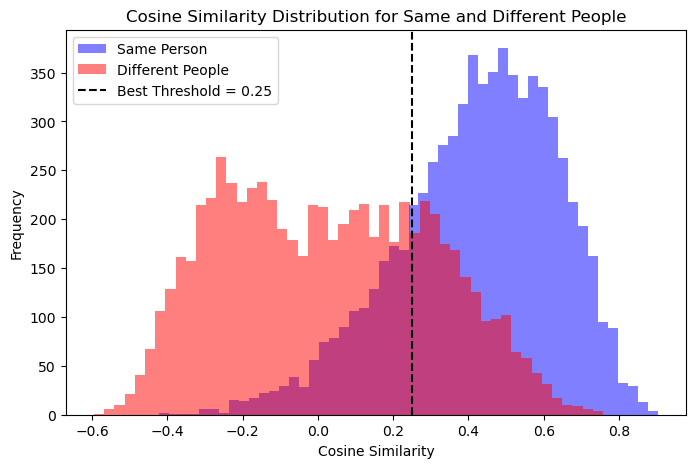

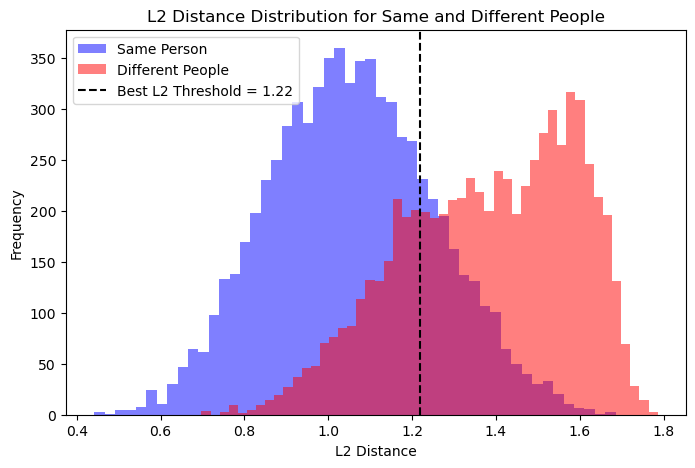

2025-04-05 12:17:16,714 - INFO - VGG Accuracy after Epoch 1: 0.7747


Best Cosine Threshold: 0.25, Accuracy: 0.7747
Best L2 Threshold: 1.2199320793151855, Accuracy: 0.7743


Training epoch 1:: 100%|██████████| 3833/3833 [19:38<00:00,  3.25it/s]
2025-04-05 12:36:54,811 - INFO - Epoch 2/30, Loss: 0.2752, Time for Epoch: 1178.03s, Time since start: 2978.55s
Validating:: 100%|██████████| 13964/13964 [06:23<00:00, 36.45it/s]


Min cos_sim: -0.59814453125, Max cos_sim: 0.951171875
Mean cos_sim: 0.383056640625
Min L2 distance: 0.313720703125, Max L2 distance: 1.7880859375
Mean L2 distance: 1.0595703125


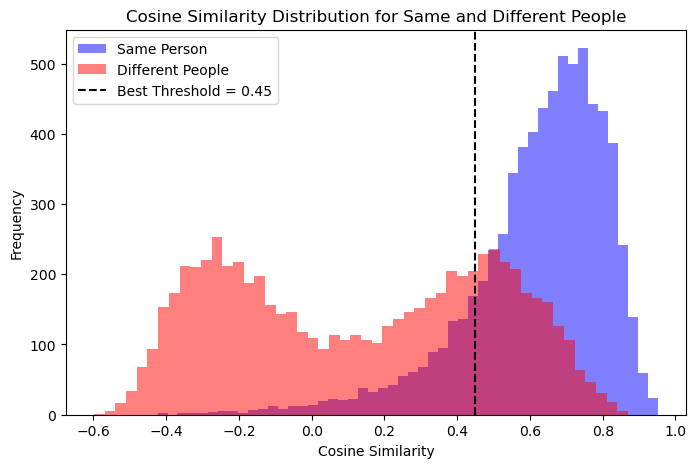

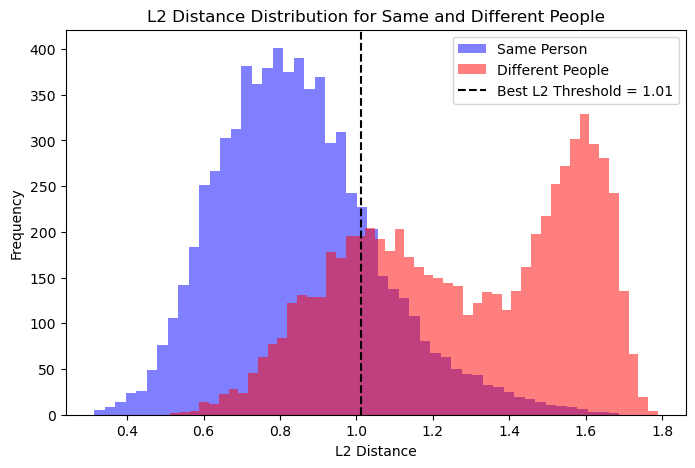

2025-04-05 12:43:18,323 - INFO - VGG Accuracy after Epoch 2: 0.7895


Best Cosine Threshold: 0.45, Accuracy: 0.7895
Best L2 Threshold: 1.0121042728424072, Accuracy: 0.7901


Training epoch 2:: 100%|██████████| 3833/3833 [19:37<00:00,  3.25it/s]
2025-04-05 13:02:56,401 - INFO - Epoch 3/30, Loss: 0.1644, Time for Epoch: 1177.99s, Time since start: 4540.14s
Validating:: 100%|██████████| 13964/13964 [06:25<00:00, 36.25it/s]


Min cos_sim: -0.4599609375, Max cos_sim: 0.98046875
Mean cos_sim: 0.47021484375
Min L2 distance: 0.197021484375, Max L2 distance: 1.708984375
Mean L2 distance: 0.97265625


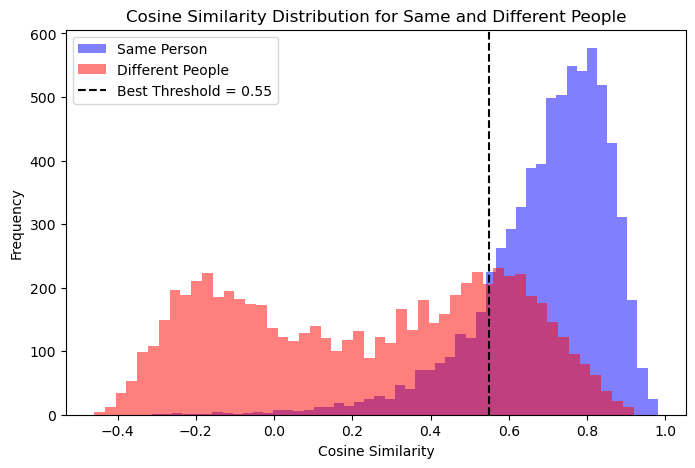

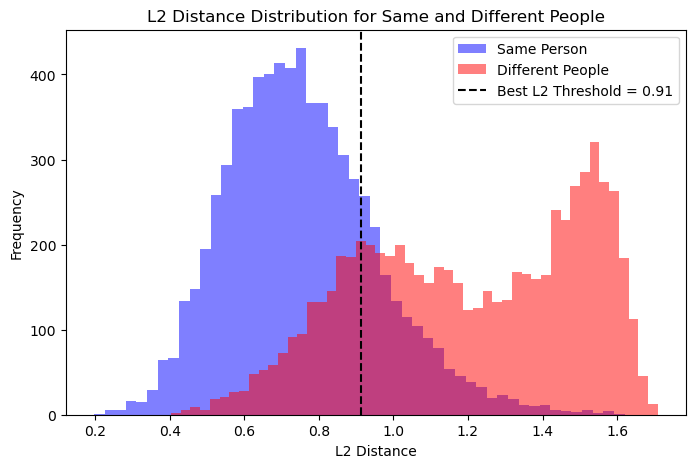

2025-04-05 13:09:22,035 - INFO - VGG Accuracy after Epoch 3: 0.7996


Best Cosine Threshold: 0.55, Accuracy: 0.7996
Best L2 Threshold: 0.913214385509491, Accuracy: 0.7973


Training epoch 3:: 100%|██████████| 3833/3833 [19:41<00:00,  3.24it/s]
2025-04-05 13:29:03,719 - INFO - Epoch 4/30, Loss: 0.1273, Time for Epoch: 1181.62s, Time since start: 6107.46s
Validating:: 100%|██████████| 13964/13964 [06:27<00:00, 36.07it/s]


Min cos_sim: -0.517578125, Max cos_sim: 0.98486328125
Mean cos_sim: 0.5400390625
Min L2 distance: 0.1766357421875, Max L2 distance: 1.7412109375
Mean L2 distance: 0.87841796875


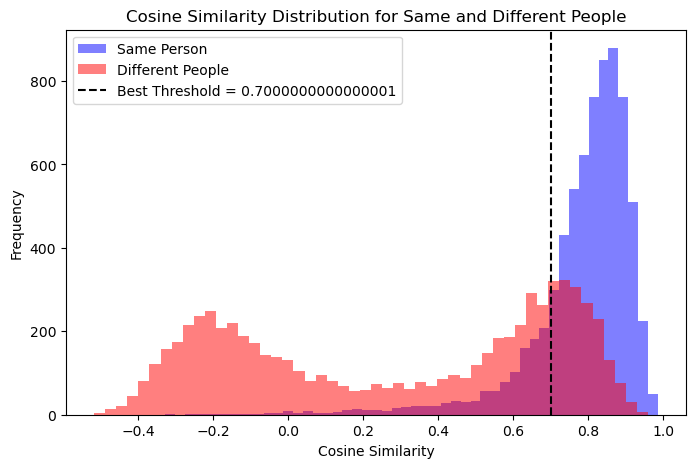

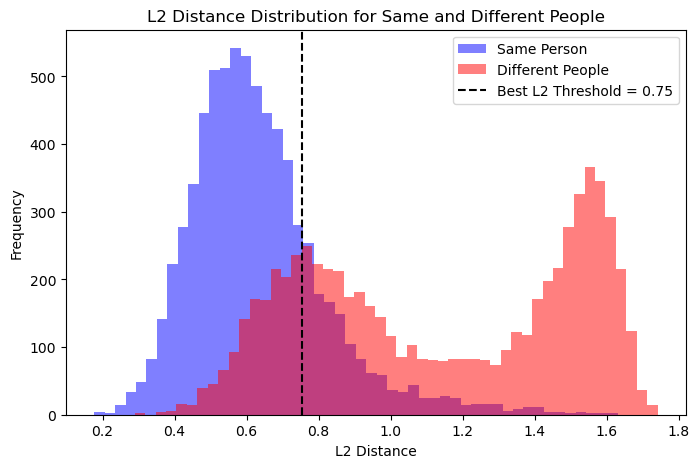

2025-04-05 13:35:31,476 - INFO - VGG Accuracy after Epoch 4: 0.7960


Best Cosine Threshold: 0.7000000000000001, Accuracy: 0.7960
Best L2 Threshold: 0.753058135509491, Accuracy: 0.7962


Training epoch 4:: 100%|██████████| 3833/3833 [19:42<00:00,  3.24it/s]
2025-04-05 13:55:13,559 - INFO - Epoch 5/30, Loss: 0.1100, Time for Epoch: 1182.01s, Time since start: 7677.30s
Validating:: 100%|██████████| 13964/13964 [06:24<00:00, 36.31it/s]


Min cos_sim: -0.28369140625, Max cos_sim: 0.97216796875
Mean cos_sim: 0.537109375
Min L2 distance: 0.2354736328125, Max L2 distance: 1.6015625
Mean L2 distance: 0.90869140625


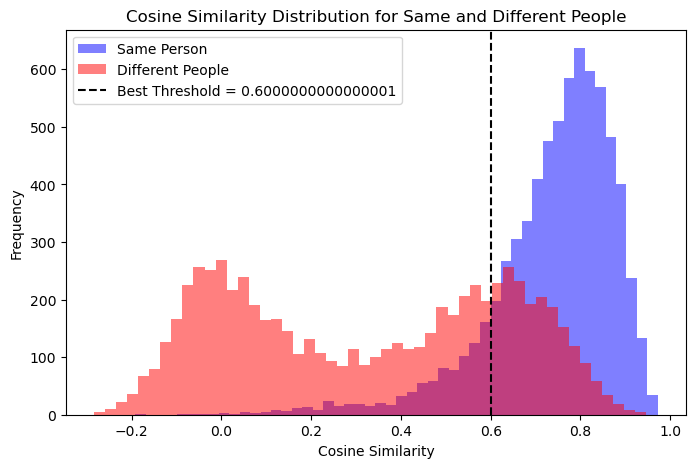

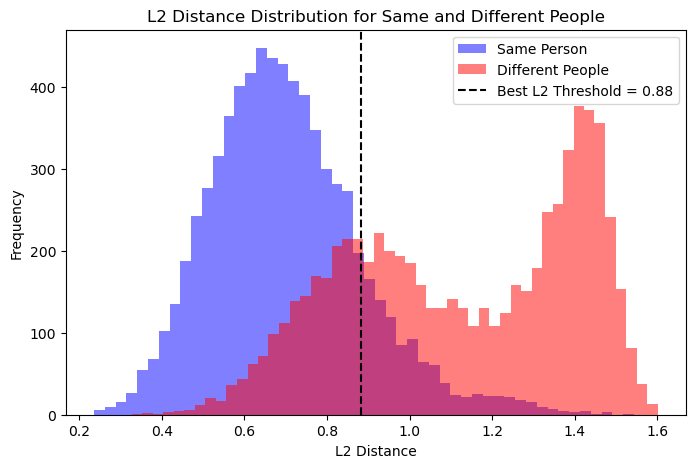

2025-04-05 14:01:38,547 - INFO - VGG Accuracy after Epoch 5: 0.8043


Best Cosine Threshold: 0.6000000000000001, Accuracy: 0.8043
Best L2 Threshold: 0.882568359375, Accuracy: 0.8039


Training epoch 5:: 100%|██████████| 3833/3833 [19:45<00:00,  3.23it/s]
2025-04-05 14:21:24,272 - INFO - Epoch 6/30, Loss: 0.0973, Time for Epoch: 1185.65s, Time since start: 9248.01s
Validating:: 100%|██████████| 13964/13964 [06:28<00:00, 35.90it/s]


Min cos_sim: -0.11285400390625, Max cos_sim: 0.98291015625
Mean cos_sim: 0.626953125
Min L2 distance: 0.1827392578125, Max L2 distance: 1.4912109375
Mean L2 distance: 0.8115234375


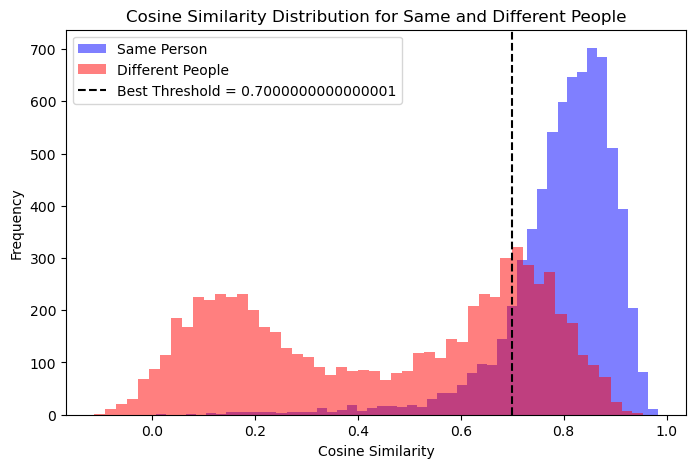

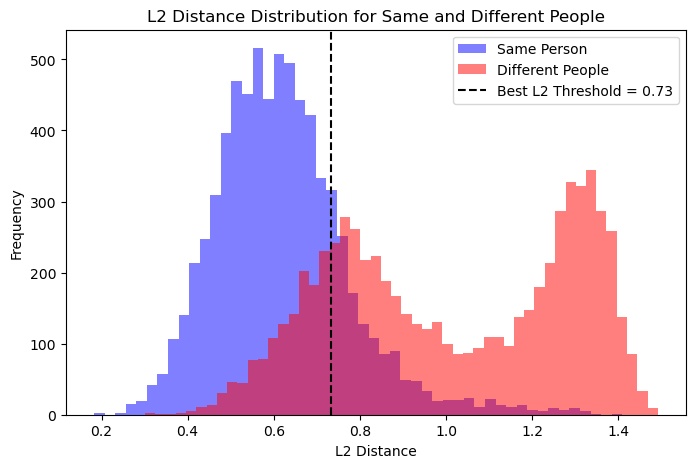

2025-04-05 14:27:53,755 - INFO - VGG Accuracy after Epoch 6: 0.8085


Best Cosine Threshold: 0.7000000000000001, Accuracy: 0.8085
Best L2 Threshold: 0.7336747050285339, Accuracy: 0.8089


Training epoch 6:: 100%|██████████| 3833/3833 [20:36<00:00,  3.10it/s]
2025-04-05 14:48:29,908 - INFO - Epoch 7/30, Loss: 0.0843, Time for Epoch: 1236.08s, Time since start: 10873.65s
Validating:: 100%|██████████| 13964/13964 [06:36<00:00, 35.20it/s]


Min cos_sim: -0.007595062255859375, Max cos_sim: 0.96435546875
Mean cos_sim: 0.57666015625
Min L2 distance: 0.267822265625, Max L2 distance: 1.419921875
Mean L2 distance: 0.89453125


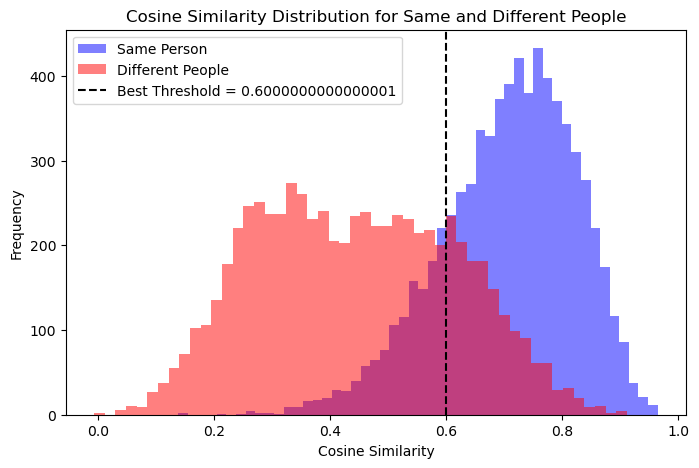

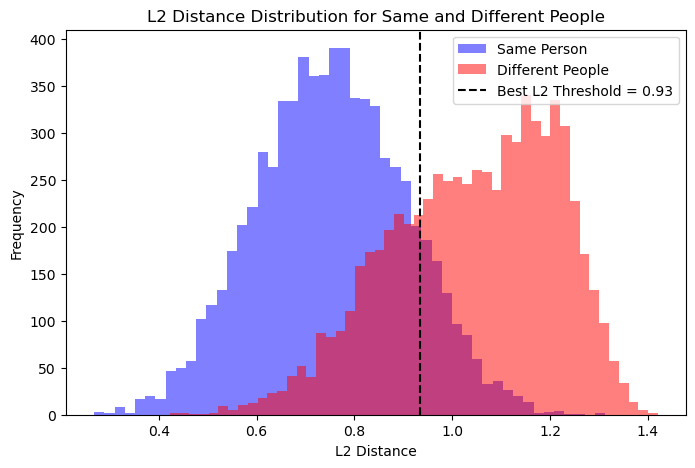

2025-04-05 14:55:07,189 - INFO - VGG Accuracy after Epoch 7: 0.8013


Best Cosine Threshold: 0.6000000000000001, Accuracy: 0.8013
Best L2 Threshold: 0.9348273277282715, Accuracy: 0.8021


Training epoch 7:: 100%|██████████| 3833/3833 [19:46<00:00,  3.23it/s]
2025-04-05 15:14:53,953 - INFO - Epoch 8/30, Loss: 0.0826, Time for Epoch: 1186.68s, Time since start: 12457.69s
Validating:: 100%|██████████| 13964/13964 [06:26<00:00, 36.13it/s]


Min cos_sim: -0.09478759765625, Max cos_sim: 0.97412109375
Mean cos_sim: 0.6259765625
Min L2 distance: 0.2293701171875, Max L2 distance: 1.4794921875
Mean L2 distance: 0.81640625


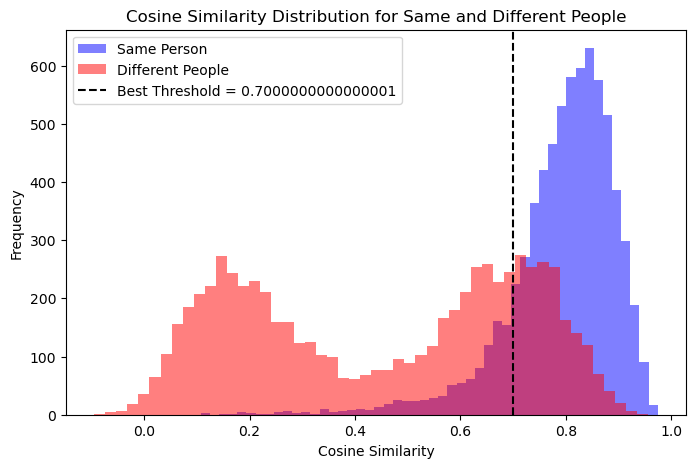

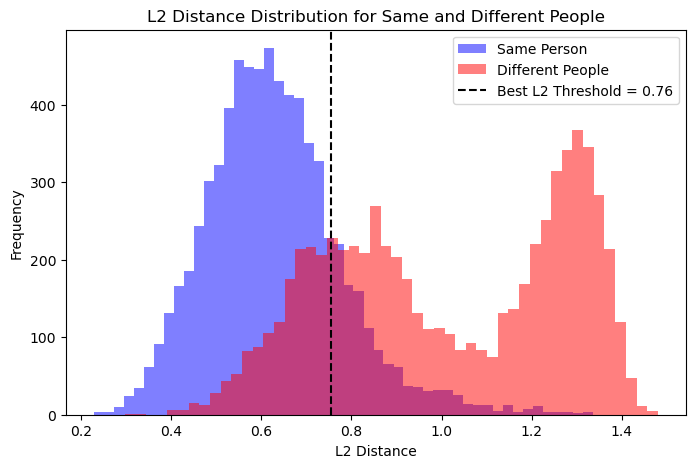

2025-04-05 15:21:20,863 - INFO - VGG Accuracy after Epoch 8: 0.8100


Best Cosine Threshold: 0.7000000000000001, Accuracy: 0.8100
Best L2 Threshold: 0.7557373046875, Accuracy: 0.8099


Training epoch 8:: 100%|██████████| 3833/3833 [19:42<00:00,  3.24it/s]
2025-04-05 15:41:03,477 - INFO - Epoch 9/30, Loss: 0.0743, Time for Epoch: 1182.54s, Time since start: 14027.22s
Validating:: 100%|██████████| 13964/13964 [06:24<00:00, 36.30it/s]


Min cos_sim: -0.1646728515625, Max cos_sim: 0.97705078125
Mean cos_sim: 0.619140625
Min L2 distance: 0.21435546875, Max L2 distance: 1.525390625
Mean L2 distance: 0.8212890625


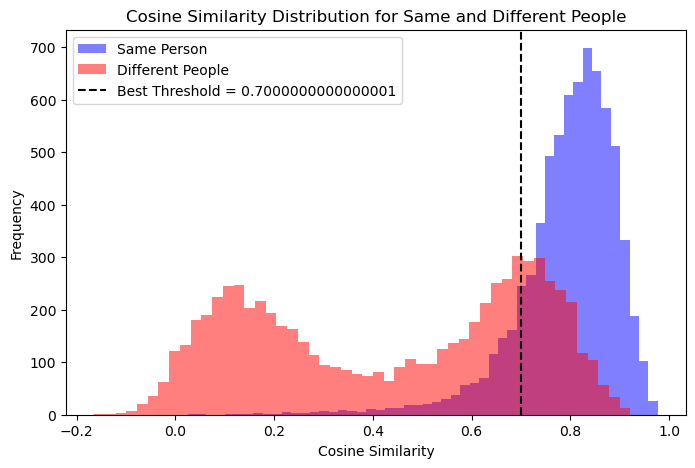

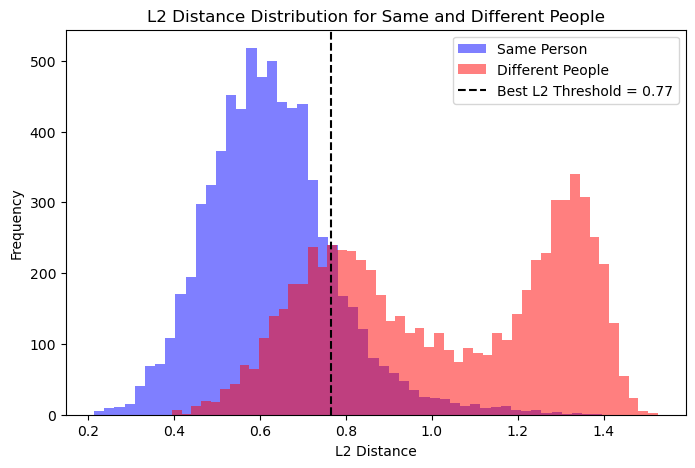

2025-04-05 15:47:28,614 - INFO - VGG Accuracy after Epoch 9: 0.8099


Best Cosine Threshold: 0.7000000000000001, Accuracy: 0.8099
Best L2 Threshold: 0.7663702964782715, Accuracy: 0.8102


Training epoch 9:: 100%|██████████| 3833/3833 [20:29<00:00,  3.12it/s]
2025-04-05 16:07:57,840 - INFO - Epoch 10/30, Loss: 0.0713, Time for Epoch: 1229.16s, Time since start: 15641.58s
Validating:: 100%|██████████| 13964/13964 [06:35<00:00, 35.28it/s]


Min cos_sim: 0.057769775390625, Max cos_sim: 0.98388671875
Mean cos_sim: 0.69287109375
Min L2 distance: 0.181884765625, Max L2 distance: 1.373046875
Mean L2 distance: 0.73583984375


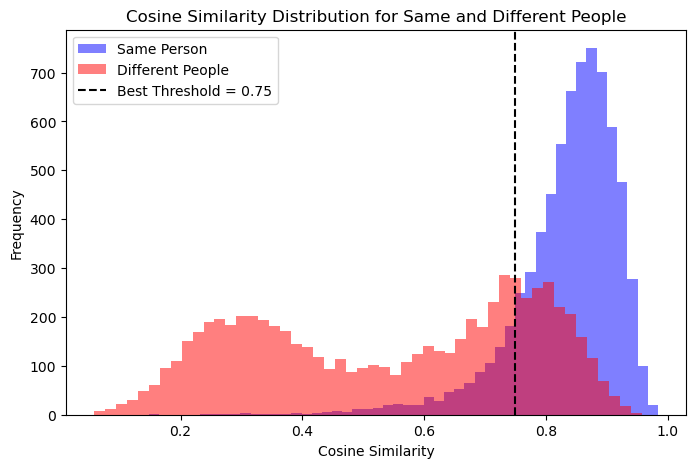

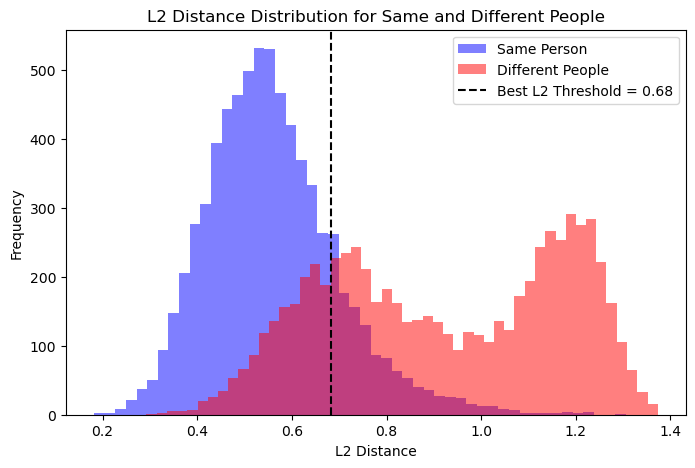

2025-04-05 16:14:34,103 - INFO - VGG Accuracy after Epoch 10: 0.8098


Best Cosine Threshold: 0.75, Accuracy: 0.8098
Best L2 Threshold: 0.6834266781806946, Accuracy: 0.8101


Training epoch 10:: 100%|██████████| 3833/3833 [20:02<00:00,  3.19it/s]
2025-04-05 16:34:36,543 - INFO - Epoch 11/30, Loss: 0.0670, Time for Epoch: 1202.36s, Time since start: 17240.28s
Validating:: 100%|██████████| 13964/13964 [06:25<00:00, 36.19it/s]


Min cos_sim: -0.150390625, Max cos_sim: 0.98876953125
Mean cos_sim: 0.65087890625
Min L2 distance: 0.1507568359375, Max L2 distance: 1.5166015625
Mean L2 distance: 0.77099609375


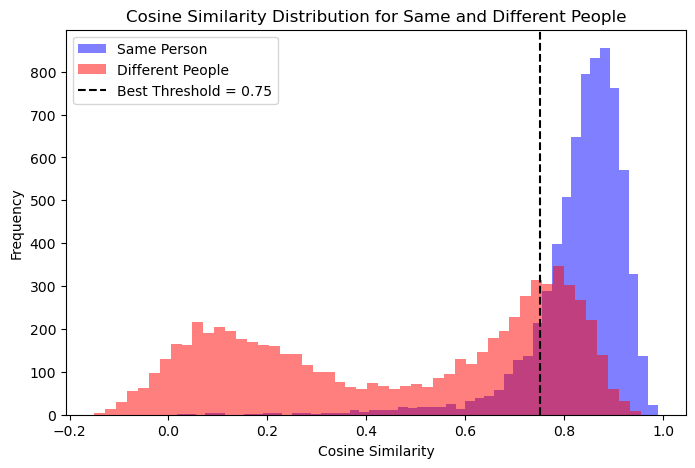

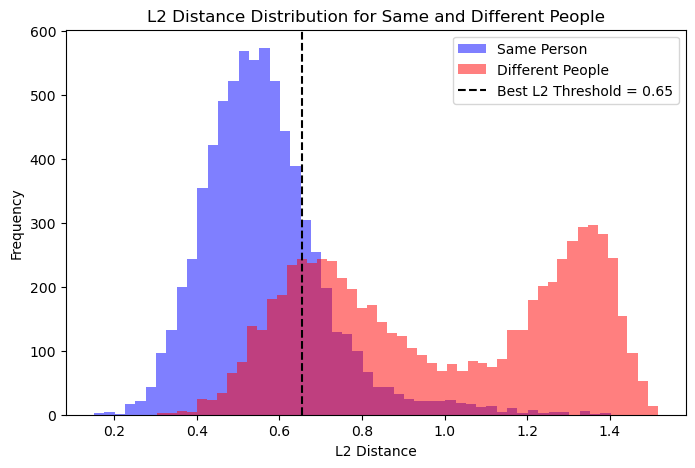

2025-04-05 16:41:02,868 - INFO - VGG Accuracy after Epoch 11: 0.8098


Best Cosine Threshold: 0.75, Accuracy: 0.8098
Best L2 Threshold: 0.6539627909660339, Accuracy: 0.8070


Training epoch 11:: 100%|██████████| 3833/3833 [19:55<00:00,  3.21it/s]
2025-04-05 17:00:58,346 - INFO - Epoch 12/30, Loss: 0.0637, Time for Epoch: 1195.41s, Time since start: 18822.09s
Validating:: 100%|██████████| 13964/13964 [06:27<00:00, 36.01it/s]


Min cos_sim: -0.0227203369140625, Max cos_sim: 0.98828125
Mean cos_sim: 0.66552734375
Min L2 distance: 0.154052734375, Max L2 distance: 1.4306640625
Mean L2 distance: 0.7666015625


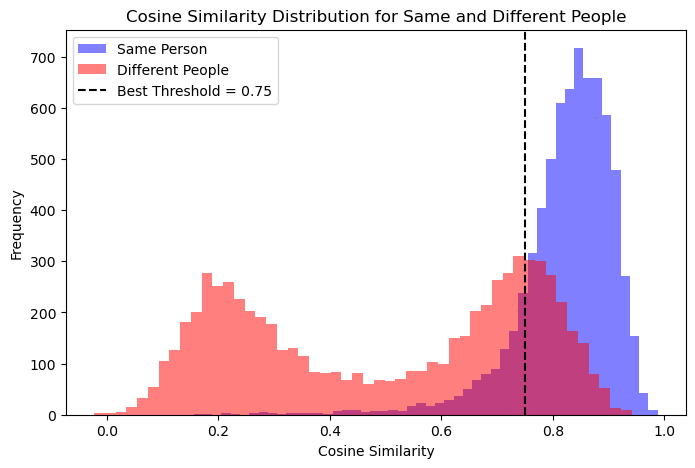

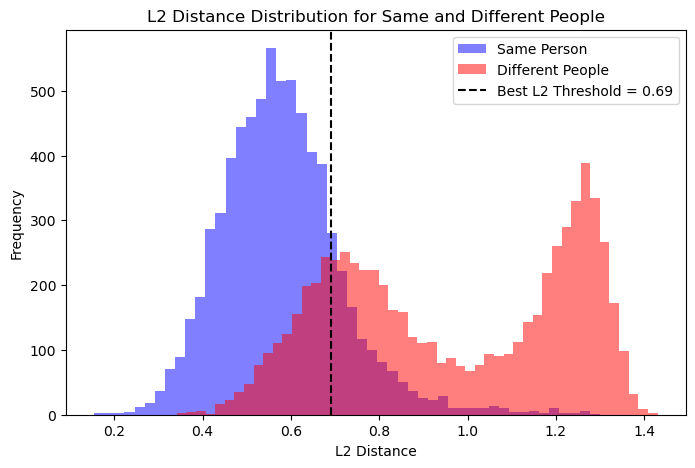

2025-04-05 17:07:26,583 - INFO - VGG Accuracy after Epoch 12: 0.8196


Best Cosine Threshold: 0.75, Accuracy: 0.8196
Best L2 Threshold: 0.6915733218193054, Accuracy: 0.8180


Training epoch 12:: 100%|██████████| 3833/3833 [19:49<00:00,  3.22it/s]
2025-04-05 17:27:16,568 - INFO - Epoch 13/30, Loss: 0.0591, Time for Epoch: 1189.91s, Time since start: 20400.31s
Validating:: 100%|██████████| 13964/13964 [06:27<00:00, 36.01it/s]


Min cos_sim: 0.0273590087890625, Max cos_sim: 0.98388671875
Mean cos_sim: 0.65673828125
Min L2 distance: 0.1781005859375, Max L2 distance: 1.39453125
Mean L2 distance: 0.78564453125


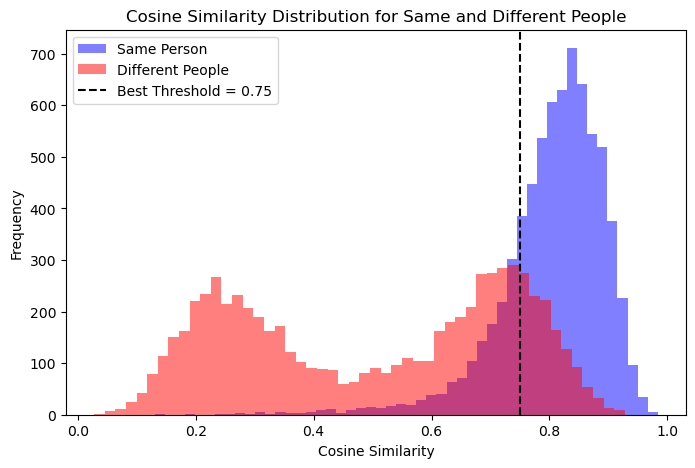

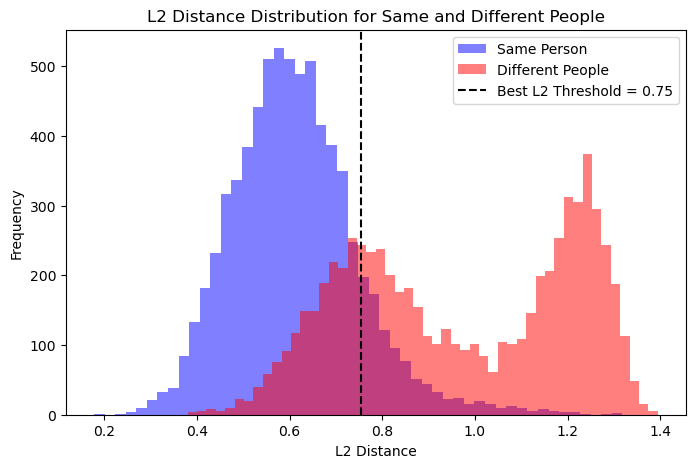

2025-04-05 17:33:44,728 - INFO - VGG Accuracy after Epoch 13: 0.8086


Best Cosine Threshold: 0.75, Accuracy: 0.8086
Best L2 Threshold: 0.7543045878410339, Accuracy: 0.8130


Training epoch 13:: 100%|██████████| 3833/3833 [20:04<00:00,  3.18it/s]
2025-04-05 17:53:49,407 - INFO - Epoch 14/30, Loss: 0.0565, Time for Epoch: 1204.61s, Time since start: 21993.15s
Validating:: 100%|██████████| 13964/13964 [06:27<00:00, 36.07it/s]


Min cos_sim: 0.13427734375, Max cos_sim: 0.9794921875
Mean cos_sim: 0.6630859375
Min L2 distance: 0.2037353515625, Max L2 distance: 1.31640625
Mean L2 distance: 0.79150390625


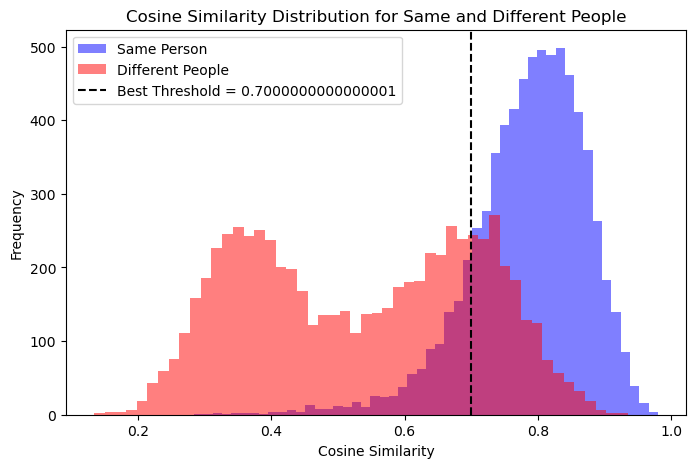

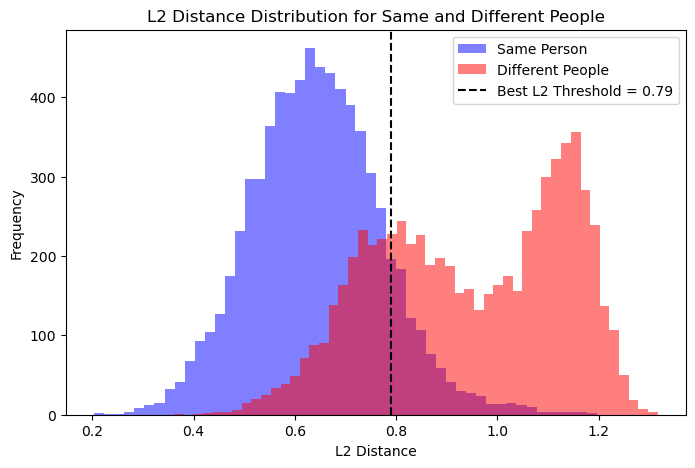

2025-04-05 18:00:16,926 - INFO - VGG Accuracy after Epoch 14: 0.8173


Best Cosine Threshold: 0.7000000000000001, Accuracy: 0.8173
Best L2 Threshold: 0.7893515825271606, Accuracy: 0.8174


Training epoch 14:: 100%|██████████| 3833/3833 [19:55<00:00,  3.21it/s]
2025-04-05 18:20:12,922 - INFO - Epoch 15/30, Loss: 0.0531, Time for Epoch: 1195.92s, Time since start: 23576.66s
Validating:: 100%|██████████| 13964/13964 [06:26<00:00, 36.17it/s]


Min cos_sim: 0.018035888671875, Max cos_sim: 0.98779296875
Mean cos_sim: 0.681640625
Min L2 distance: 0.15869140625, Max L2 distance: 1.4013671875
Mean L2 distance: 0.7431640625


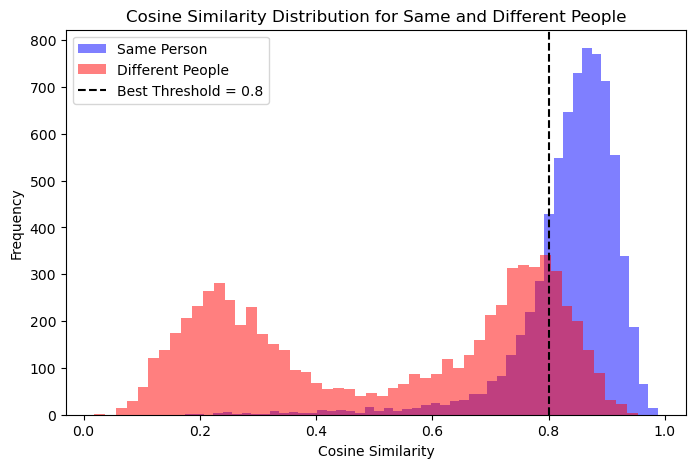

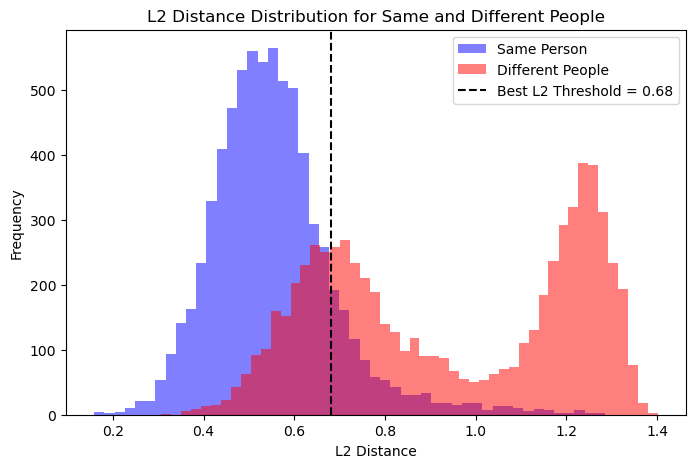

2025-04-05 18:26:39,591 - INFO - VGG Accuracy after Epoch 15: 0.8138


Best Cosine Threshold: 0.8, Accuracy: 0.8138
Best L2 Threshold: 0.6819233298301697, Accuracy: 0.8148


Training epoch 15:: 100%|██████████| 3833/3833 [19:56<00:00,  3.20it/s]
2025-04-05 18:46:36,508 - INFO - Epoch 16/30, Loss: 0.0532, Time for Epoch: 1196.84s, Time since start: 25160.25s
Validating:: 100%|██████████| 13964/13964 [06:26<00:00, 36.13it/s]


Min cos_sim: 0.1168212890625, Max cos_sim: 0.9892578125
Mean cos_sim: 0.728515625
Min L2 distance: 0.14794921875, Max L2 distance: 1.3291015625
Mean L2 distance: 0.6826171875


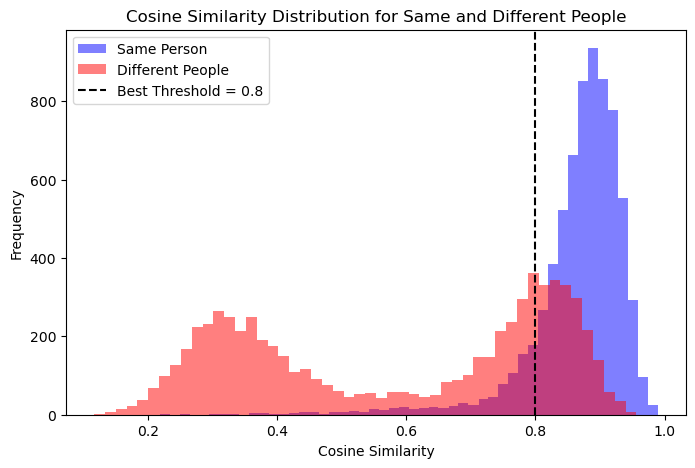

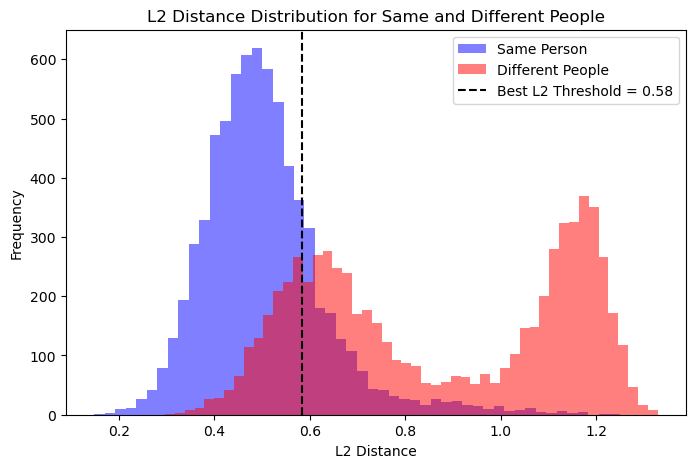

2025-04-05 18:53:03,393 - INFO - VGG Accuracy after Epoch 16: 0.8061


Best Cosine Threshold: 0.8, Accuracy: 0.8061
Best L2 Threshold: 0.5831105709075928, Accuracy: 0.8086


Training epoch 16:: 100%|██████████| 3833/3833 [20:36<00:00,  3.10it/s]
2025-04-05 19:13:39,801 - INFO - Epoch 17/30, Loss: 0.0498, Time for Epoch: 1236.34s, Time since start: 26783.54s
Validating:: 100%|██████████| 13964/13964 [06:50<00:00, 34.06it/s]


Min cos_sim: -0.1890869140625, Max cos_sim: 0.99560546875
Mean cos_sim: 0.74072265625
Min L2 distance: 0.09918212890625, Max L2 distance: 1.5419921875
Mean L2 distance: 0.6201171875


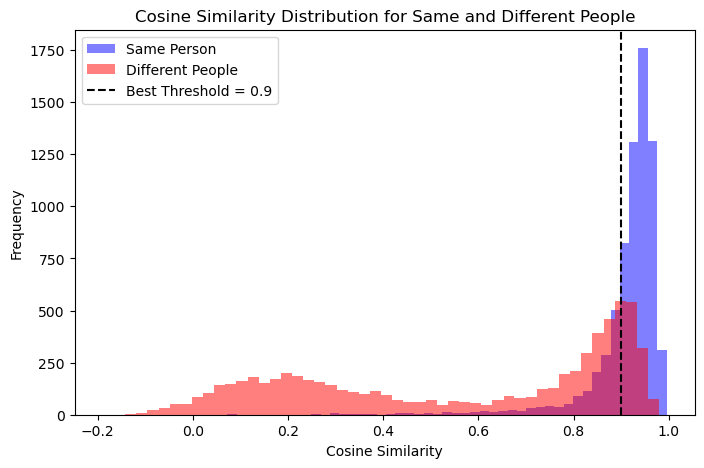

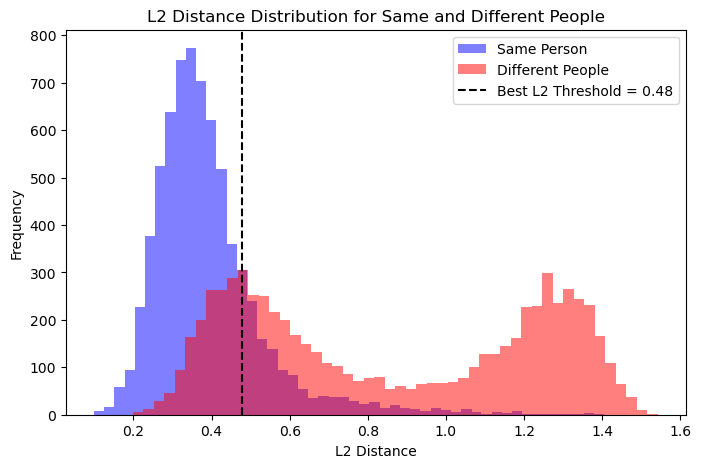

2025-04-05 19:20:30,307 - INFO - VGG Accuracy after Epoch 17: 0.7980


Best Cosine Threshold: 0.9, Accuracy: 0.7980
Best L2 Threshold: 0.4788689613342285, Accuracy: 0.8013


Training epoch 17:: 100%|██████████| 3833/3833 [19:53<00:00,  3.21it/s]
2025-04-05 19:40:24,069 - INFO - Epoch 18/30, Loss: 0.0486, Time for Epoch: 1193.67s, Time since start: 28387.81s
Validating:: 100%|██████████| 13964/13964 [06:32<00:00, 35.60it/s]


Min cos_sim: 0.343505859375, Max cos_sim: 0.990234375
Mean cos_sim: 0.7607421875
Min L2 distance: 0.1434326171875, Max L2 distance: 1.1455078125
Mean L2 distance: 0.6630859375


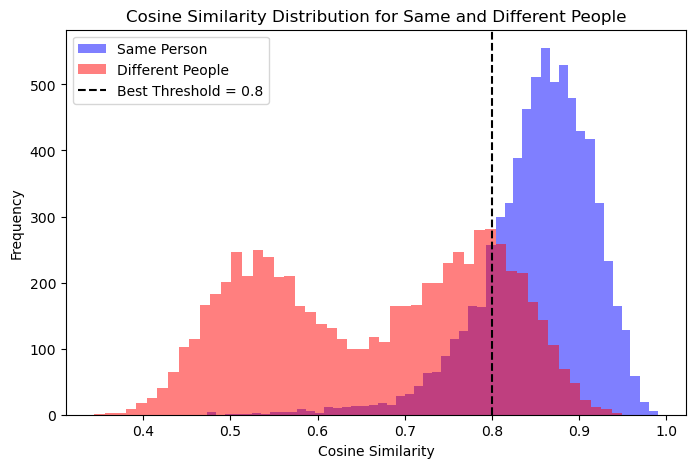

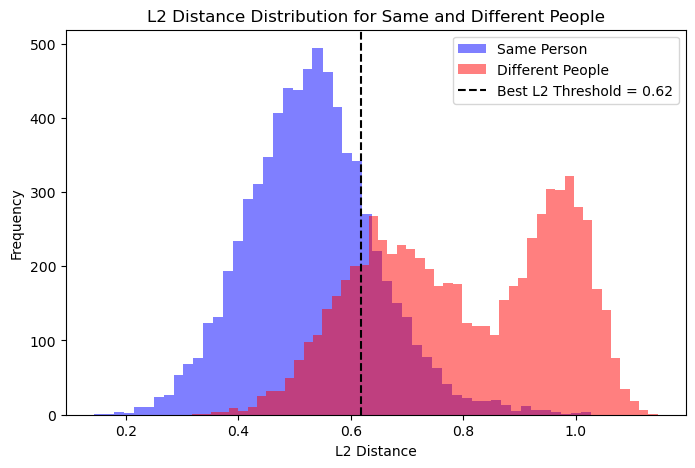

2025-04-05 19:46:56,763 - INFO - VGG Accuracy after Epoch 18: 0.8185


Best Cosine Threshold: 0.8, Accuracy: 0.8185
Best L2 Threshold: 0.6180998086929321, Accuracy: 0.8142


Training epoch 18:: 100%|██████████| 3833/3833 [19:43<00:00,  3.24it/s]
2025-04-05 20:06:40,644 - INFO - Epoch 19/30, Loss: 0.0502, Time for Epoch: 1183.79s, Time since start: 29964.38s
Validating:: 100%|██████████| 13964/13964 [06:29<00:00, 35.81it/s]


Min cos_sim: 0.2548828125, Max cos_sim: 0.98193359375
Mean cos_sim: 0.76611328125
Min L2 distance: 0.1900634765625, Max L2 distance: 1.220703125
Mean L2 distance: 0.64794921875


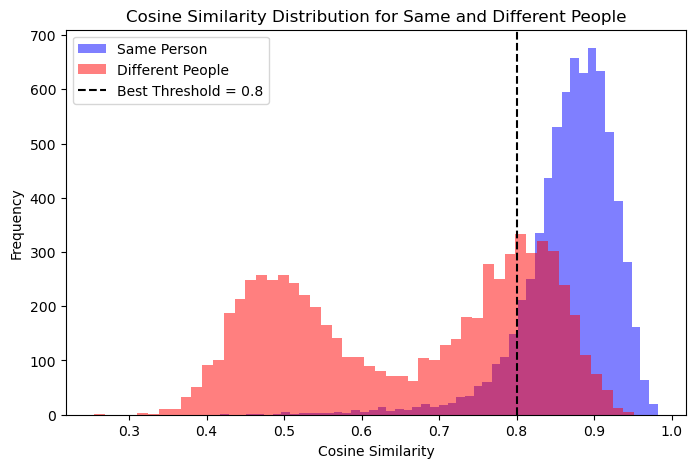

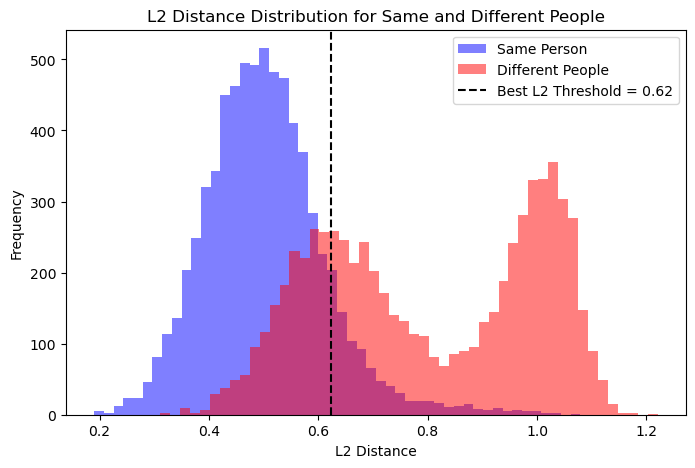

2025-04-05 20:13:11,029 - INFO - VGG Accuracy after Epoch 19: 0.8165


Best Cosine Threshold: 0.8, Accuracy: 0.8165
Best L2 Threshold: 0.6240170001983643, Accuracy: 0.8164


Training epoch 19:: 100%|██████████| 3833/3833 [19:37<00:00,  3.26it/s]
2025-04-05 20:32:48,357 - INFO - Epoch 20/30, Loss: 0.0480, Time for Epoch: 1177.26s, Time since start: 31532.10s
Validating:: 100%|██████████| 13964/13964 [06:28<00:00, 35.94it/s]


Min cos_sim: 0.31396484375, Max cos_sim: 0.98486328125
Mean cos_sim: 0.75341796875
Min L2 distance: 0.175048828125, Max L2 distance: 1.1708984375
Mean L2 distance: 0.671875


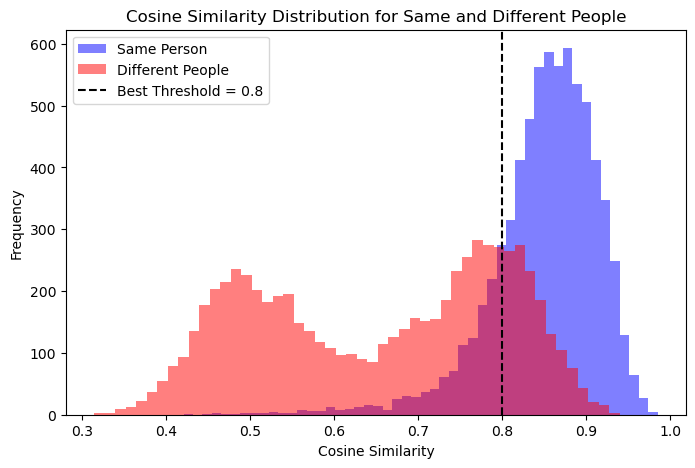

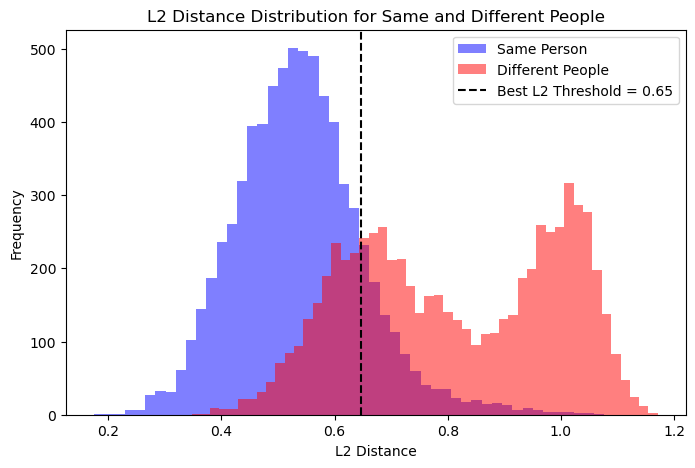

2025-04-05 20:39:17,344 - INFO - VGG Accuracy after Epoch 20: 0.8128


Best Cosine Threshold: 0.8, Accuracy: 0.8128
Best L2 Threshold: 0.6467670202255249, Accuracy: 0.8133


Training epoch 20:: 100%|██████████| 3833/3833 [20:45<00:00,  3.08it/s]
2025-04-05 21:00:03,347 - INFO - Epoch 21/30, Loss: 0.0445, Time for Epoch: 1245.92s, Time since start: 33167.09s
Validating:: 100%|██████████| 13964/13964 [06:38<00:00, 35.07it/s]


Min cos_sim: 0.381591796875, Max cos_sim: 0.97998046875
Mean cos_sim: 0.76171875
Min L2 distance: 0.2005615234375, Max L2 distance: 1.1123046875
Mean L2 distance: 0.67138671875


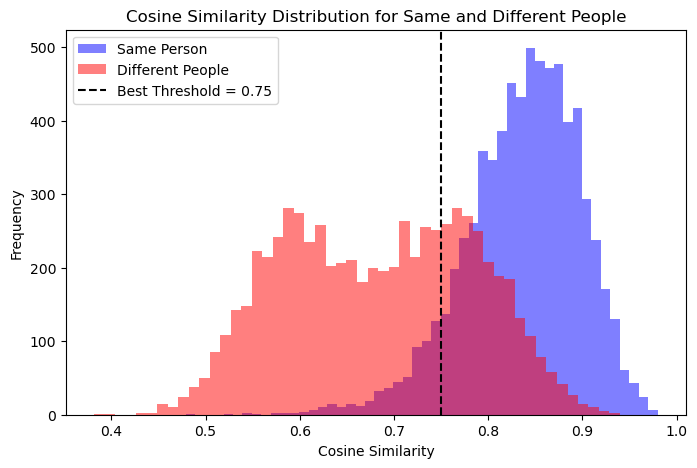

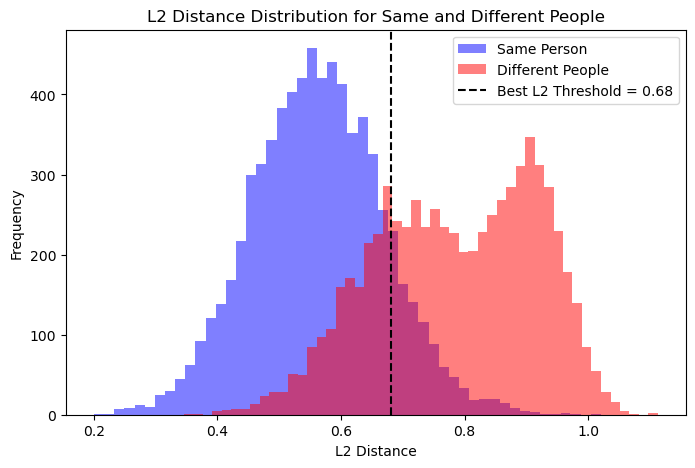

2025-04-05 21:06:41,880 - INFO - VGG Accuracy after Epoch 21: 0.8062


Best Cosine Threshold: 0.75, Accuracy: 0.8062
Best L2 Threshold: 0.6804263591766357, Accuracy: 0.8146


Training epoch 21:: 100%|██████████| 3833/3833 [19:53<00:00,  3.21it/s]
2025-04-05 21:26:35,320 - INFO - Epoch 22/30, Loss: 0.0427, Time for Epoch: 1193.35s, Time since start: 34759.06s
Validating:: 100%|██████████| 13964/13964 [06:58<00:00, 33.39it/s]


Min cos_sim: 0.2132568359375, Max cos_sim: 0.98291015625
Mean cos_sim: 0.740234375
Min L2 distance: 0.1859130859375, Max L2 distance: 1.2548828125
Mean L2 distance: 0.68115234375


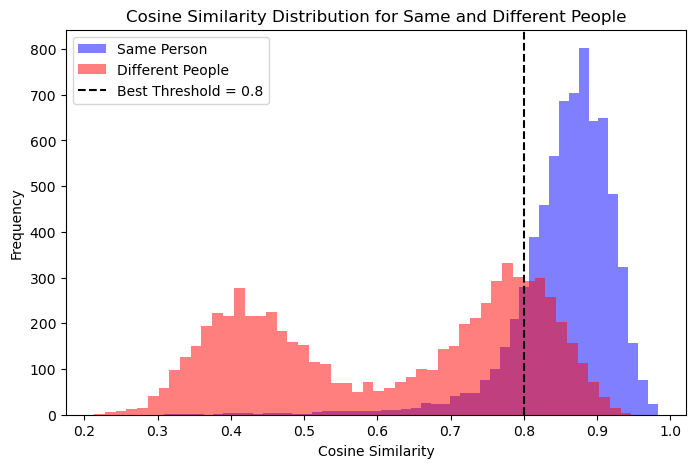

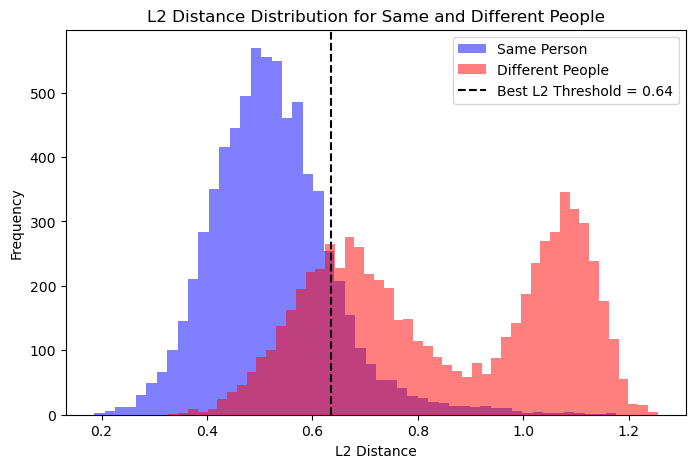

2025-04-05 21:33:33,978 - INFO - VGG Accuracy after Epoch 22: 0.8251


Best Cosine Threshold: 0.8, Accuracy: 0.8251
Best L2 Threshold: 0.6360056400299072, Accuracy: 0.8246


Training epoch 22:: 100%|██████████| 3833/3833 [20:35<00:00,  3.10it/s]
2025-04-05 21:54:09,397 - INFO - Epoch 23/30, Loss: 0.0436, Time for Epoch: 1235.35s, Time since start: 36413.14s
Validating:: 100%|██████████| 13964/13964 [06:40<00:00, 34.87it/s]


Min cos_sim: 0.46142578125, Max cos_sim: 0.98193359375
Mean cos_sim: 0.7822265625
Min L2 distance: 0.1875, Max L2 distance: 1.0380859375
Mean L2 distance: 0.63818359375


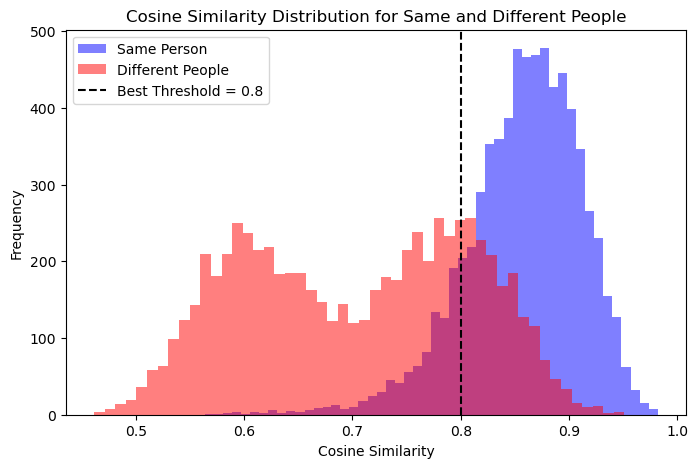

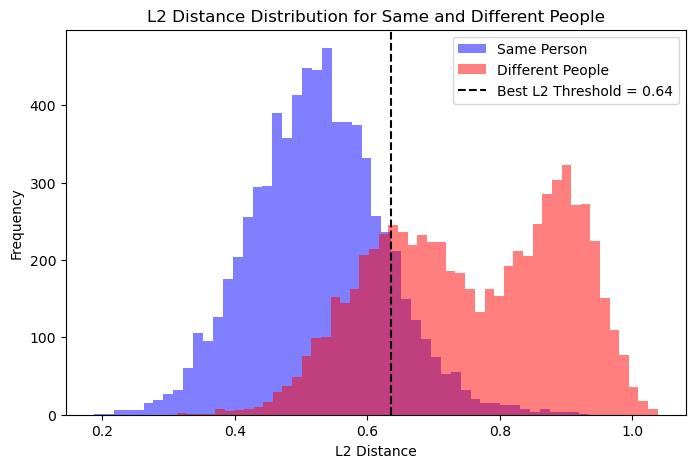

2025-04-05 22:00:50,295 - INFO - VGG Accuracy after Epoch 23: 0.8190


Best Cosine Threshold: 0.8, Accuracy: 0.8190
Best L2 Threshold: 0.6351767778396606, Accuracy: 0.8183


Training epoch 23:: 100%|██████████| 3833/3833 [19:18<00:00,  3.31it/s]
2025-04-05 22:20:09,204 - INFO - Epoch 24/30, Loss: 0.0457, Time for Epoch: 1158.83s, Time since start: 37972.94s
Validating:: 100%|██████████| 13964/13964 [06:19<00:00, 36.78it/s]


Min cos_sim: 0.0158233642578125, Max cos_sim: 0.9921875
Mean cos_sim: 0.7587890625
Min L2 distance: 0.1282958984375, Max L2 distance: 1.4033203125
Mean L2 distance: 0.61865234375


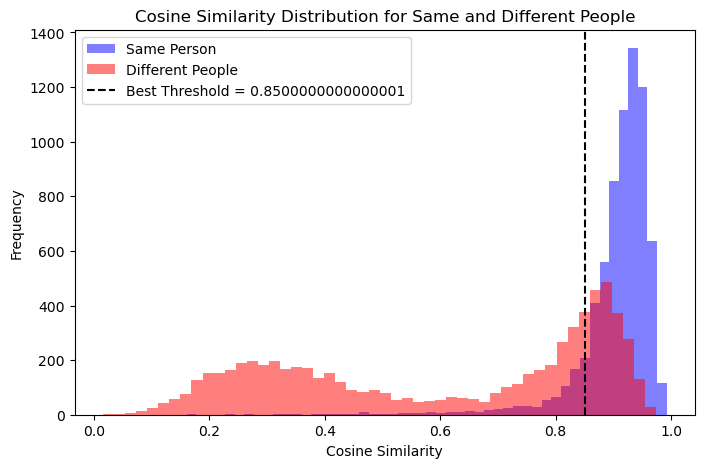

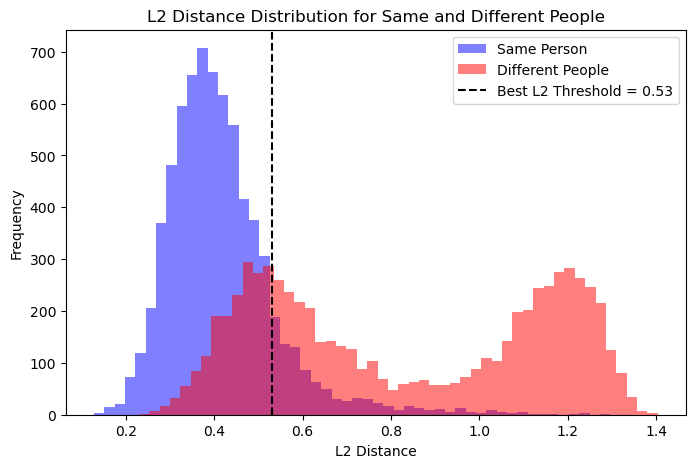

2025-04-05 22:26:29,246 - INFO - VGG Accuracy after Epoch 24: 0.8094


Best Cosine Threshold: 0.8500000000000001, Accuracy: 0.8094
Best L2 Threshold: 0.5309351682662964, Accuracy: 0.8134


Training epoch 24:: 100%|██████████| 3833/3833 [19:58<00:00,  3.20it/s]
2025-04-05 22:46:27,941 - INFO - Epoch 25/30, Loss: 0.0434, Time for Epoch: 1198.62s, Time since start: 39551.68s
Validating:: 100%|██████████| 13964/13964 [06:20<00:00, 36.70it/s]


Min cos_sim: 0.261962890625, Max cos_sim: 0.98876953125
Mean cos_sim: 0.75244140625
Min L2 distance: 0.1552734375, Max L2 distance: 1.2158203125
Mean L2 distance: 0.662109375


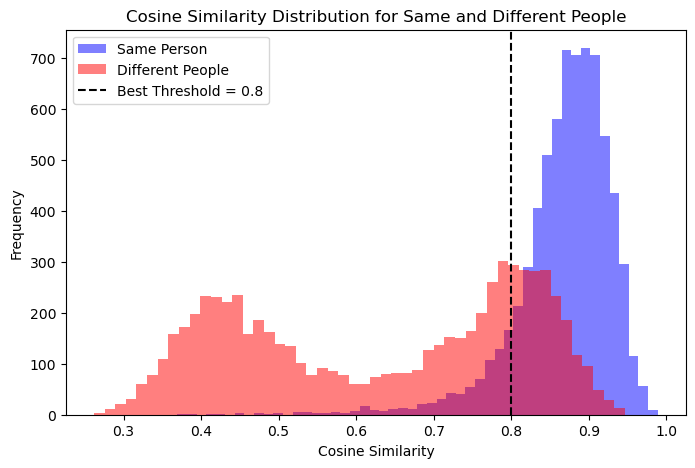

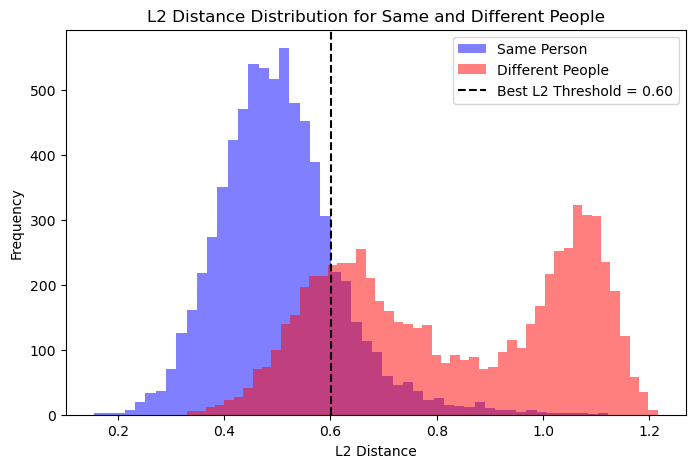

2025-04-05 22:52:48,872 - INFO - VGG Accuracy after Epoch 25: 0.8171


Best Cosine Threshold: 0.8, Accuracy: 0.8171
Best L2 Threshold: 0.6018195152282715, Accuracy: 0.8218


Training epoch 25:: 100%|██████████| 3833/3833 [19:06<00:00,  3.34it/s]
2025-04-05 23:11:55,782 - INFO - Epoch 26/30, Loss: 0.0405, Time for Epoch: 1146.84s, Time since start: 41079.52s
Validating:: 100%|██████████| 13964/13964 [06:19<00:00, 36.76it/s]


Min cos_sim: 0.25390625, Max cos_sim: 0.9833984375
Mean cos_sim: 0.75439453125
Min L2 distance: 0.18408203125, Max L2 distance: 1.2216796875
Mean L2 distance: 0.66357421875


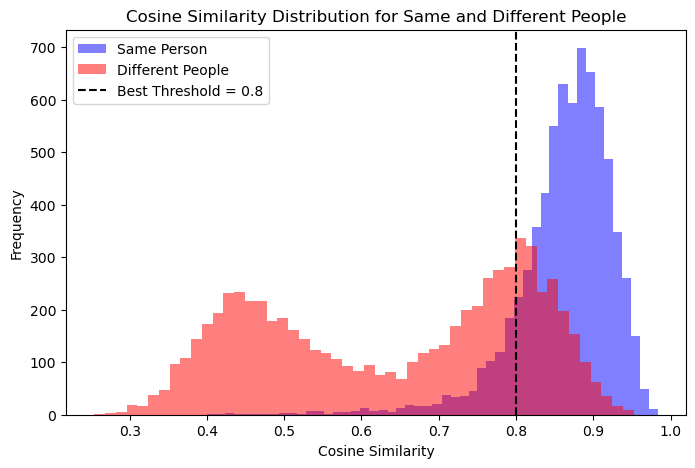

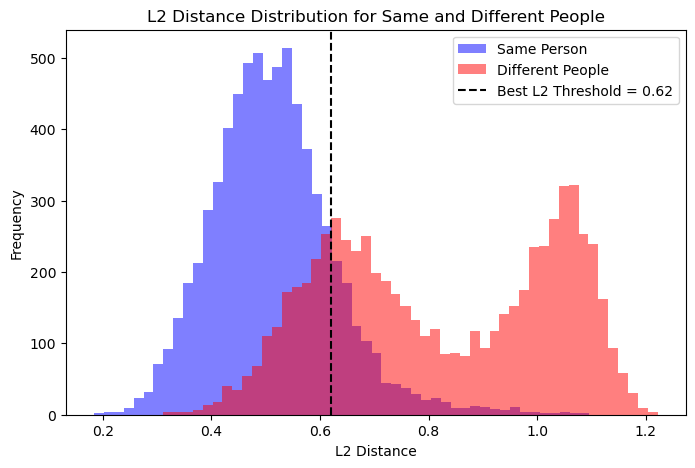

2025-04-05 23:18:16,051 - INFO - VGG Accuracy after Epoch 26: 0.8160


Best Cosine Threshold: 0.8, Accuracy: 0.8160
Best L2 Threshold: 0.6209652423858643, Accuracy: 0.8187


Training epoch 26:: 100%|██████████| 3833/3833 [19:27<00:00,  3.28it/s]
2025-04-05 23:37:43,558 - INFO - Epoch 27/30, Loss: 0.0398, Time for Epoch: 1167.44s, Time since start: 42627.30s
Validating:: 100%|██████████| 13964/13964 [06:17<00:00, 37.02it/s]


Min cos_sim: 0.47509765625, Max cos_sim: 0.98828125
Mean cos_sim: 0.77978515625
Min L2 distance: 0.1531982421875, Max L2 distance: 1.025390625
Mean L2 distance: 0.64453125


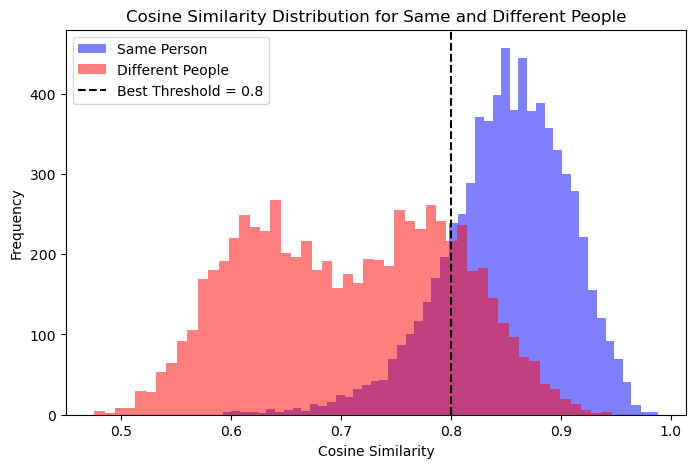

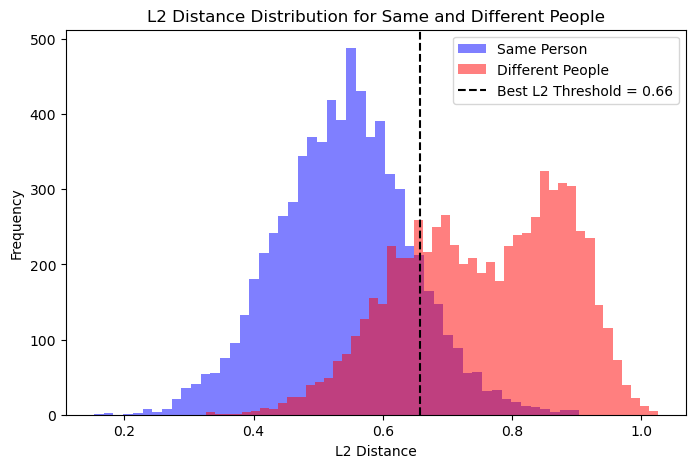

2025-04-05 23:44:01,237 - INFO - VGG Accuracy after Epoch 27: 0.8176


Best Cosine Threshold: 0.8, Accuracy: 0.8176
Best L2 Threshold: 0.6581517457962036, Accuracy: 0.8151


Training epoch 27:: 100%|██████████| 3833/3833 [19:03<00:00,  3.35it/s]
2025-04-06 00:03:05,021 - INFO - Epoch 28/30, Loss: 0.0378, Time for Epoch: 1143.71s, Time since start: 44148.76s
Validating:: 100%|██████████| 13964/13964 [06:15<00:00, 37.20it/s]


Min cos_sim: 0.25048828125, Max cos_sim: 0.98779296875
Mean cos_sim: 0.7646484375
Min L2 distance: 0.1585693359375, Max L2 distance: 1.224609375
Mean L2 distance: 0.64208984375


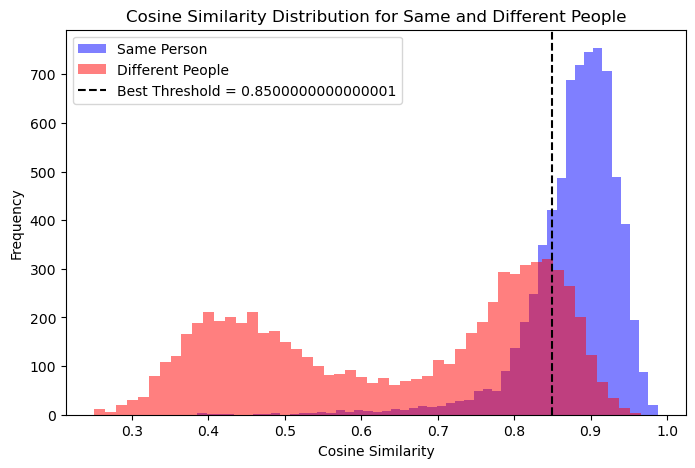

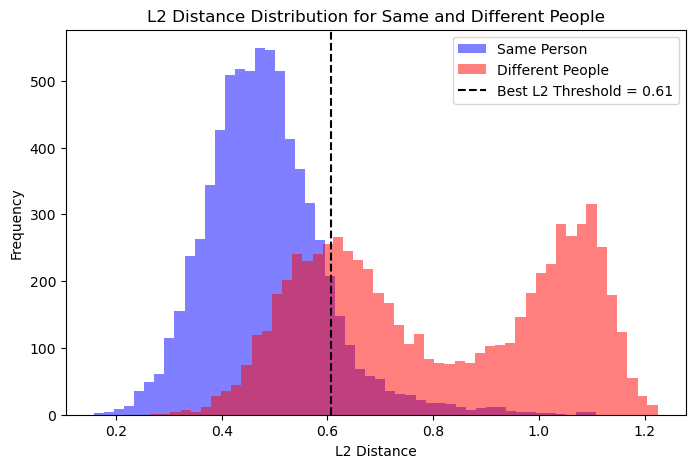

2025-04-06 00:09:20,990 - INFO - VGG Accuracy after Epoch 28: 0.8095


Best Cosine Threshold: 0.8500000000000001, Accuracy: 0.8095
Best L2 Threshold: 0.6074283123016357, Accuracy: 0.8190


Training epoch 28:: 100%|██████████| 3833/3833 [18:54<00:00,  3.38it/s]
2025-04-06 00:28:15,830 - INFO - Epoch 29/30, Loss: 0.0379, Time for Epoch: 1134.75s, Time since start: 45659.57s
Validating:: 100%|██████████| 13964/13964 [06:13<00:00, 37.40it/s]


Min cos_sim: 0.10302734375, Max cos_sim: 0.9892578125
Mean cos_sim: 0.75439453125
Min L2 distance: 0.1473388671875, Max L2 distance: 1.3388671875
Mean L2 distance: 0.63818359375


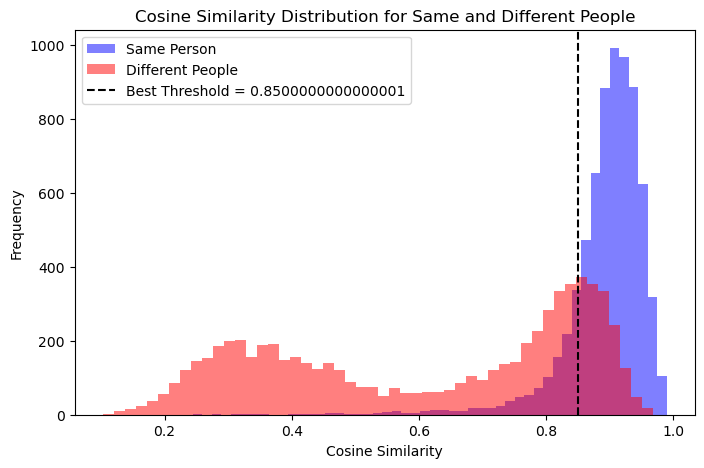

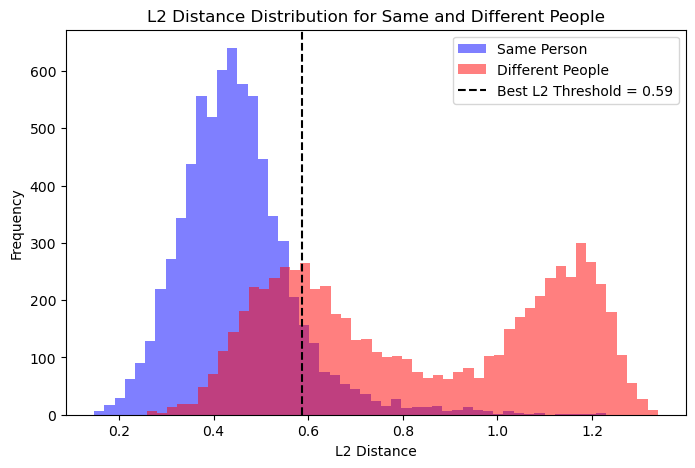

2025-04-06 00:34:29,611 - INFO - VGG Accuracy after Epoch 29: 0.8210


Best Cosine Threshold: 0.8500000000000001, Accuracy: 0.8210
Best L2 Threshold: 0.5863229632377625, Accuracy: 0.8169


Training epoch 29:: 100%|██████████| 3833/3833 [19:17<00:00,  3.31it/s]
2025-04-06 00:53:46,749 - INFO - Epoch 30/30, Loss: 0.0382, Time for Epoch: 1157.06s, Time since start: 47190.49s
Validating:: 100%|██████████| 13964/13964 [06:17<00:00, 36.96it/s]


Min cos_sim: 0.409912109375, Max cos_sim: 0.99169921875
Mean cos_sim: 0.810546875
Min L2 distance: 0.125, Max L2 distance: 1.0869140625
Mean L2 distance: 0.578125


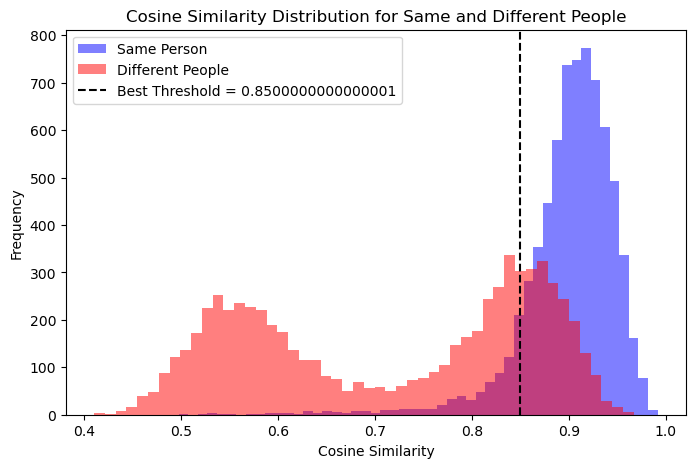

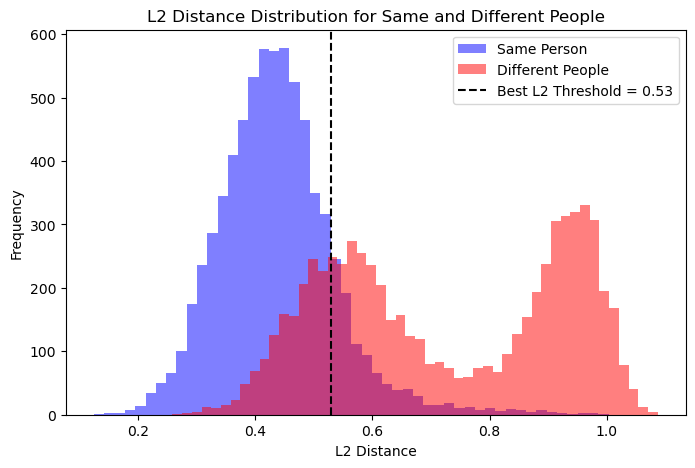

2025-04-06 01:00:05,004 - INFO - VGG Accuracy after Epoch 30: 0.8218


Best Cosine Threshold: 0.8500000000000001, Accuracy: 0.8218
Best L2 Threshold: 0.5300164222717285, Accuracy: 0.8220


In [20]:
ghost_model = GhostFaceNetsV1(image_size=112)
criterion = nn.TripletMarginLoss(margin=1.0, p=2, eps=1e-7)
optimizer = optim.Adam(ghost_model.parameters(), lr=0.001)

loss, acc = ghost_face_net_train(ghost_model, criterion, optimizer, train_dataloader, valid_dataloader, num_epochs=30, device='cuda')

#### Валидация

In [ ]:
ghostfacenet_vgg_accuracy = debug_evaluate_vgg(model, valid_dataloader, device='cuda')

In [ ]:
def visualization(num_epochs, train_losses, val_metrics):
    epochs_range = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, val_metrics, label='VGG Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('VGG Accuracy Over Epochs')
    plt.legend()
    
    plt.show()

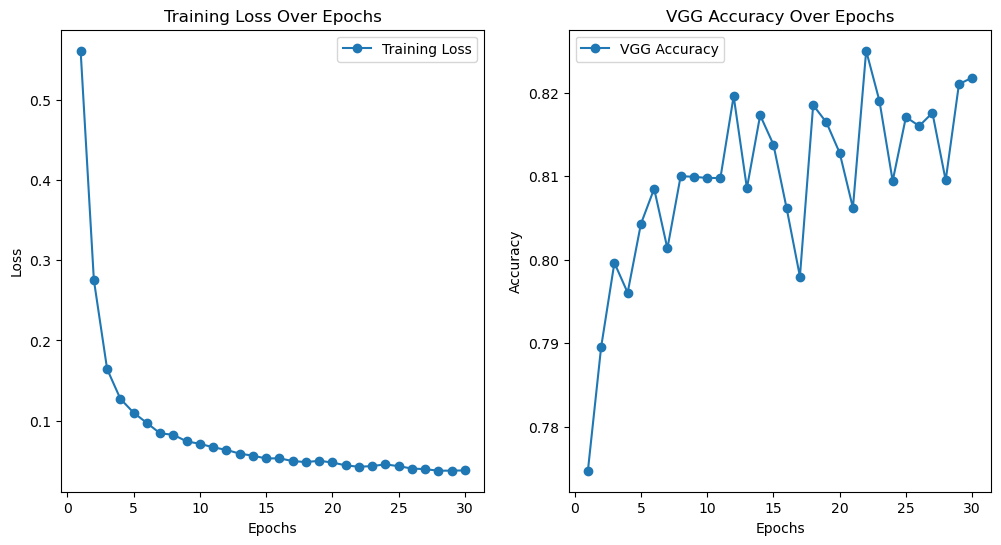

In [31]:
visualization(30, loss, acc)

Validating:: 100%|██████████| 13964/13964 [06:11<00:00, 37.59it/s]


Min cos_sim: 0.2132568359375, Max cos_sim: 0.98291015625
Mean cos_sim: 0.740234375
Min L2 distance: 0.1859130859375, Max L2 distance: 1.2548828125
Mean L2 distance: 0.68115234375


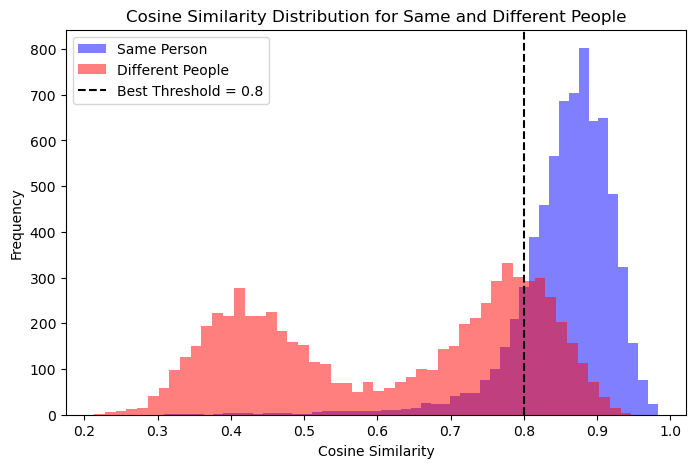

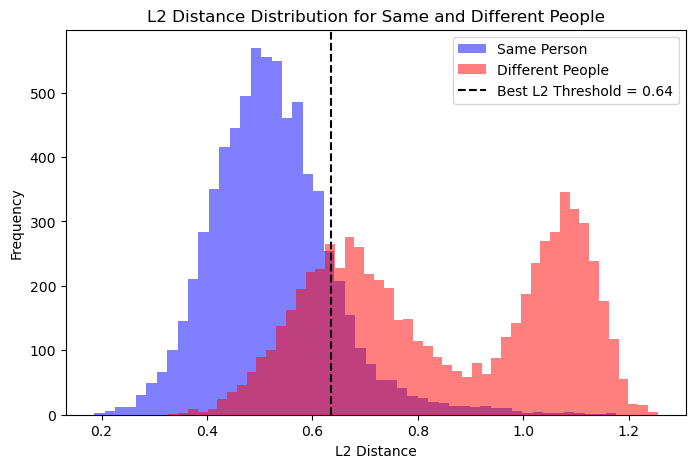

Best Cosine Threshold: 0.8, Accuracy: 0.8251
Best L2 Threshold: 0.6360056400299072, Accuracy: 0.8246


In [19]:
best_ghost_net = GhostFaceNetsV1(image_size=112)

best_ghost_net.load_state_dict(torch.load('GhostFaceNet_21_epoch.pt'))

#best_ghost_net.half()
best_ghost_net.eval()
best_ghost_net.to('cuda')

best_mobilefacenet_vgg_accuracy = debug_evaluate_vgg(best_ghost_net, valid_dataloader, device='cuda')

### FaceNet

In [9]:
facenet_model = InceptionResnetV1(pretrained='casia-webface').eval()

In [10]:
facenet_model.eval()
facenet_model.half()
facenet_model.to('cuda')

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

#### Валидация

Validating:: 100%|██████████| 13964/13964 [10:04<00:00, 23.10it/s]


Min cos_sim: -0.20390012860298157, Max cos_sim: 0.9594317078590393
Mean cos_sim: 0.4296601414680481
Min L2 distance: 0.28484514355659485, Max L2 distance: 1.5517089366912842
Mean L2 distance: 1.0471556186676025


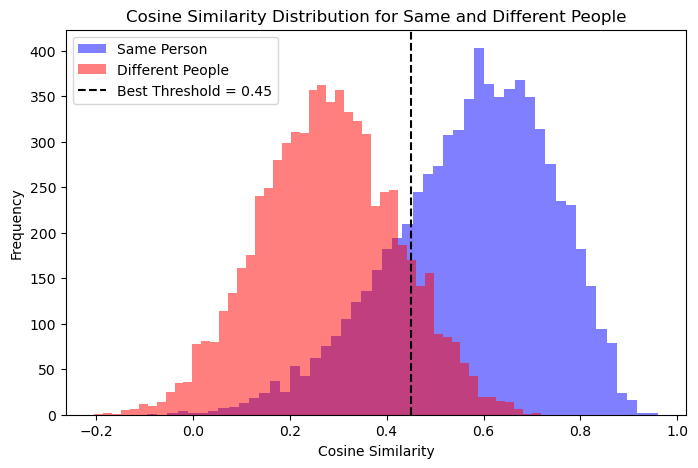

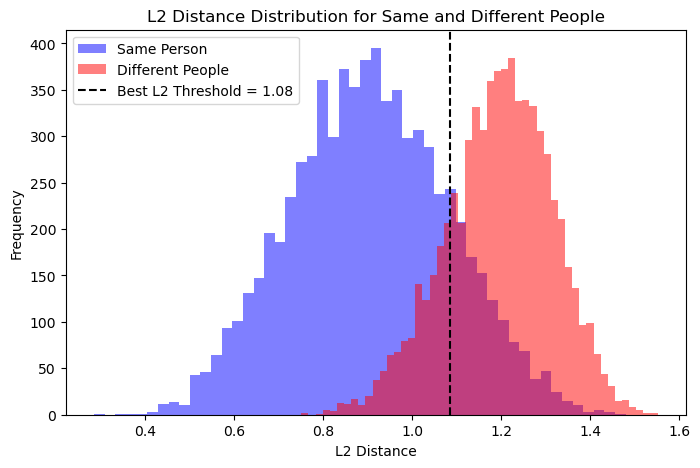

Best Cosine Threshold: 0.45, Accuracy: 0.8314
Best L2 Threshold: 1.0849696397781372, Accuracy: 0.8277


In [13]:
facenet_vgg_accuracy = debug_evaluate_vgg(facenet_model, valid_dataloader, device='cuda')